FAO_FoodSupply_LivestockFish

# Pre-Load

## Libraries and Settings

In [1]:
"""Modules"""

import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup

import lxml
import re
import os
import time
import datetime
import chardet
import zipfile
from zipfile import ZipFile
import json
from io import BytesIO

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.transforms
%matplotlib inline

import folium
from PIL import Image

import numpy as np
import pandas as pd

pd.set_option('precision', 4)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',100)

def curl(url,path,mode='wb'):
    response = urllib.request.urlopen(url).read()
    with open(path, mode) as handle:
        handle.write(response)

In [2]:
""" DIRECTOR SETTINGS"""

FAO_DOWNLOADS_ROOT = 'http://fenixservices.fao.org/faostat/static/bulkdownloads/'
FAO_DOWNLOADS_XML = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.xml')
FAO_DOWNLOADS_JSON = os.path.join(FAO_DOWNLOADS_ROOT, 'datasets_E.json')
FAO_DOWNLOADS_BULK = os.path.join(FAO_DOWNLOADS_ROOT, 'FAOSTAT.zip')

print(f'FAOSTAT downloads root: {FAO_DOWNLOADS_ROOT}')
print(f'FAOSTAT description in .xml: {FAO_DOWNLOADS_XML}')
print(f'FAOSTAT description in .json: {FAO_DOWNLOADS_JSON}')
print(f'FAOSTAT downloads .zip: {FAO_DOWNLOADS_BULK}')

# what is the relevant path of root
root_where = '../../'

# print('+++++++++ Attention ++++++++++')
# print(f'The root is set as "{root_where}" relevant to this file.' )
# print(f'If it is not right, you change this parameter where the parameter name is "root_where".' )
# print('+++++++++++++++++++++++++++++')
# print('')

LOCAL_ROOT = os.path.abspath(root_where)
DATA_BASE = os.path.join(LOCAL_ROOT, 'data')
# print(f'Root director: {LOCAL_ROOT}')
# print(f'Data director: {DATA_BASE}')
# print('')

DATA_FAO = os.path.join(DATA_BASE, 'FAO')
FAO_meta = os.path.join(DATA_FAO, 'metadata')
FAO_description_path = FAO_meta + '/datasets_E.xml'
FAO_BULK_zip = DATA_FAO + '/FAOSTAT.zip'
SUFFIX = '_E_All_Data_(Normalized)'  # suffix of fao data file name
# print(f'FAO data director: {DATA_FAO}')
# print(f'FAO metadata director: {FAO_meta}')
# print(f'FAO local description file: {FAO_description_path}')
# print(f'FAO local data zip: {FAO_BULK_zip}')
print(f'Suffix of raw FAO data file name: {SUFFIX}')
# print('')

DATA_NBS = os.path.join(DATA_BASE, 'NBS')
NBS_meta = os.path.join(DATA_NBS, 'metadata')
# print(f'NBS data director: {DATA_NBS}')
# print(f'NBS metadata director: {NBS_meta}')
# print('')

DATA_hybrids = os.path.join(DATA_BASE, 'hybrids')
# print(f'Hybrids data director: {DATA_hybrids}')
# print('')

FAOSTAT downloads root: http://fenixservices.fao.org/faostat/static/bulkdownloads/
FAOSTAT description in .xml: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.xml
FAOSTAT description in .json: http://fenixservices.fao.org/faostat/static/bulkdownloads/datasets_E.json
FAOSTAT downloads .zip: http://fenixservices.fao.org/faostat/static/bulkdownloads/FAOSTAT.zip
Suffix of raw FAO data file name: _E_All_Data_(Normalized)


In [3]:
# plt.style.use(['ggplot'])

# fig size
FIG_size = (5,3)
DPI = 144

# font size
TIT_size = 12    # titles
LAB_size = 10    # labels
LEG_size = 10    # legends
TCK_size = 10    # ticklabels

LIN_wei = 1.5    # line weights
BAR_wid = 3      # bar width

# GRD_wid = 0.5    # grid line width
# GRD_clr = 'white' 
# GRD_aph = 1     # grid alpha

# Color setting ===================================================================

# 猪，牛，羊，禽肉，鱼，蛋，奶
Pig_pink = '#ffab91'
Bovine_red = '#c62828'
Lamb_green = '#689f38'
Bird_orange = '#ff6f00'
Aqua_cyan = '#80deea'
Egg_yellow = '#ffc400'
Milk_blue = '#1e88e5'

# Good Food
GF_brand_gold = '#fdd835'
GF_brand_gray = '#9F888C'

GF_amber1 = '#ffe57f'
GF_amber2 = '#ffab00'

GF_red0 = '#ffebee'
GF_red1 = '#ff8a80'
GF_red2 = '#d50000'

GF_green1 = '#b9f6ca'
GF_green2 = '#00c853'

GF_blue1 = '#82b1ff'
GF_blue2 = '#2962ff'

# Gray
Gray1 = '#eeeeee'
Gray2 = '#bdbdbd'
Gray3 = '#666666'

CLs = [Pig_pink, Bovine_red, Lamb_green, Bird_orange, Aqua_cyan, Egg_yellow,  Milk_blue]

MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

## Variables

In [4]:
"""小写开头的字母用于临时变量"""

# data -- 用于创建表格的临时数据，创建完后必须赋值给永久变量
# df   -- 用于画图的临时数据，画图时将所需数据赋值给它
# dfs  -- 用于画图的临时数据字典，画图时将所需数据赋值给它
# domain
# 其他小写字母


"""初始化全局变量，请小心操作"""

# 用户自定义参数，会随着用户设置的变化而变化
D = ''    # Domain
A = ''    # Area     单一的国家/地区，
As = []
E = ''    # Element
Es = []
I = ''    # A paticular Item
Is = []   # Items

# 根据用户变量生成
DFs = {}        # 每个 Domain 的所有数据是一份 DF，keys=Domains，no index, columns=['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']
CDTs = {}       # 从DFs筛选数据的条件，key0=Domain, key1=Area, key2=Element, value=Items
PVs_AreaYear = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Areas, columns=Years
PVs_YearArea = {}        # 从DFs根据筛选条件生成的 DICT, key0=Domain, key1=Area, key2=Element, key3=Items, values=DF, index=Years, columns=Areas

Years = []      # 年份列表

PVs_AG = {}     # 某国家地区与其所在组合的某些 Items 的比较，key0=Domain, key1=Area, key2=Element, key3=[AG, A, G], index=Years, columns=[C,G]

# 必要的信息 
DOMs = {}        # Domain 的描述字典， key=domain_name(file name's pref)
LIST_countries=[]  # 国家级地区列表，Area Code < 5000, default refer to  worlds contries
LIST_groups=[]    # 地区组合列表，Area Code >= 5000, default grouped by continents

## Meta Data

In [5]:
def FAO_description_dic(soup):
    """
    input soup parsed by bs4
    parse it to dict with nessesary info
    """
    dic = {}
    for dataset in soup.find_all('Dataset'):
        file_loc = dataset.FileLocation.string
        domain = file_loc[file_loc.find('bulkdownloads/')+len('bulkdownloads/'):file_loc.find('_E_All')]
        dic[domain] = {'DatasetCode': dataset.DatasetCode.string,
                        'DatasetName': dataset.DatasetName.string,
                        'Topic': dataset.Topic.string,
                        'DatasetDescription': dataset.DatasetDescription.string,
                        'MedaData': [dataset.Contact.string, dataset.Email.string, dataset.DateUpdate.string, dataset.CompressionFormat.string, dataset.FileType.string, dataset.FileSize.string, dataset.FileRows.string],
                        'Url_Normalized':dataset.FileLocation.string}
    return dic

In [6]:
""" If you need to update, uncomment this cell. """
# # Download or update FAOSTAT datasets if necessary
# if os.path.exists(FAO_description_path) or os.path.exists(FAO_BULK_zip): pass
# else: 
#     print('Need to download or update FAOSTAT datasets.')
#     print('Processing ...')
#     curl(url=FAO_DOWNLOADS_XML, path=FAO_description_path)
#     curl(url=FAO_DOWNLOADS_BULK, path=FAO_BULK_zip)
    
# # Check local datasets update  
# print('Checking updates ...')

# # local datasets
# print('Checking Local description ...')
# with open(FAO_description_path, 'rb') as handle:
#     xml = handle.read()
#     soup = BeautifulSoup(xml, 'xml')
# xml_local = FAO_description_dic(soup)

# # online datasets
# print('Checking latest description ...')
# response = requests.get(FAO_DOWNLOADS_XML)
# xml = response.content
# soup = BeautifulSoup(xml, 'xml')
# xml_online = FAO_description_dic(soup)

# # compare
# print('Comparing ...')
# shared_items = {k: xml_local[k] for k in xml_local if k in xml_online and xml_local[k] == xml_online[k]}
# need_update = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}
# update_to = {k: xml_local[k] for k in xml_local if xml_local[k] != xml_online[k]}

# print('No. of local datasets: ', len(xml_local))
# print('No. of latest datasets: ', len(xml_online))
# print('No. of shared datasets: ', len(shared_items))

# if len(xml_local)==len(shared_items) and len(xml_local)==len(xml_online):
#     print ('Already up to date.')
# else:
#     print('Need update: ', need_update)
#     print('Update to: ', update_to)
#     print("NOTE: If you don't concern about datasets listed above, there's no need to update!")
    
# print('Done succesfully.')

' If you need to update, uncomment this cell. '

## Read Data Frame

In [7]:
def rdDF(domain):
    
    display(DOMs[domain])
    
    zf = ZipFile(f'{DATA_FAO}/{domain}{SUFFIX}.zip')
    encodings = ["ISO-8859-1", "UTF-8", "UTF-8-SIG", "GBK"]
    for encoding in encodings:
        try:
            data = pd.read_csv(zf.open(f'{domain}{SUFFIX}.csv'), encoding=encoding)
        except:
            pass
    
    display(data.head())
    display(data.tail())

    return data

In [8]:
# 给 Domain 赋值，查看数据基础信息

D = 'FoodSupply_LivestockFish'

with open(FAO_description_path, 'rb') as handle:
    xml = handle.read()
    soup = BeautifulSoup(xml, 'xml')
DOMs = FAO_description_dic(soup)
# display(DOMs)

# Show you raw data
try:
    DATA = rdDF(D)
except:
    with ZipFile(FAO_BULK_zip, 'r') as zf1:
        zf1.extract(f'{D}{SUFFIX}.zip', DATA_FAO)
        DATA = rdDF(D)
print('data shape: ', DATA.shape)

# For FAO Director
Domain_folder = f'FAO_{D}'


{'DatasetCode': 'CL',
 'DatasetName': 'Food Balance: Food Supply - Livestock and Fish Primary Equivalent',
 'Topic': 'Most crop and livestock products, including processed products, under agricultural activity.',
 'DatasetDescription': 'Food supply data is some of the most important data in FAOSTAT. In fact, this data is for the basis for estimation of global and national undernourishment assessment, when it is combined with parameters and other data sets. This data has been the foundation of food balance sheets ever since they were first constructed. The data is accessed by both business and governments for economic analysis and policy setting, as well as being used by the academic community.',
 'MedaData': ['Mr. Salar Tayyib',
  'faostat@fao.org',
  '2018-01-17',
  'zip',
  'csv',
  '13789KB',
  '2029430'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/FoodSupply_LivestockFish_E_All_Data_(Normalized).zip'}

Area Code         Area  Item Code         Item  Element Code  \
0          2  Afghanistan       2731  Bovine Meat           641   
1          2  Afghanistan       2731  Bovine Meat           641   
2          2  Afghanistan       2731  Bovine Meat           641   
3          2  Afghanistan       2731  Bovine Meat           641   
4          2  Afghanistan       2731  Bovine Meat           641   

                         Element  Year Code  Year    Unit    Value Flag  
0  Food supply quantity (tonnes)       1961  1961  tonnes  43000.0    S  
1  Food supply quantity (tonnes)       1962  1962  tonnes  45800.0    S  
2  Food supply quantity (tonnes)       1963  1963  tonnes  47250.0    S  
3  Food supply quantity (tonnes)       1964  1964  tonnes  48000.0    S  
4  Food supply quantity (tonnes)       1965  1965  tonnes  48700.0    S

Area Code                                     Area  Item Code  \
2029425       5817  Net Food Importing Developing Countries       2901   
2029426       5817  Net Food Importing Developing Countries       2901   
2029427       5817  Net Food Importing Developing Countries       2901   
2029428       5817  Net Food Importing Developing Countries       2901   
2029429       5817  Net Food Importing Developing Countries       2901   

                Item  Element Code                             Element  \
2029425  Grand Total           684  Fat supply quantity (g/capita/day)   
2029426  Grand Total           684  Fat supply quantity (g/capita/day)   
2029427  Grand Total           684  Fat supply quantity (g/capita/day)   
2029428  Grand Total           684  Fat supply quantity (g/capita/day)   
2029429  Grand Total           684  Fat supply quantity (g/capita/day)   

         Year Code  Year          Unit  Value Flag  
2029425       2009  2009  g/capita/day  51.99   Fc  
2029426       2010  2010  g/capita/day  52.58   Fc  
2029427       2011  2011  g/capita/day  53.71   Fc  
2029428       2012  2012  g/capita/day  53.58   Fc  
2029429       2013  2013  g/capita/day  53.53   Fc

data shape:  (2029430, 11)


In [9]:
""" This Code will Clean old results, ALL IN THE SAME FOLDER!"""

# path_img = f'{LOCAL_ROOT}/results/{Domain_folder}/img/'
# for i in os.listdir(path_img):
#     path_file = os.path.join(path_img,i)  
#     if os.path.isfile(path_file):
#           os.remove(path_file)
            
# path_map = f'{LOCAL_ROOT}/results/{Domain_folder}/map/'           
# for i in os.listdir(path_map):
#     path_file = os.path.join(path_map,i)
#     if os.path.isfile(path_file) and path_file.endswith(".html"):
#           os.remove(path_file)

' This Code will Clean old results, ALL IN THE SAME FOLDER!'

## Show Countries and Groups

In [10]:
# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
# print('Countries in FAO data of this domain: ')
# display(Countries_FAO)

# Countries in geojson
with open(f'{FAO_meta}/geojson/world_countries.json') as json_file:
    json_data = json.load(json_file)
Countries_json = []
for feature in json_data['features']:
    Countries_json.append(feature['properties']['name'])
# print('Countries in geojson: ')
# display(Countries_json)

# Countries in FAO but not in geojson
Countries_no_json = [c for c in Countries_FAO if c not in Countries_json]
print('Countries in FAO but not in geojson: ')
display(Countries_no_json)

# Countries in geojson but not in FAO
Countries_no_FAO = [c for c in Countries_json if c not in Countries_FAO]
print('Countries in geojson but not in FAO: ')
display(Countries_no_FAO)

# Countries in both FAO and geojson
Countries = [c for c in Countries_json if c in Countries_FAO]
# print('Countries in geojson but not in FAO: ')
# display(Countries)

Countries in FAO but not in geojson: 


['Antigua and Barbuda',
 'Barbados',
 'Belgium-Luxembourg',
 'Bermuda',
 'Cabo Verde',
 'China',
 "C魌e d'Ivoire",
 'Czechoslovakia',
 'Dominica',
 'Ethiopia PDR',
 'French Polynesia',
 'Grenada',
 'Kiribati',
 'Maldives',
 'Malta',
 'Mauritius',
 'Netherlands Antilles (former)',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Serbia and Montenegro',
 'Sudan (former)',
 'USSR',
 'Yugoslav SFR']

Countries in geojson but not in FAO: 


['Antarctica',
 'French Southern and Antarctic Lands',
 'Burundi',
 'Bhutan',
 "Côte d'Ivoire",
 'Democratic Republic of the Congo',
 'Northern Cyprus',
 'Eritrea',
 'Falkland Islands (Malvinas)',
 'Equatorial Guinea',
 'Greenland',
 'Kosovo',
 'Libya',
 'Papua New Guinea',
 'Puerto Rico',
 'Qatar',
 'Western Sahara',
 'South Sudan',
 'Somaliland',
 'Somalia',
 'Syrian Arab Republic',
 'West Bank']

In [11]:
"""adjust FAO countries name"""
# rename because of decoding error
DATA.loc[DATA['Area']=="C魌e d'Ivoire", 'Area'] = "Côte d'Ivoire"

# Countries too small to consider for now
Countries_too_small = [
    'Antigua and Barbuda',  # 安提瓜和巴布达
    'Barbados',             # 巴巴多斯
    'Bermuda',              # 百慕大
    'Cabo Verde',           # 弗德角
    'Dominica',             # 多米尼克, 非多米尼加共和国
    'French Polynesia',     # 法属玻璃尼亚  a part of 'French Southern and Antarctic Lands' of geojson
    'Grenada',              # 格林纳达
    'Kiribati',             # 基里巴斯
    'Maldives',             # 马尔代夫
    'Malta',                # 马耳他
    'Mauritius',            # 毛里求斯
    'Saint Kitts and Nevis',  # 圣基茨和尼维斯
    'Saint Lucia',            # 圣卢西亚
    'Saint Vincent and the Grenadines', # 圣文森特和格林纳丁斯
    'Samoa',                  # 萨摩亚
    'Sao Tome and Principe',  # 圣多美和普林西比
]
DATA = DATA[~DATA['Area'].isin(Countries_too_small)]

# Countries not exists now
Countries_not_now = [
    # 与前苏联解体相关
    'Czechoslovakia',        # dissolved 1992, 捷克斯洛伐克
    'Ethiopia PDR',          # 1987~1991, 埃塞俄比亚人民民主共和国
    'USSR',                  # dissolved 1991
    'Yugoslav SFR',          # 1945~1992, 南斯拉夫社会主义联邦共和国
    'Serbia and Montenegro',         # 1992~2006, 塞尔维亚和黑山国家联盟
    # 
    'Netherlands Antilles (former)', # dissolved 2010, islands, too small
    # 苏丹
    'Sudan (former)',                # dissolved 2011
]
# disslved see map for old

"""adjust geojson"""
# China SARs
China_SARs = [                           # added
    'China, Hong Kong SAR', # add new polygon
    'China, Macao SAR',     # add new polygon
]

# Two Countries can say one or can say independently  # Use 'Belgium' and 'Luxembourg'
Belgium_Luxembourg = [
    'Belgium',
    'Luxembourg',
]
DATA = DATA[~DATA['Area'].isin(['Belgium-Luxembourg'])]

# Sudan (former)                          ! not considered now
Sudan_former = [
    'Sudan',
    'South Sudan',
]

# Add a map before 1992, where:
# following countries in 'USSR'           # added
USSR = [
    "Russian Federation"
    "Kazakhstan",          # 哈萨克斯坦
    "Estonia",             # 爱沙尼亚
    "Ukraine",             # 乌克兰
    "Belarus",             # 白俄罗斯
    "Uzbekistan",          # 乌兹别克斯坦
    "Georgia",             # 格鲁吉亚
    "Azerbaijan",          # 阿塞拜疆
    "Lithuania",           # 立陶宛
    "Republic of Moldova", # 摩尔多瓦
    "Latvia",              # 拉脱维亚
    "Kyrgyzstan",          # 吉尔吉斯斯坦
    "Tajikistan",          # 塔吉克斯坦
    "Armenia",             # 阿美妮娅
    "Turkmenistan",        # 土库曼斯坦
]

# following countries in 'Czechoslovakia'
Czechoslovakia = [
    'Czechia',
    'Slovakia',
]

# following countries in 'Yugoslav SFR'  ! not considered now
Yugoslav_SFR = [
    'The former Yugoslav Republic of Macedonia', # 1992~, 继任前南斯拉夫的北马其顿，rename in geojson from 'North Macedonia'
    'Serbia',      # 2006~
    'Montenegro',  # 2006~
]

# Add a map 1992~2006, where:            ! not added for not considered now
Serbia_Montenegro = [
    'Serbia',     # 2006~
    'Montenegro', # 2006~
]


# Countries in FAO data of this domain
Countries_FAO = DATA[DATA['Area Code']<5000]['Area'].unique().tolist()
print('Countries in FAO data of this domain: ')
display(Countries_FAO)

# Groups in FAO
Groups_FAO = DATA[DATA['Area Code']>=5000]['Area'].unique().tolist()
print('Groups in FAO: ')
display(Groups_FAO)

Countries in FAO data of this domain: 


['Afghanistan',
 'Albania',
 'Algeria',
 'Angola',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, mainland',
 'China, Taiwan Province of',
 'Colombia',
 'Congo',
 'Costa Rica',
 "Côte d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Czechoslovakia',
 "Democratic People's Republic of Korea",
 'Denmark',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Ethiopia PDR',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Hungary',
 'I

Groups in FAO: 


['World',
 'Africa',
 'Eastern Africa',
 'Middle Africa',
 'Northern Africa',
 'Southern Africa',
 'Western Africa',
 'Americas',
 'Northern America',
 'Central America',
 'Caribbean',
 'South America',
 'Asia',
 'Central Asia',
 'Eastern Asia',
 'Southern Asia',
 'South-Eastern Asia',
 'Western Asia',
 'Europe',
 'Eastern Europe',
 'Northern Europe',
 'Southern Europe',
 'Western Europe',
 'Oceania',
 'Australia & New Zealand',
 'Melanesia',
 'Micronesia',
 'Polynesia',
 'European Union',
 'Least Developed Countries',
 'Land Locked Developing Countries',
 'Small Island Developing States',
 'Low Income Food Deficit Countries',
 'Net Food Importing Developing Countries']

In [12]:
# 加载国家列表
for cn in ['China', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of']:
    Countries_FAO.remove(cn)
LIST_countries = Countries_FAO
print(f'There are {len(LIST_countries)} countries')
# display(LIST_countries)

# 加载区域/组合列表
LIST_groups = Groups_FAO
print(f'There are {len(LIST_groups)} groups.')
# display(LIST_groups)

# 自定义常用区域/组合列表
# China
China = ['China, mainland']+China_SARs+['China, Taiwan Province of']

# OECD
LIST_countries_OECD = []
with open(FAO_meta+'/list_countries_OECD.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_OECD.append(line)
print(f'There are {len(LIST_countries_OECD)} OECD countries.')
# display(LIST_countries_OECD)

# BRICS
LIST_countries_BRICS = ['Brazil', 'India', 'Russian Federation', 'South Africa'] + China

# EU
LIST_countries_EU = []
with open(FAO_meta+'/list_countries_EU.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_EU.append(line)

# G20
LIST_countries_G20 = []
with open(FAO_meta+'/list_countries_G20.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_G20.append(line)
LIST_countries_G20 = list(set(LIST_countries_G20 + LIST_countries_EU + China))

# Asia
LIST_countries_asia = []
with open(FAO_meta+'/list_countries_asia.txt', 'r') as handle:
    for line in handle.readlines():
        line=line.strip()
        LIST_countries_asia.append(line)
print(f'There are {len(LIST_countries_asia)} Asian countries.')
# display(LIST_countries_asia)

There are 162 countries
There are 34 groups.
There are 36 OECD countries.
There are 53 Asian countries.


## Show Years Range

In [13]:
# 查看数据 Years 范围
Years = DATA['Year'].unique()
print(f'Dataset years range: {Years[0]} ~ {Years[-1]}')

# 定义 Years 分析范围
# Years = range(1961,2019+1)
print(f'You choose years range: {Years[0]} ~ {Years[-1]}')

DATA = DATA[DATA['Year'].isin(Years)]

Dataset years range: 1961 ~ 2013
You choose years range: 1961 ~ 2013


## Show Element and Items

In [14]:
# 选择列
COLUMNS = ['Area Code', 'Area', 'Element', 'Item', 'Year', 'Unit', 'Value']

DATA = DATA[COLUMNS]
print('data shape: ', DATA.shape)

# 去空值和重复值（不是必须的，检查 data shape）
DATA = DATA.dropna().drop_duplicates()
print('data shape after drop Non. and Dup.: ', DATA.shape)

# 查看数据构成
print('Groupe data by Elements and Items: ')
display(DATA.groupby(['Element','Item']).count())

data shape:  (1860733, 7)
data shape after drop Non. and Dup.:  (1749066, 7)
Groupe data by Elements and Items: 


Area Code  \
Element                                Item                                 
Fat supply quantity (g/capita/day)     Animal Products               9506   
                                       Animal fats                   9506   
                                       Aquatic Animals, Others       7785   
                                       Aquatic Plants                8924   
                                       Aquatic Products, Other       9144   
                                       Bovine Meat                   9506   
                                       Butter, Ghee                  9506   
                                       Cephalopods                   9334   
                                       Cheese                        9272   
                                       Cream                         8689   
                                       Crustaceans                   9451   
                                       Demersal Fish                 9453   
                                       Eggs                          9506   
                                       Fats, Animals, Raw            9484   
                                       Fish, Body Oil                9004   
                                       Fish, Liver Oil               8261   
                                       Fish, Seafood                 9506   
                                       Freshwater Fish               9506   
                                       Grand Total                   9506   
                                       Marine Fish, Other            9400   
                                       Meat                          9506   
                                       Meat, Aquatic Mammals          424   
                                       Meat, Other                   9400   
                                       Milk - Excluding Butter       9506   
                                       Milk, Whole                   9325   
                                       Molluscs, Other               9419   
                                       Mutton & Goat Meat            9506   
                                       Offals                        9506   
                                       Offals, Edible                9506   
                                       Pelagic Fish                  9453   
                                       Pigmeat                       9241   
                                       Poultry Meat                  9506   
                                       Whey                          2800   
Food supply (kcal/capita/day)          Animal Products               9506   
                                       Animal fats                   9506   
                                       Aquatic Animals, Others       7785   
                                       Aquatic Plants                8924   
                                       Aquatic Products, Other       9144   
                                       Bovine Meat                   9506   
                                       Butter, Ghee                  9506   
                                       Cephalopods                   9334   
                                       Cheese                        9272   
                                       Cream                         8691   
                                       Crustaceans                   9451   
                                       Demersal Fish                 9453   
                                       Eggs                          9506   
                                       Fats, Animals, Raw            9484   
                                       Fish, Body Oil                9004   
                                       Fish, Liver Oil               8261   
                                       Fish, Seafood                 9506   
                                       Freshwater Fish      

# Data Visualization

## Parameter Settings

### Area Selection

In [15]:
# 给 Area 赋值
A = 'China, mainland'

data = DATA.copy()

DF_area = data[data['Area']==A]

# display(data.groupby(['Element','Item']).count())
display('Elements:', data.Element.unique())
display('Items:', data.Item.unique())

'Elements:'

array(['Food supply quantity (tonnes)',
       'Food supply quantity (g/capita/day)',
       'Food supply quantity (kg/capita/yr)',
       'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)'], dtype=object)

'Items:'

array(['Bovine Meat', 'Butter, Ghee', 'Cheese', 'Cream', 'Eggs',
       'Fats, Animals, Raw', 'Freshwater Fish', 'Honey', 'Meat, Other',
       'Milk - Excluding Butter', 'Milk, Whole', 'Mutton & Goat Meat',
       'Offals, Edible', 'Poultry Meat', 'Animal fats', 'Animal Products',
       'Fish, Seafood', 'Meat', 'Offals', 'Grand Total',
       'Aquatic Animals, Others', 'Aquatic Plants', 'Cephalopods',
       'Crustaceans', 'Demersal Fish', 'Fish, Body Oil',
       'Fish, Liver Oil', 'Marine Fish, Other', 'Molluscs, Other',
       'Pelagic Fish', 'Pigmeat', 'Aquatic Products, Other', 'Whey',
       'Meat, Aquatic Mammals', 'Meat Meal', 'Hides and skins'],
      dtype=object)

### Element and Items Selection

In [16]:
def mkPV_forArea_ItemYear(area, element):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Element']==element)]
    df = pd.pivot_table(df,index=['Item'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot  

def mkPV_forArea_ElementYear(area, item):   
    df = DATA.copy()
    df = df[(df['Area']==area) & (df['Item']==item)]
    df = pd.pivot_table(df,index=['Element'],columns=['Year'],values=['Value'])
    df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
    df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
    pivot = df
#     display(pivot.head())
    return pivot

In [17]:
# 用于单项测试，可展示某item 相对其他 item 在同一个 area 内的 排名变化，筛选主要的品类，空值可跳过
E = ''

I = ''

pivot=pd.DataFrame()
if E != '': pivot = mkPV_forArea_ItemYear(A, E)
if I != '': pivot = mkPV_forArea_ElementYear(A, I)
if pivot.shape==(0,0):pass
else:
    pivot.sort_values(Years[-1], axis=0, ascending = False, inplace = True)

    rankings={}
    for i in pivot.index.values:
        ranks=np.array([])
        for y in pivot.columns:
            pivot.sort_values(y, axis=0, ascending = False, inplace = True)
            rank = pivot.index.tolist().index(i)
            ranks = np.append(ranks,rank)
        rankings[i]=ranks

    fig = plt.figure(figsize = (16,8))
    plt.title('Rankings of All Items')
    n=0
    lines = LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs+LSs
    colors = CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs+CLs
    
    for i in pivot.index.values:
        plt.plot(pivot.columns, rankings[i],color=colors[n], linestyle=lines[n])
        n+=1
    plt.legend(labels=pivot.index.values,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
    ax = plt.gca().invert_yaxis()

### Explorded Classification of Items

#### FoodSupply_LivestockFish

    'Grand Total':['Animal Products', 'Aquatic Plants'],
    'Animal Products':['Meat','Fish, Seafood','Milk - Excluding Butter','Eggs','Offals','Animal fats'],
    'Meat': ['Poultry Meat', 'Pigmeat','Bovine Meat','Mutton & Goat Meat','Meat, Other'],
    'Fish, Seafood':['Freshwater Fish','Molluscs, Other', 'Crustaceans','Cephalopods','Demersal Fish','Pelagic Fish','Marine Fish, Other'],
    'Milk - Excluding Butter':[],
    'Eggs':[],
    'Offals':[],
    'Animal fats':[],


In [18]:
# 给 Elements 赋值
E = 'Food supply quantity (g/capita/day)'
# 给 Items 赋值
Is = {
    'Grand Total':['Grand Total','Animal Products'],
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [19]:
def getAllItems(
    element,
    items = [],
    items_groups=[],
):
    if items != []: items = items
    else:
        #     如果不设置items_groups，那么 items 仅包含 Is 的末梢，即值为空的键
        if items_groups==[]: items = ITEMs.copy()     
        #     否则，items会包含 Is 中键为 items_groups 中的 item，以及所有的末梢，最后取其的 set 去掉重复元素
        else:
            items = ITEMs.copy()
            for g in items_groups:
                for i in CDTs[element][g]:
                    items.append(i)
            items = list(set(items))
    return items

In [20]:
def getAllItemsInArea(
    area,
    element,
    items=[],
    items_groups=[],
):
    items = getAllItems(element=element, items=items, items_groups=items_groups)
    
    pivot = mkPV_forArea_ItemYear(area=area,element=element).copy()
    
    rankings = {}
    for i in items:
        if i in pivot.index:
            ranks=np.array([])
            for y in Years:
                pivot.sort_values(y, axis=0, ascending=False, inplace=True)
                rank = pivot.index.tolist().index(i)
                ranks = np.append(ranks,rank+1)
            rankings[i]=ranks
    
    df_rank = pd.DataFrame(rankings)
    df_rank.index=Years

#     # uncommets to show line plot
#     fig = plt.figure(figsize = (16,8))
#     plt.title('Rankings of Main Items in {}'.format(area))
    
#     n=0
#     lines = LSs+LSs
#     colors = CLs+CLs
#     for i in df_rank.columns.values:
#         plt.plot(Years, rankings[i], color=colors[n], linestyle=lines[n])
#         n+=1
#     plt.legend(labels=df_rank.columns,loc='lower center',bbox_to_anchor=(1.1,0),borderaxespad = 0.)
#     ax = plt.gca().invert_yaxis()
    
    return list(df_rank.columns)

In [21]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Animal Products']

ITEMs_all = getAllItemsInArea(A, E, items_groups=IsGroup)
print(ITEMs_all)

data = DF_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(ITEMs_all))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位

['Fish, Seafood', 'Mutton & Goat Meat', 'Bovine Meat', 'Milk - Excluding Butter', 'Eggs', 'Pigmeat', 'Meat', 'Animal fats', 'Poultry Meat', 'Offals']


Area Code  Area  \
Element                             Item                                       
Food supply quantity (g/capita/day) Animal fats                     53    53   
                                    Bovine Meat                     53    53   
                                    Eggs                            53    53   
                                    Fish, Seafood                   53    53   
                                    Meat                            53    53   
                                    Milk - Excluding Butter         53    53   
                                    Mutton & Goat Meat              53    53   
                                    Offals                          53    53   
                                    Pigmeat                         53    53   
                                    Poultry Meat                    53    53   

                                                             Year  Unit  Value  
Element                             Item                                        
Food supply quantity (g/capita/day) Animal fats                53    53     53  
                                    Bovine Meat                53    53     53  
                                    Eggs                       53    53     53  
                                    Fish, Seafood              53    53     53  
                                    Meat                       53    53     53  
                                    Milk - Excluding Butter    53    53     53  
                                    Mutton & Goat Meat         53    53     53  
                                    Offals                     53    53     53  
                                    Pigmeat                    53    53     53  
                                    Poultry Meat               53    53     53

Area Code  Area  Element  Item  Year  Value
Unit                                                     
g/capita/day        530   530      530   530   530    530

### Create Pivots for Items

In [22]:
def mkPVs_forItem_AreaYear(
    element,
    df = DATA.copy(), 
    items = [],
    items_groups=[],
):

    items = getAllItems(element=element, items=items, items_groups=items_groups)
    
    dfs = {}
    for i in items:
        dfs[i] = df[(df['Element']==element) & (df['Item']==i)][['Area','Year','Value']]

    pivots = {}
    for i in items:
        df = pd.pivot_table(dfs[i],index=['Area'],columns=['Year'],values=['Value'])
        df.columns.set_names([None, None], inplace=True)    # reset mult-index name 
        df.columns = df.columns.get_level_values(-1)        # flat the multi-index by the last element of each index tuple.
        if df.shape != (0, 0):
            pivots[i] = df
    return pivots

In [23]:
PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, items_groups=IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

'Food supply quantity (g/capita/day)'

'Fish, Seafood'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   0.09   0.09   0.09   0.09   0.08   0.08   0.11   0.10   0.12   
Africa       12.51  12.68  13.58  14.70  14.63  15.37  15.64  14.69  15.07   
Albania       5.25   4.46   4.64   4.51   5.85   5.69   6.92   8.09   9.20   
Algeria       9.06   5.28   3.74   4.17   3.74   4.17   3.83   3.10   3.95   
Americas     24.50  25.63  25.46  25.16  24.67  25.77  25.27  27.26  25.87   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   0.11   0.14   0.13   0.13   0.12   0.14   0.16   0.16   0.16   
Africa       16.75  18.16  18.85  18.90  19.24  20.34  21.43  21.92  22.68   
Albania      10.25   9.99   9.74   9.49   9.84   9.60   9.37   9.14   9.45   
Algeria       4.01   3.78   4.65   4.67   5.64   5.89   5.26   6.21   5.08   
Americas     27.75  27.57  29.91  31.12  29.15  28.13  28.93  29.27  31.69   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   0.16   0.18   0.18   0.19   0.22   0.22   0.23   0.24   0.29   
Africa       22.58  22.21  24.32  24.74  22.46  21.49  20.52  21.25  22.95   
Albania       9.23   9.02   9.18   8.79   9.05   7.11  10.15   7.89   8.89   
Algeria       5.75   6.76   7.95   8.90   8.99   8.73   9.39   9.77  11.68   
Americas     32.86  32.35  34.35  32.30  31.99  34.41  34.36  35.46  37.89   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   0.29   0.29   0.33   0.30   0.30   0.27   0.27   0.25   0.24   
Africa       22.97  23.22  24.20  21.23  21.03  20.44  18.96  20.08  20.57   
Albania       9.18   7.01   5.99   1.63   1.95   2.19   2.41   3.81   2.78   
Algeria      12.07  11.16   9.63   8.09   9.43   9.89  12.96  10.69   7.96   
Americas     36.03  38.71  38.38  35.70  36.30  38.03  37.86  38.12  38.06   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   0.22   0.21   0.21   0.17   0.16   0.17   0.16   0.17   0.16   
Africa       21.23  21.31  22.04  21.56  22.84  21.78  22.76  24.56  25.00   
Albania       3.15   4.69   7.28   8.99   8.99  12.46  11.92  12.71  13.15   
Algeria       8.70   8.99   9.81  10.53  12.21  12.34  13.79  11.59  12.18   
Americas     37.96  37.42  36.71  37.05  37.41  37.83  39.17  40.14  38.54   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   0.15   0.21   0.21   0.20   0.20   0.19   0.19   0.18  
Africa       26.95  28.42  27.76  27.20  28.61  30.18  30.00  29.50  
Albania      13.07  14.35  15.01  16.18  15.69  16.05  13.61  13.35  
Algeria      14.04  14.05  12.87  13.00  10.43  10.80  10.93  10.73  
Americas     40.22  39.26  38.55  38.42  38.48  38.79  38.83  38.90

'Food supply quantity (g/capita/day)'

'Mutton & Goat Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  22.40  21.69  22.16  22.89  23.67  24.60  26.89  29.14  27.15   
Africa        7.37   7.18   6.97   7.01   7.20   7.35   7.30   7.48   7.64   
Albania      21.34  20.88  19.34  18.95  18.42  18.21  22.43  18.95  15.90   
Algeria       9.94   8.91   7.82   8.37   8.63   8.01   7.57   8.86   8.94   
Americas      5.21   5.14   4.81   4.49   4.31   4.45   4.34   4.47   4.18   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  26.41  25.97  20.71  22.79  23.78  24.77  29.20  28.85  29.32   
Africa        7.35   7.32   7.24   6.63   6.23   6.43   6.52   6.68   6.84   
Albania      14.86  14.63  13.58  13.23  13.20  13.09  13.11  12.20  13.03   
Algeria       9.32   9.30   9.30   9.53   8.95   8.94   9.28   9.50   9.64   
Americas      4.09   4.05   3.85   3.38   3.17   2.93   2.77   2.62   2.48   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  28.53  30.34  32.23  33.46  32.33  30.90  28.04  25.96  28.18   
Africa        6.87   6.89   6.87   6.61   6.55   6.41   6.41   6.23   6.42   
Albania      12.92  12.62  12.33  11.38  10.66   9.04   8.72   7.80   8.09   
Algeria      10.43  10.62  10.72  12.52  12.21  12.68  11.89  11.83  13.14   
Americas      2.46   2.33   2.36   2.35   2.35   2.34   2.34   2.49   2.39   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  30.07  31.25  31.53  29.83  26.38  23.76  22.30  20.81  21.54   
Africa        6.72   6.84   6.76   6.76   6.86   6.54   6.67   6.81   6.77   
Albania       8.95   9.66   9.54   9.90  11.76  12.19  14.98  14.93  13.79   
Algeria      13.10  14.70  15.51  15.66  16.39  17.28  16.97  16.87  17.58   
Americas      2.39   2.34   2.35   2.40   2.34   2.33   2.33   2.25   2.01   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  22.99  24.46  26.33  22.57  18.75  14.66  14.42  14.94  14.71   
Africa        7.07   7.22   7.52   7.69   7.66   7.55   7.49   7.54   7.81   
Albania      13.01  13.80  15.19  16.40  16.24  16.65  16.78  18.49  18.56   
Algeria      16.16  16.19  15.67  15.76  15.17  15.12  14.97  16.05  16.67   
Americas      1.94   1.97   2.05   2.11   2.13   2.12   2.07   2.15   2.06   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan  12.76  10.49  13.02  13.58  15.17  15.11  14.26  13.47  
Africa        7.87   7.90   8.02   7.95   7.88   7.92   7.59   7.62  
Albania      18.81  23.04  26.38  29.66  33.18  35.35  41.78  41.98  
Algeria      16.43  16.34  15.15  15.98  16.37  19.60  20.06  21.06  
Americas      2.08   2.18   2.09   1.97   1.91   1.79   1.74   1.77

'Food supply quantity (g/capita/day)'

'Bovine Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  13.16  13.73  13.86  13.77  13.66  18.65  17.42  18.59  19.15   
Africa       18.93  18.38  18.23  18.14  18.19  18.39  18.30  18.61  18.61   
Albania      11.98  11.79  11.76   9.02   9.65   9.82  11.71   9.98  11.69   
Algeria      11.11   9.05   6.47   5.88   6.13   6.29   6.06   6.58   6.51   
Americas     84.46  84.97  87.24  88.80  88.47  90.73  91.73  94.31  94.90   

              1970   1971   1972   1973   1974   1975    1976   1977   1978  \
Area                                                                          
Afghanistan  15.42  15.00  14.35  14.42  13.84  13.31   13.33  13.87  13.91   
Africa       18.41  17.67  17.54  17.77  17.68  17.34   18.00  18.37  19.10   
Albania      12.68  13.36  12.90  12.46  12.62  11.18   13.52  12.05  14.18   
Algeria       5.56   6.88   7.42   7.54   8.07   7.67    8.29  10.26   8.57   
Americas     94.54  90.29  90.94  87.39  92.02  96.84  102.49  99.75  97.42   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  14.67  13.93  14.37  14.96  15.22  15.72  16.16  16.54  17.49   
Africa       18.76  19.44  19.05  19.68  19.44  19.16  18.98  18.18  17.43   
Albania      14.46  14.42  14.19  13.87  14.87  15.15  15.13  13.36  13.92   
Algeria       8.19   8.65   9.04   9.25  11.54   8.47  10.59  11.26  10.20   
Americas     89.18  88.70  89.22  86.35  86.45  86.58  87.93  90.18  86.82   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  17.82  17.54  20.21  18.80  17.14  17.56  18.85  20.25  21.28   
Africa       17.05  16.80  17.08  17.52  17.48  17.07  16.55  15.80  15.48   
Albania      16.51  16.98  18.76  31.27  31.45  24.45  26.58  28.16  32.67   
Algeria      10.41   9.44  10.44  11.36  11.61  12.01  11.92  12.45  11.62   
Americas     85.62  84.26  82.82  83.27  82.63  80.94  83.56  84.66  86.43   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  22.47  24.03  20.42  16.77  13.86  18.52  16.28  17.22  15.95   
Africa       15.69  15.62  16.01  16.42  15.05  15.92  16.10  16.51  17.32   
Albania      29.58  29.33  30.37  31.09  31.20  35.53  38.04  40.61  41.13   
Algeria      10.21  11.17  12.18  12.48   9.38  11.37  14.00  17.75  17.70   
Americas     84.96  84.45  86.15  85.98  84.19  85.12  82.28  82.55  83.77   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan  12.95  14.61  13.61  13.48  12.87  13.24  14.09  12.56  
Africa       17.91  18.04  17.48  17.31  17.30  17.26  17.09  17.34  
Albania      49.83  50.31  55.39  53.99  58.56  58.21  61.37  61.64  
Algeria      15.48  15.18  14.60  15.69  12.62  13.49  15.79  15.34  
Americas     84.62  84.85  83.93  82.42  81.47  79.95  80.16  79.88

'Food supply quantity (g/capita/day)'

'Milk - Excluding Butter'

1961     1962     1963     1964    1965    1966     1967  \
Area                                                                      
Afghanistan  162.48  160.470  174.990  175.480  188.00  190.56  201.490   
Africa        82.07   81.735   80.575   80.675   85.70   86.62   87.055   
Albania      267.07  264.950  264.060  265.560  266.47  267.16  270.640   
Algeria      124.05  114.650  100.060  106.690  108.71  116.43  118.350   
Americas     452.04  439.950  442.530  444.030  438.04  442.50  428.510   

                1968    1969    1970    1971    1972     1973     1974  \
Area                                                                     
Afghanistan  205.920  202.99  171.67  151.45  151.94  164.610  169.390   
Africa        89.295   88.87   89.72   92.58   88.95   86.625   89.145   
Albania      263.150  264.16  272.44  295.13  288.44  311.910  308.050   
Algeria      134.720  136.35  128.87  137.17  143.25  135.670  165.140   
Americas     431.600  429.63  424.85  423.08  425.75  426.880  424.840   

               1975     1976    1977    1978    1979     1980    1981    1982  \
Area                                                                            
Afghanistan  169.60  171.060  154.40  154.77  155.82  162.570  170.32  173.69   
Africa        91.97   92.075   98.32  101.10  101.66  103.145  107.47  107.24   
Albania      305.76  305.780  324.78  341.73  348.27  355.760  367.12  373.84   
Algeria      170.16  188.090  200.08  201.24  192.82  216.190  246.00  246.92   
Americas     413.87  426.800  425.73  416.03  421.07  430.800  420.54  423.30   

               1983    1984     1985    1986    1987     1988    1989  \
Area                                                                    
Afghanistan  189.99  190.57  158.250  111.00  127.51  132.510  134.53   
Africa       106.74   99.48  103.835   99.50  100.56   99.905  100.17   
Albania      377.24  361.96  329.230  323.32  336.16  351.300  358.65   
Algeria      267.87  264.17  285.200  253.16  274.19  253.130  280.63   
Americas     419.91  419.87  430.130  433.96  438.96  423.170  425.92   

                1990    1991    1992    1993    1994    1995    1996    1997  \
Area                                                                           
Afghanistan  180.470  178.46  167.56  172.46  188.11  194.10  211.58  225.01   
Africa       100.275   96.41   97.29   97.41   94.30   99.44   91.55   95.39   
Albania      413.780  462.54  501.85  522.92  639.30  744.81  809.76  681.20   
Algeria      276.130  264.26  274.29  330.70  294.39  271.51  218.91  247.21   
Americas     426.030  426.27  435.42  432.24  435.84  445.61  444.27  440.48   

               1998     1999    2000    2001    2002    2003    2004    2005  \
Area                                                                           
Afghanistan  230.17  255.670  200.64  130.56  209.79  193.33  188.16  175.19   
Africa        97.57   98.615  101.47  105.57  114.54  118.48  119.19  120.87   
Albania      641.21  652.040  674.55  701.34  722.95  782.68  782.69  799.91   
Algeria      273.24  262.780  282.20  310.47  310.23  287.17  324.55  323.53   
Americas     442.55  445.530  448.78  448.74  448.56  442.61  436.60  443.71   

               2006    2007    2008    2009    2010    2011    2012    2013  
Area                                                                         
Afghanistan  162.16  168.67  161.28  161.07  162.65  157.80  174.08  170.50  
Africa       121.24  124.24  123.36  122.50  127.71  127.25  124.45  120.05  
Albania      818.46  760.33  782.26  782.91  800.20  825.40  821.50  832.12  
Algeria      332.95  333.20  330.43  363.62  363.82  413.71  398.80  387.74  
Americas     443.11  448.57  455.56  456.44  457.16  462.45  468.99  462.57

'Food supply quantity (g/capita/day)'

'Eggs'

1961   1962   1963   1964   1965   1966   1967    1968   1969  \
Area                                                                          
Afghanistan   2.57   2.78   2.84   2.90   3.03   3.05   3.40   3.050   3.20   
Africa        3.28   3.31   3.29   3.39   3.57   3.69   3.77   3.895   3.94   
Albania       4.10   4.14   3.87   3.83   3.80   3.70   4.01   4.180   4.47   
Algeria       3.23   2.74   1.95   1.87   1.86   1.78   1.87   1.990   2.10   
Americas     28.00  27.81  27.39  27.66  27.49  27.46  28.14  27.650  27.35   

              1970    1971    1972   1973   1974   1975   1976   1977   1978  \
Area                                                                           
Afghanistan   2.84   2.570   2.500   2.49   2.43   2.41   2.36   2.36   2.34   
Africa        3.87   3.915   3.955   3.98   4.18   4.40   4.40   4.63   4.88   
Albania       4.43   4.120   4.200   4.86   5.44   7.00   6.83   6.45   7.35   
Algeria       2.02   2.010   2.050   2.07   2.20   2.82   3.67   4.88   8.56   
Americas     27.56  27.640  27.410  26.33  25.88  25.87  25.59  25.45  26.36   

              1979   1980    1981    1982   1983   1984    1985   1986   1987  \
Area                                                                            
Afghanistan   2.35   2.36   2.450   2.510   2.58   2.67   2.740   2.81   2.86   
Africa        4.88   5.05   5.085   5.485   5.47   5.22   5.335   5.45   5.70   
Albania       7.18   7.01   6.850   7.650   8.42   8.67   9.350   9.79  10.62   
Algeria       6.79   9.30   9.670  13.400  14.28  10.67  11.360   7.47   8.66   
Americas     27.25  27.36  26.860  27.000  26.37  26.52  26.830  27.52  27.56   

              1988    1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                          
Afghanistan   2.87   2.890   2.70   2.52   2.31   2.12   1.98   1.86   2.25   
Africa        5.79   5.405   5.95   5.90   5.80   5.68   5.79   5.78   5.36   
Albania      10.43  11.670  12.08   9.50   9.73  13.47  13.36  13.87  15.58   
Algeria       9.28   9.640  13.32  11.79   8.77   8.54   9.27  10.63   6.28   
Americas     27.12  26.480  26.05  26.64  26.25  26.24  26.50  26.24  26.13   

              1997   1998    1999   2000   2001   2002   2003   2004   2005  \
Area                                                                          
Afghanistan   2.16   2.10   2.060   1.62   1.34   1.94   2.02   1.74   1.95   
Africa        5.26   5.81   5.935   5.72   5.87   6.21   6.12   6.13   6.02   
Albania      13.16  14.01  14.960  17.19  16.07  17.62  19.11  19.17  19.25   
Algeria       7.08   8.23   6.790   7.29   7.73  11.85  12.15  13.00  12.34   
Americas     26.95  27.05  28.130  28.80  29.43  29.24  29.29  29.65  29.95   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   1.86   2.53   2.88   2.72   2.27   3.00   2.37   3.56  
Africa        6.16   6.39   6.51   6.14   6.56   6.76   7.40   7.27  
Albania      19.44  18.21  19.22  20.79  20.20  21.15  34.77  34.11  
Algeria      12.42  13.41  12.30  12.77  17.19  18.16  19.90  22.08  
Americas     31.15  30.48  30.64  31.40  31.79  32.44  32.38  33.36

'Food supply quantity (g/capita/day)'

'Pigmeat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                      
Africa     1.86   1.75   1.69   1.76   1.75   1.73   1.80   1.84   1.91   
Albania    5.88   5.80   4.95   4.81   5.32   6.12   6.76   7.51   8.02   
Algeria    3.86   1.63   0.40   0.34   0.39   0.35   0.08   0.08   0.07   
Americas  46.11  46.65  47.14  46.64  42.82  43.14  46.05  46.76  45.77   
Angola     4.34   4.25   4.21   4.14   4.58   4.45   4.35   4.35   4.32   

           1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                      
Africa     1.87   1.91   1.99   2.01   1.91   1.89   1.90   1.94   1.94   
Albania    8.04   8.04   7.98   7.31   7.41   7.22   7.27   7.31   7.14   
Algeria    0.06   0.04   0.02   0.01   0.00   0.01   0.01   0.02   0.01   
Americas  46.97  50.53  47.29  44.09  46.53  40.45  42.24  44.20  44.24   
Angola     4.21   4.38   4.35   4.51   4.70   4.85   5.08   5.88   5.96   

           1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                      
Africa     1.91   1.96   2.02   2.03   2.02   2.09   2.12   2.21   2.37   
Albania    7.18   7.01   8.61   8.42   8.60   8.76   9.26   9.70   9.44   
Algeria    0.01   0.01   0.02   0.01   0.01   0.05   0.01   0.01   0.01   
Americas  49.05  51.80  49.90  45.50  47.29  45.86  45.22  42.27  42.66   
Angola     6.59   7.81   7.20   7.06   7.24   8.95   9.05   8.01   7.99   

           1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                      
Africa     2.41   2.62   2.64   2.52   2.61   2.57   2.58   3.11   3.13   
Albania    9.86   9.66  10.57   7.21   9.50  13.46  14.44  13.94   8.75   
Algeria    0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.02   
Americas  44.53  43.20  41.41  42.34  44.44  45.02  46.46  45.98  43.72   
Angola     8.02   8.53   8.24   7.77   7.81   7.32   7.28   7.53   8.38   

           1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                      
Africa     3.12   3.05   2.99   2.89   2.91   2.96   2.97   3.18   3.25   
Albania    7.50  13.72  16.60  11.37  18.03  19.52  22.08  24.03  25.14   
Algeria    0.01   0.01   0.01   0.01   0.02   0.02   0.02   0.02   0.02   
Americas  43.73  47.73  48.66  47.86  47.08  47.19  47.73  47.73  45.11   
Angola     8.24   8.74   7.71   8.02   8.96   9.88  10.17  10.60  11.52   

           2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                              
Africa     3.28   3.65   3.91   3.97   3.61   3.81   3.93   4.04  
Albania   32.82  33.43  29.73  31.25  30.47  30.21  30.25  29.79  
Algeria    0.02   0.02   0.02   0.02   0.01   0.01   0.01   0.01  
Americas  45.83  47.31  47.56  47.54  47.02  46.17  46.78  47.67  
Angola    13.33  15.69  17.65  18.59  18.47  21.70  23.05  24.34

'Food supply quantity (g/capita/day)'

'Meat'

1961    1962    1963    1964    1965    1966    1967    1968  \
Area                                                                          
Afghanistan   39.60   39.62   40.76   41.28   42.14   48.05   49.38   52.78   
Africa        36.82   35.95   35.55   35.80   36.10   36.61   36.79   37.46   
Albania       41.71   40.99   38.67   35.64   36.88   38.27   45.05   40.77   
Algeria       31.19   25.43   20.07   20.03   21.15   20.65   19.76   21.66   
Americas     163.35  164.10  167.23  168.65  165.84  170.08  174.86  177.99   

               1969    1970    1971    1972    1973    1974    1975    1976  \
Area                                                                          
Afghanistan   51.64   47.03   46.28   40.22   42.38   42.70   43.20   47.58   
Africa        37.85   37.40   36.71   36.79   36.33   35.65   35.84   36.78   
Albania       40.08   39.94   40.77   39.22   38.10   38.72   37.48   40.41   
Algeria       21.77   21.26   22.66   23.31   23.89   23.97   23.87   24.92   
Americas     178.58  180.78  180.14  178.52  170.73  178.31  176.05  185.19   

               1977    1978    1979    1980    1981    1982    1983    1984  \
Area                                                                          
Afghanistan   48.13   48.66   48.51   49.64   52.06   53.96   53.20   52.47   
Africa        37.71   38.79   38.50   39.73   39.78   40.40   40.57   40.56   
Albania       38.34   41.50   42.05   41.87   43.22   42.09   41.52   39.80   
Algeria       27.41   25.90   26.55   29.19   30.95   34.79   37.79   40.87   
Americas     184.94  184.34  184.09  187.73  187.89  181.56  183.64  182.31   

               1985    1986    1987    1988    1989    1990    1991    1992  \
Area                                                                          
Afghanistan   49.89   47.96   51.34   53.38   54.39   57.27   53.82   48.76   
Africa        40.53   39.81   39.74   39.44   39.48   40.31   40.44   40.70   
Albania       41.66   37.71   37.68   42.79   43.99   46.57   56.48   54.98   
Algeria       42.78   43.94   43.88   44.61   45.13   47.26   48.12   48.81   
Americas     184.79  186.78  187.33  189.75  187.93  187.96  193.03  197.29   

               1993    1994    1995    1996    1997    1998    1999    2000  \
Area                                                                          
Afghanistan   46.14   45.37   45.02   46.13   48.90   52.04   50.09   42.48   
Africa        39.53   39.74   39.98   39.80   41.22   40.82   42.01   42.89   
Albania       60.60   68.32   70.85   74.24   59.76   64.59   86.51   73.74   
Algeria       50.13   49.87   49.74   49.88   47.15   50.23   49.38   50.32   
Americas     198.83  205.61  209.02  208.50  210.23  215.80  223.53  223.99   

               2001    2002    2003    2004    2005    2006    2007    2008  \
Area                                                                          
Afghanistan   35.60   37.56   35.35   37.50   38.38   30.73   29.33   33.28   
Africa        41.81   43.15   43.82   44.49   45.69   46.65   48.34   48.89   
Albania       86.21  103.52  103.76  108.62  111.09  121.90  133.69  146.62   
Algeria       46.12   48.14   51.43   56.81   57.29   53.67   53.26   51.25   
Americas     222.29  225.98  224.27  229.04  226.05  230.78  234.52  236.96   

               2009    2010    2011    2012    2013  
Area                                                 
Afghanistan   32.50   35.61   36.65   33.69   33.77  
Africa        49.12   50.23   51.08   51.16   52.07  
Albania      152.64  161.63  160.62  168.45  169.76  
Algeria       53.00   50.29   54.39   57.60   57.73  
Americas     232.07  235.13  235.30  233.99  238.20

'Food supply quantity (g/capita/day)'

'Animal fats'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   5.97   5.88   6.30   6.39   6.66   6.91   7.28   7.64   7.35   
Africa        2.50   2.59   2.47   2.60   2.65   2.68   2.72   2.86   2.91   
Albania      13.69  13.33  11.04  10.67  12.45  14.04  12.51  13.83  13.64   
Algeria       3.21   2.61   2.96   3.23   3.76   3.17   3.21   3.29   3.02   
Americas     19.46  19.92  19.15  18.57  18.08  16.80  17.09  17.18  15.77   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   6.71   6.24   5.79   6.08   6.26   6.23   6.71   6.45   6.44   
Africa        2.86   2.80   2.66   2.66   2.71   2.71   2.74   2.85   2.91   
Albania      15.22  10.55   7.32   8.70   9.26   9.46  10.01   9.37   8.68   
Algeria       2.72   2.98   3.57   3.92   4.70   4.68   4.40   4.41   4.86   
Americas     15.32  15.63  14.78  13.42  13.84  13.12  12.82  13.08  13.23   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   6.49   6.47   6.85   6.95   7.18   7.00   6.22   4.90   5.46   
Africa        3.17   3.29   3.62   3.37   3.21   3.11   3.29   3.33   3.11   
Albania       8.64   7.94   9.97   7.68   8.80   7.77   9.07  10.65  11.46   
Algeria       6.19   7.42   7.99   8.37   9.79   6.29   9.29   8.31   6.91   
Americas     12.96  13.81  13.20  12.78  13.24  13.19  14.12  13.62  12.86   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   5.73   5.88   6.86   6.58   6.02   5.89   6.10   7.74   7.38   
Africa        3.21   2.97   2.84   2.71   2.67   2.68   2.53   2.49   2.30   
Albania      11.55  11.47   8.61   8.33  10.47  11.46   7.25   8.28   6.64   
Algeria       6.82   6.42   6.49   5.34   4.45   4.98   3.24   3.14   2.43   
Americas     12.45  11.95  11.46  11.41  11.67  11.37  12.09  10.55  10.47   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   7.46   7.30   8.02   6.45   4.61   5.79   5.27   5.31   5.07   
Africa        2.17   2.21   2.15   2.36   2.09   2.21   2.25   2.19   2.26   
Albania       5.32   4.39   4.56   5.11   6.99   6.89   6.43   7.74   8.87   
Algeria       1.77   1.62   1.91   1.57   1.57   1.74   1.95   1.90   1.81   
Americas     10.49  10.98  11.20  11.63  11.25  11.63  11.81  12.05  12.16   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   4.55   4.62   4.63   4.71   4.91   4.93   4.98   6.22  
Africa        2.31   2.44   2.48   2.32   2.37   2.53   2.36   2.26  
Albania       8.89  10.74   9.74  11.64   9.69   8.80   8.34   6.96  
Algeria       2.05   1.97   2.51   1.58   2.11   2.55   1.97   2.05  
Americas     11.99  11.75  11.36  11.54  11.46  11.31  11.54  11.52

'Food supply quantity (g/capita/day)'

'Poultry Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   1.71   1.80   1.81   1.84   1.91   1.97   2.04   2.09   2.45   
Africa        3.59   3.63   3.67   3.80   3.89   4.02   4.16   4.27   4.51   
Albania       2.51   2.52   2.63   2.86   3.49   4.13   4.15   4.32   4.47   
Algeria       4.95   4.53   4.14   4.18   4.55   4.61   4.71   4.87   4.98   
Americas     24.75  24.65  25.32  26.07  27.86  29.32  30.33  30.13  31.43   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   2.39   2.32   2.26   2.29   2.23   2.27   2.22   2.27   2.32   
Africa        4.66   4.75   4.99   5.13   5.07   5.43   5.67   5.99   6.21   
Albania       4.35   4.74   4.75   5.10   5.50   5.98   6.50   6.78   7.14   
Algeria       5.07   5.20   5.33   5.53   5.71   5.88   6.04   6.18   6.30   
Americas     32.88  33.00  34.32  33.75  34.34  33.71  35.60  36.37  38.20   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   2.48   2.49   2.62   2.69   2.81   3.12   3.24   3.58   3.73   
Africa        6.28   6.66   7.04   7.14   7.59   7.96   8.11   8.31   8.70   
Albania       7.49   7.81   8.08   8.42   7.39   6.85   8.54   6.84   6.23   
Algeria       6.41   8.46   9.83  11.63  12.79  18.58  19.21  19.81  19.48   
Americas     41.37  42.97  44.42  45.33  45.62  45.64  47.44  50.07  53.70   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   3.24   3.14   2.90   2.67   2.51   2.14   1.94   1.94   1.94   
Africa        8.48   8.42   9.14   8.99   9.09   8.88   9.20   9.63   9.91   
Albania       7.47   7.69   7.63   8.09   2.19  10.50  12.25  13.80  18.33   
Algeria      20.05  19.95  20.28  20.10  19.83  19.88  20.04  19.48  19.78   
Americas     55.44  56.36  59.61  63.35  66.19  68.88  71.56  74.49  74.76   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   2.02   2.11   1.92   1.76   1.69   3.09   3.40   4.08   6.12   
Africa       10.74  10.51  10.98  11.46  11.77  12.27  12.77  12.77  12.88   
Albania       8.86   6.82  24.06  14.64  20.63  31.63  26.78  25.35  26.07   
Algeria      19.89  21.99  20.59  21.09  20.61  20.70  21.52  22.05  21.99   
Americas     78.13  80.02  85.02  86.33  87.12  89.79  90.62  95.09  93.50   

              2006   2007    2008   2009    2010    2011    2012    2013  
Area                                                                      
Afghanistan   3.80   3.01    5.38   4.26    6.42    7.21    4.28    6.71  
Africa       13.22  14.23   14.87  15.29   16.63   17.32   17.83   18.44  
Albania      20.24  26.77   34.93  37.63   39.18   36.74   34.95   36.25  
Algeria      20.82  20.81   20.57  20.41   20.35   20.31   20.75   20.33  
Americas     96.70  98.62  101.66  98.27  102.93  105.72  103.64  107.22

'Food supply quantity (g/capita/day)'

'Offals'

1961  1962  1963  1964  1965  1966  1967   1968   1969   1970  \
Area                                                                         
Afghanistan  7.92  7.95  8.11  8.22  8.33  9.75  9.88  10.63  10.37  10.28   
Africa       4.81  4.77  4.68  4.72  4.73  4.81  4.76   4.80   4.80   4.73   
Albania      8.22  7.98  7.56  7.01  7.11  6.96  8.45   7.32   6.75   6.62   
Algeria      2.88  2.66  2.19  2.23  2.34  2.33  2.36   2.59   2.61   2.47   
Americas     6.60  6.71  6.68  6.47  6.45  6.53  6.66   6.81   6.82   6.83   

              1971  1972  1973  1974  1975  1976  1977  1978  1979  1980  \
Area                                                                       
Afghanistan  10.05  8.81  8.55  8.36  8.42  9.31  9.30  9.48  9.46  9.65   
Africa        4.66  4.61  4.62  4.53  4.35  4.40  4.47  4.63  4.64  4.66   
Albania       6.36  6.22  6.03  6.15  5.90  6.25  5.94  6.19  5.99  6.03   
Algeria       2.60  2.73  2.82  2.91  2.71  2.81  2.82  2.54  2.72  2.66   
Americas      6.88  6.61  6.30  6.52  6.59  6.85  6.86  6.76  6.73  6.73   

              1981   1982   1983   1984  1985  1986  1987   1988   1989  1990  \
Area                                                                            
Afghanistan  10.09  10.43  10.26  10.06  9.58  9.17  9.80  10.27  10.43  9.75   
Africa        4.58   4.56   4.61   4.60  4.56  4.45  4.31   4.40   4.36  4.48   
Albania       6.05   5.99   5.93   5.81  5.95  5.59  5.39   5.41   5.66  5.32   
Algeria       2.70   2.85   3.14   2.66  2.93  2.80  3.25   3.41   3.67  3.73   
Americas      6.88   6.58   6.68   6.63  6.54  6.44  6.47   6.53   6.72  6.87   

             1991  1992  1993  1994  1995  1996   1997   1998  1999   2000  \
Area                                                                         
Afghanistan  9.15  8.24  7.71  7.63  7.66  7.93   8.43   8.90  7.82   6.63   
Africa       4.42  4.37  4.28  4.24  4.23  4.25   4.36   4.47  4.67   4.78   
Albania      5.36  6.34  6.83  8.70  9.64  8.54  11.30  11.49  9.06  10.52   
Algeria      3.72  3.83  3.82  3.65  3.38  3.41   3.22   3.03  3.39   3.38   
Americas     6.69  6.64  6.60  6.85  6.49  6.43   6.55   6.74  6.89   6.62   

              2001   2002   2003   2004   2005   2006   2007   2008  2009  \
Area                                                                        
Afghanistan   5.44   5.99   5.29   5.36   5.56   4.66   4.50   4.88  4.97   
Africa        4.57   4.76   4.83   4.74   4.85   5.12   5.16   5.16  4.97   
Albania      10.22  10.85  11.39  11.36  11.17  10.37  10.21  10.86  9.07   
Algeria       3.13   3.15   3.16   3.24   3.21   3.25   3.22   3.11  3.29   
Americas      6.68   7.08   6.94   7.23   7.09   7.07   7.07   6.55  6.43   

              2010   2011   2012  2013  
Area                                    
Afghanistan   5.18   5.21   5.00  4.71  
Africa        5.19   5.17   5.17  5.38  
Albania      11.27  10.11  11.23  9.60  
Algeria       3.34   3.76   3.79  3.96  
Americas      6.23   5.99   6.11  6.16

'Food supply quantity (g/capita/day)'

'Fish, Seafood'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.19    30.0    13.61    10.93     38.83   43.33      16.10   
2013         0.18    29.5    13.35    10.73     38.90   42.02      19.32   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     9.37  59.69      71.16                    70.42    37.52        5.91   
2013    12.00  58.71      71.49                    70.97    38.03        5.84   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    81.62       53.27    41.90    68.78   38.53  35.04   
2013    75.77       52.62    45.04    68.57   37.60  36.56   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              5.98                   12.62     13.47   
2013                              6.00                   11.72     11.09   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   30.03             125.94     15.90         18.95    111.25     43.14   
2013   29.78             127.95     19.02         18.42    113.49     42.08   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   59.49      24.70                     23.30            25.26   
2013   61.70      24.55                     21.28            24.90   

Area  Central Asia   Chad  Chile  China  China, Hong Kong SAR  \
2012          6.30  13.37  34.79  95.56                192.83   
2013          6.19  12.98  34.22  94.98                191.33   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            152.65                      97.24            95.01     17.28   
2013            150.22                      97.00            94.42     17.06   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  69.16       36.09    50.74  15.02   59.82    23.32             NaN   
2013  72.50       35.33    52.01  15.25   59.19    23.56             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          43.44                                  25.71    62.55     10.09   
2013          42.42                                  25.57    63.45     10.28   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               22.43           13.50         99.77           46.35   
2013               22.16           13.16         98.26           46.80   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    22.71  61.48        18.68    40.13      0.69           NaN   59.41   
2013    22.36  60.59        18.55    40.26      0.67           NaN   59.85   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           60.99  99.55    99.92   91.07  92.63   56.38    28.99    37.33   
2013           61.55  98.87    99.59   91.73  97.59   65.97    29.10    34.40   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  68.01   49.59       3.64   25.80           5.34   87.44  13.43   
2013  71.93   52.84       3.55   25.15           3.83   80.93  13.25   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     11.13    13.60   251.98  13.98      78.12   
2013     10.91    13.96   251.84  13.81      77.18   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       26.53  9.95    60.91   57.14  69.14    66.10   
2013                       27.33  9.00    60.24   63.65  68.70    65.74   

Area   Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  141.51   15.03       14.75  12.04   37.87        6.41   
2013  133.15   14.48       14.60  11.72   37.87        6.32   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             10.65                             55.34   
2013                             10.59                             54.32   

Area  Latvia  Least Devel

'Food supply quantity (g/capita/day)'

'Mutton & Goat Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        14.26    7.59    41.78    20.06      1.74    2.93       4.38   
2013        13.47    7.62    41.98    21.06      1.77    2.95       4.27   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     7.84  5.15      26.99                    31.89     3.09       20.72   
2013     8.28  5.31      27.05                    31.06     3.19       20.66   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    18.52        3.62     0.29     3.36    0.31   2.33   
2013    14.31        3.64     0.29     3.60    0.38   2.29   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              4.88                    1.77     10.35   
2013                              4.70                    1.28     10.30   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    1.67               7.00      6.00          9.13       0.0      3.41   
2013    1.70               6.28      4.47          6.64       0.0      3.84   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    2.46       2.59                     14.28             1.85   
2013    2.65       2.49                     14.09             1.86   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         21.18  9.30   1.56   8.09                  3.74   
2013         21.67  9.19   1.16   8.46                  6.08   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              1.93                       2.49             8.21      0.61   
2013              1.98                       2.51             8.57      0.58   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   1.07        0.05     4.42  3.58   15.51     0.86             NaN   
2013   1.10        0.04     4.67  3.39   13.85     0.94             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           1.89                                   1.74     2.07     14.87   
2013           1.87                                   1.73     2.52     14.64   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                0.58            3.81          7.35            2.96   
2013                0.60            3.84          7.68            2.92   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     1.19   4.45         0.06      1.2       4.3           NaN    5.22   
2013     1.21   4.33         0.06      1.2       4.3           NaN    5.23   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            5.78  16.16     1.57    9.03   3.51    2.13     1.44     2.05   
2013            5.74  16.16     1.46    8.98   3.48    1.95     1.72     1.99   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   4.83   35.23       0.62    4.20           3.98    2.90   1.74   
2013   4.77   34.18       0.62    4.37           3.92    2.87   1.71   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.10     0.39    60.18   1.65       1.25   
2013      0.11     0.30    57.85   1.59       1.26   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        9.97  4.99     8.23    5.56   3.01     3.40   
2013                       10.12  5.02    11.23    5.13   2.51     3.47   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   0.37   19.25       26.00   5.07   39.48       24.02   
2013   0.39   15.56       26.18   5.09   42.77       23.75   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              9.98                              0.70   
2013                              9.96                              0.73   

Area  Latvia  Least Developed Countri

'Food supply quantity (g/capita/day)'

'Bovine Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        14.09   17.09    61.37    15.79     80.16   22.35     151.48   
2013        12.56   17.34    61.64    15.34     79.88   23.06     152.01   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    52.21  12.04      97.28                    89.70    47.76       33.93   
2013    53.86  12.06      92.76                    87.72    46.95       34.73   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    68.52        3.53    52.80    43.35   13.55   8.54   
2013    54.59        3.51    46.87    42.81   13.32   8.37   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             55.20                   24.36     22.74   
2013                             54.19                   24.99     21.50   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  107.73              30.65     10.59         21.38     13.51     11.20   
2013  107.52              33.30     10.52         12.29     13.30     11.43   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   83.59      18.80                     54.49            36.30   
2013   82.88      18.87                     32.64            36.69   

Area  Central Asia   Chad  Chile  China  China, Hong Kong SAR  \
2012         60.20  21.57  56.32  13.48                 78.73   
2013         61.93  21.02  65.36  14.32                 70.73   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             28.67                      12.79            13.14     47.53   
2013             28.49                      14.28            14.02     44.81   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   8.86       42.31    34.51  17.14   18.55    22.28             NaN   
2013  11.91       41.73    34.01  17.52   15.87    22.34             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           4.68                                   2.43    75.04     23.11   
2013           4.66                                   2.42    77.97     27.39   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               26.14            14.2         15.05           31.68   
2013               27.08            14.1         15.82           31.49   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    47.03  36.23        20.13    29.38     10.07           NaN   41.72   
2013    45.50  35.28        16.31    19.70      9.89           NaN   40.78   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           42.13  29.13    52.83   68.82  19.67    6.01    15.78    36.55   
2013           40.77  24.56    52.66   65.24  23.55    5.91    16.56    36.06   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   3.03   46.64      15.35   16.71          11.07    6.74  12.77   
2013   2.98   44.10      15.35   17.16          10.79    8.81  12.59   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     18.42    15.17    36.36   3.35       6.53   
2013     19.70    13.59    36.59   2.23       7.09   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        12.2  7.51    61.42   70.74  56.79    12.93   
2013                         9.8  8.11    61.24   78.84  50.97    10.86   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  24.82   15.68       64.32  26.05   23.33       39.58   
2013  25.07   15.36       64.05  26.13   35.70       40.83   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             24.70                             20.19   
2013                             24.45                             19.98   

Area  Latvia  Least Develope

'Food supply quantity (g/capita/day)'

'Milk - Excluding Butter'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012       174.08  124.45   821.50   398.80    468.99   34.17     534.50   
2013       170.50  120.05   832.12   387.74    462.57   33.70     534.46   

Area  Armenia    Asia  Australia  Australia & New Zealand  Austria  \
2012   563.45  165.28     619.91                   577.21   690.69   
2013   572.67  165.23     642.45                   599.34   707.09   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012      398.72   277.80       59.07   470.42   625.78  246.63  23.00   
2013      416.62   287.01       60.04   366.38   647.08  220.01  23.02   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            130.29                  474.28    307.68   
2013                            126.13                  476.79    322.58   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  413.51             174.01    407.14         60.75      7.55     41.94   
2013  408.99             193.08    426.60         81.62      9.50     41.82   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012  527.87     183.10                     49.22           292.61   
2013  514.44     191.41                     37.07           288.77   

Area  Central Asia   Chad   Chile  China  China, Hong Kong SAR  \
2012        460.92  58.18  305.07  90.40                306.25   
2013        462.13  56.52  318.10  90.91                289.99   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            102.16                     110.03            88.94    312.32   
2013            102.64                     114.29            89.48    297.19   

Area  Congo  Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  22.42      478.17   630.15  265.95  346.49   534.18             NaN   
2013  29.30      502.13   632.92  273.80  310.44   534.78             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          26.61                                  10.43   668.35    119.83   
2013          17.42                                  10.37   759.72    163.85   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012              176.76          111.99         97.98          478.93   
2013              202.05          110.62         98.20          468.62   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012   347.69  182.47       321.45   717.38    118.18           NaN  592.73   
2013   382.45  162.90       340.66   780.41    120.92           NaN  589.33   

Area  European Union    Fiji  Finland  France  Gabon  Gambia  Georgia  \
2012          645.11  121.77  1139.77  649.24  94.27  137.46   394.81   
2013          647.69  110.14  1180.16  661.11  82.63  125.24   408.93   

Area  Germany  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   700.45  21.78  724.44     130.59   56.77          48.02  384.59  52.72   
2013   708.76  24.88  699.33     127.66   56.49          54.46  388.15  51.99   

Area  Honduras  Hungary  Iceland   India  Indonesia  \
2012    264.15   449.03   670.68  233.66      39.44   
2013    250.23   435.76   618.68  231.51      40.61   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel   Italy  Jamaica  \
2012                      141.46  54.91   714.63  523.46  699.83   248.49   
2013                      127.93  60.75   799.62  530.41  676.39   249.68   

Area   Japan  Jordan  Kazakhstan   Kenya  Kuwait  Kyrgyzstan  \
2012  200.07  227.78      775.96  268.81  352.20      571.99   
2013  197.43  212.81      789.37  259.89  431.95      577.86   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                            182.09                              8.27   
2013                            183.05                              7.99   

'Food supply quantity (g/capita/day)'

'Eggs'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         2.37    7.40    34.77    19.90     32.38    6.21       33.7   
2013         3.56    7.27    34.11    22.08     33.36    3.05       31.2   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    33.12  25.42      19.46                    20.78    38.27       20.71   
2013    32.02  25.73      23.30                    23.93    40.21       22.50   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    20.48        4.97    47.61    32.51    9.28   2.22   
2013    16.99        5.70    43.46    34.50   13.28   2.48   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             14.12                   12.89      6.02   
2013                             14.20                   12.31      5.34   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   24.54              44.75     22.15          7.28      3.81      1.07   
2013   24.60              44.28     22.90          7.14      3.75      1.10   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   34.71      15.51                      1.32            39.95   
2013   35.47      15.44                      1.29            43.73   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         15.22  0.69  27.39  51.11                 40.99   
2013         15.69  0.67  27.31  51.09                 39.72   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             41.79                      35.77            51.42     29.01   
2013             40.97                      35.83            51.41     29.54   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   1.61       25.89    22.18  25.52   23.18    31.89             NaN   
2013   1.63       28.89    23.22  26.90   24.61    31.94             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           4.84                                  12.89    41.66      1.84   
2013           5.35                                  12.83    42.05      1.92   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               21.55            2.85         49.89           39.01   
2013               19.71            2.81         49.91           38.81   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    22.38  13.08        22.54    32.54      0.99           NaN   34.99   
2013    21.96  12.58        26.06    34.69      0.99           NaN   35.58   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           31.85   7.58    25.42   33.77   3.32    1.57    15.38    32.75   
2013           33.00  17.65    26.16   35.98   3.34    2.71    16.77    33.43   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   3.22   24.52      39.93    5.18           1.94    3.35   1.41   
2013   3.31   27.76      40.04    5.34           1.90    2.16   1.39   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     14.67    34.21    19.22   6.78      12.72   
2013     14.21    34.12    22.58   7.07      13.38   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       19.47  24.53    24.07   28.52  33.40     6.56   
2013                       21.11  26.92    24.55   31.08  36.56     6.22   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  52.14   10.61       21.78   5.08   35.30       12.39   
2013  52.46   10.73       22.72   5.04   34.52       12.72   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              6.55                              5.55   
2013                              6.71                              5.58   

Area  Latvia  Least Develope

'Food supply quantity (g/capita/day)'

'Pigmeat'

Area  Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia   Asia  \
2012    3.93    30.25     0.01     46.78   23.05      24.45    24.48  42.71   
2013    4.04    29.79     0.01     47.67   24.34      28.78    26.50  43.35   

Area  Australia  Australia & New Zealand  Austria  Azerbaijan  Bahamas  \
2012      66.17                    65.39   132.06        0.76    92.43   
2013      66.14                    65.32   144.00        0.69    89.70   

Area  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012         0.0    110.8   110.67   52.31   2.77   
2013         0.0    110.6   105.89   46.04   2.18   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             24.30                   26.34      1.92   
2013                             24.35                   25.71      2.03   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   34.65              19.01     70.85          5.33     18.18      3.93   
2013   34.53              22.87     71.94          5.30     17.86      4.04   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   66.53      27.86                      9.97            33.68   
2013   62.49      30.25                     10.14            35.02   

Area  Central Asia  Chad  Chile   China  China, Hong Kong SAR  \
2012         10.45  0.15  67.13  103.37                176.32   
2013         10.27  0.14  67.62  105.77                183.88   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            198.53                     106.07           102.91     16.13   
2013            195.83                     107.86           105.29     17.83   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   3.25       28.24   122.51  47.69  108.71   115.87             NaN   
2013   6.55       28.17   117.23  54.31  105.14   112.80             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           3.78                                  12.71    69.10      0.36   
2013           4.83                                  12.88    68.13      0.48   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               24.45            3.99         97.73           78.89   
2013               26.07            4.23         99.80           79.24   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    37.68   0.04         7.61    81.02      0.06           NaN   95.15   
2013    39.56   0.04         8.85    81.30      0.06           NaN   94.82   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012          108.27  12.32   102.23   92.15  20.00    0.76    21.50   143.65   
2013          106.84  11.82    99.02   90.54  28.38    0.49    24.47   141.96   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   3.22   75.18      13.32    0.45          25.18    7.51  11.82   
2013   3.73   77.56      13.28    0.45          24.87    9.26  11.72   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     14.66   106.80    53.05   0.79       8.10   
2013     17.74    95.69    59.43   0.78       8.18   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel   Italy  Jamaica  \
2012                         0.0   0.0    87.29    6.69  108.99    11.01   
2013                         0.0   0.0    88.78    5.46  110.37    10.94   

Area  Japan  Jordan  Kazakhstan  Kenya  Kyrgyzstan  \
2012  57.15    0.07       29.08   0.69       13.74   
2013  56.49    0.05       28.37   0.80       12.37   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              6.68                             24.61   
2013                              6.84                             25.50   

Area  Latvia  Least Developed Countries  Lebanon  Lesotho  Liberia  Lithuania  \
2012  1

'Food supply quantity (g/capita/day)'

'Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        33.69   51.16   168.45    57.60    233.99   95.47     291.16   
2013        33.77   52.07   169.76    57.73    238.20   98.97     293.82   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012   122.67  88.05     321.44                   314.15   239.76       84.75   
2013   125.22  89.18     318.45                   311.87   248.97       85.20   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012   310.67       11.28   243.15   198.13  141.03  70.83   
2013   285.47       11.27   244.06   191.58  138.30  69.00   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            183.30                   97.04     81.98   
2013                            181.85                   88.24     79.30   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  256.24             231.69    155.07         44.10     36.97     35.93   
2013  267.35             235.60    147.17         32.12     36.21     36.57   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012  253.32     116.65                    102.80           147.37   
2013  248.64     122.23                     80.68           150.49   

Area  Central Asia   Chad   Chile   China  China, Hong Kong SAR  \
2012        122.48  33.62  224.08  165.54                431.66   
2013        123.74  32.90  234.78  169.36                419.50   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            331.33                     210.89           163.33    132.36   
2013            327.27                     212.86           167.27    139.15   

Area  Congo  Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  65.88      133.78   188.19  136.32  221.30   205.36             NaN   
2013  80.49      136.97   181.64  147.77  207.08   199.52             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          39.93                                  38.26   208.91     55.16   
2013          41.12                                  38.30   224.31     50.27   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012              119.66           29.89        161.64          186.67   
2013              129.31           29.62        164.93          188.36   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012   146.67  79.75        79.99   167.23     19.61           NaN  212.84   
2013   147.88  83.48        79.58   160.40     19.35           NaN  211.90   

Area  European Union    Fiji  Finland  France   Gabon  Gambia  Georgia  \
2012          226.02  143.96   214.46  245.12  183.15   21.40    74.10   
2013          222.64  108.47   212.41  237.71  194.00   17.56    76.65   

Area  Germany  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   236.75  46.07  205.19      73.92   27.34          45.41  116.77  50.81   
2013   235.44  47.77  209.86      75.04   28.48          44.73  119.98  49.29   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     90.44   197.48   245.08  11.27      35.54   
2013     93.16   178.19   255.70  10.11      37.11   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel   Italy  Jamaica  \
2012                       90.50  49.47   227.88  269.27  237.02   172.04   
2013                       90.08  53.90   237.50  260.69  230.24   169.21   

Area   Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  136.36  126.40      188.57  39.42  224.80       96.23   
2013  135.48  122.71      185.87  39.23  227.08       87.86   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             57.00                             56.62   
2013                             56.69                             57.74   

Area

'Food supply quantity (g/capita/day)'

'Animal fats'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         4.98    2.36     8.34     1.97     11.54    1.91       7.08   
2013         6.22    2.26     6.96     2.05     11.52    1.59       8.16   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    14.88  6.38      20.64                     23.1    66.66       10.27   
2013    15.33  6.39      19.83                     22.8    68.67        8.91   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    16.55         0.9    18.96    75.11   18.89   0.54   
2013    15.30         0.9    19.57    77.25   20.39   0.65   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              7.81                    5.52      4.54   
2013                              7.96                    6.11      5.35   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    9.55               5.41     18.37          1.62      2.41      1.03   
2013    9.47               6.77     18.29          1.36      2.07      0.93   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   50.40       3.74                      3.12             7.68   
2013   49.12       3.89                      2.33             8.01   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          6.03  1.06  12.25   5.81                 14.92   
2013          6.36  1.03  12.89   5.60                 17.80   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             10.51                       8.53             5.71      4.42   
2013             10.00                       8.31             5.49      4.11   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.58       14.11    26.58  2.48    4.53    35.60             NaN   
2013   0.44       14.29    26.36  2.77    3.22    35.81             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.54                                   1.03    63.44      1.94   
2013           0.69                                   1.02    60.88      1.90   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                4.33            1.87           5.7           24.01   
2013                4.33            1.83           5.5           25.17   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    11.87   7.01         7.88    19.03      1.25           NaN   29.91   
2013    12.49   6.17        11.30    10.67      1.22           NaN   30.10   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           34.71  17.23    34.75   36.53   1.47    1.73    10.56    52.95   
2013           34.38  18.40    33.60   41.72   1.54    1.04    10.68    50.89   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.59   10.95       3.54    0.78           1.72    1.33   1.04   
2013   0.63   11.10       4.04    0.80           1.68    1.60   1.03   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      6.13    55.19    38.56   8.12       1.30   
2013      6.02    55.09    42.81   8.41       1.41   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        8.71  0.91    35.87    4.49  32.96      8.5   
2013                        7.94  0.96    34.66    4.43  31.64      9.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   3.96    2.79        9.32   3.14    7.61        3.12   
2013   3.69    2.88       10.20   3.40    8.19        4.09   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              3.66                              2.52   
2013                              3.76                              2.60   

Area  Latvia  Least Developed Countri

'Food supply quantity (g/capita/day)'

'Poultry Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         4.28   17.83    34.95    20.75    103.64   45.97     108.03   
2013         6.71   18.44    36.25    20.33    107.22   47.48     105.92   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    38.13  26.50     124.87                   120.89    52.76       29.27   
2013    36.58  26.81     126.37                   121.43    50.98       28.82   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012   129.83        3.85    78.73    34.77   74.08  54.86   
2013   125.30        3.84    85.73    33.42   77.57  53.82   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             94.32                   44.57     12.59   
2013                             94.01                   36.09     14.61   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  111.89             174.02     64.57          6.52      5.28      8.93   
2013  123.29             172.26     56.66          6.19      5.04      9.02   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012  100.59      61.68                      4.20            74.11   
2013  100.49      64.59                      3.98            75.40   

Area  Central Asia  Chad   Chile  China  China, Hong Kong SAR  \
2012         18.72  1.19   98.37  37.37                162.78   
2013         17.46  1.16  100.05  37.61                150.29   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            100.54                      89.36            35.81     67.14   
2013             99.34                      88.03            36.15     75.52   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  26.79       63.18    24.69  51.63   70.85    55.75             NaN   
2013  35.66       67.04    23.35  55.22   66.99    52.31             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           5.96                                   4.85    60.40     14.66   
2013           6.57                                   4.82    73.28      5.63   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               68.42            4.87         38.33           68.04   
2013               75.50            4.48         38.47           69.24   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    58.98  35.06        52.19    55.05      1.81           NaN   63.91   
2013    59.85  39.55        54.35    57.85      1.80           NaN   63.97   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           62.43  85.99    52.47   65.79  88.94   10.51    35.05    48.23   
2013           61.75  55.51    54.45   62.81  90.40    7.29    33.64    48.64   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  22.07   40.68      43.95    4.54           5.15   99.29  21.93   
2013  23.65   43.13      45.06    5.01           5.15   98.60  20.76   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     57.24    71.51    72.00   5.10      19.62   
2013     55.59    65.15    73.62   5.15      20.54   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       67.67  36.83    69.38  186.25  52.11   144.64   
2013                       69.52  40.64    71.93  171.23  50.97   143.87   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  53.71   91.25       52.64   1.61  160.13       14.40   
2013  53.20   91.47       50.36   1.29  146.89        6.33   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             10.69                             11.12   
2013                             10.52                             11.53   

Area  Latvia  Least Devel

'Food supply quantity (g/capita/day)'

'Offals'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         5.00    5.17    11.23     3.79      6.11    3.05      14.73   
2013         4.71    5.38     9.60     3.96      6.16    3.14      15.23   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    13.34  5.56      19.28                    18.47     2.55        5.54   
2013    12.58  5.64      21.80                    20.57     3.41        5.50   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     4.70        1.62    21.02    11.76    1.94   2.56   
2013     6.67        1.62    21.29     8.99    2.05   2.42   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             10.06                    6.18      9.00   
2013                             10.06                    6.38     10.33   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    6.21               2.82     12.83          6.51      3.80      3.17   
2013    6.35               2.87     12.71          4.28      3.75      3.26   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    2.74       5.29                      9.29            11.59   
2013    2.35       5.45                      9.15            11.24   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          9.25  5.89   1.08   9.61                 56.10   
2013          9.15  5.76   2.63   9.75                 73.34   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             13.48                       8.83             9.38      8.18   
2013             13.25                       8.82             9.43      7.95   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   6.06        5.65     6.06  4.88    7.28     8.47             NaN   
2013   6.99        5.00     5.68  5.39    7.11     8.42             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           8.50                                   1.76    16.96      7.89   
2013           8.47                                   1.75    18.72      7.25   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                5.48            3.83          9.36           11.64   
2013                5.63            3.74          9.56           11.14   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     9.64   6.96         2.67    11.29      3.67           NaN    9.75   
2013     9.29   9.75         1.84    10.34      3.62           NaN    9.40   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            8.19  8.83     3.79   16.94   17.0    1.67     4.73     2.87   
2013            7.79  7.59     3.65   16.06   16.0    1.62     5.70     2.05   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   4.72    8.77       2.79    4.05           4.22    1.78   4.07   
2013   5.18    8.36       2.75    4.34           4.15    2.03   4.01   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      4.70     3.35     9.85   1.10       4.71   
2013      3.32     4.01     8.69   1.04       4.97   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        4.05  1.16    11.11   18.70   7.09    10.24   
2013                        3.50  1.16     8.78   17.85   6.54     9.73   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   7.18    3.19       15.14   4.84   10.95        9.26   
2013   7.50    3.19       14.16   4.46   11.34        9.06   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              5.99                              4.72   
2013                              5.92                              4.77   

Area  Latvia  Least Developed Countries 

## Results

### 1. An Area's Main Items and Trends

In [24]:
def getItems(
    element,
    items_group='',
    items=[],
):
    if items_group=='' : 
        if items==[]: items = ITEMs.copy()
        else: items=items.copy()
    else:
        items_raw = CDTs[element][items_group].copy()
        items = []
        for i in items_raw:
            if i in ITEMs_all:items.append(i)
    return items

In [25]:
def trendsOfArea (
    area,
    element,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df_res = pd.DataFrame()
    for i in items:
        df = PVs_YearArea[element][i].copy()
        df = df[[area]]
        df_res = pd.concat([df_res, df],axis=1)
        
    df_res.columns = items
    return df_res

In [26]:
def plotTrendsLine(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    kind = 'line',
    colors=CLs,
    stacked = False,
    alpha = 1,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    df = df * changeUnit
            
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    title_y=1.05
    
    # === line or area
    
    title = f"Trends of {element[: element.find('(')].title()}in {' '.join(area.split(', ')).title()}"
    sub_title = f"Unit: {toUnit}"
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=title_y)
    plt.title(sub_title, fontsize=TIT_size-1)
    
    display(df.tail())
    df.plot(kind=kind, color=colors, stacked=stacked, alpha=alpha, ax=plt.gca())

    ax = plt.gca()
    ax.legend(
        fontsize=LEG_size,frameon=False, loc='center left',
        bbox_to_anchor=(1.0,0.5),borderaxespad = 0.,
    )
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

        
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/Capita_{''.join(element.split('/'))}_01_01_{title}.png"
    bbox = matplotlib.transforms.Bbox([[-0.5, 0], [fig_size[0]+2, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

In [27]:
def plotTrendsBar(
    area, 
    element, 
    items_group='',
    items=[],
    toUnit='',   
    changeUnit = 1,             # 单位转换，值变为原来的多少倍
    fig_size = FIG_size,
    colors=CLs,
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    df = trendsOfArea (area, element, items=items)
    
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

    df = df.loc[X_ticks]
    df = df * changeUnit
    df['Sum'] = df.apply(lambda x: x.sum(), axis=1)
    display(df.tail())

    title_y=1.05
    
    # === stacked bar
    
    title = f"Trends of {element[: element.find('(')].title()}in {' '.join(area.split(', ')).title()}"
    sub_title = f"Unit: {toUnit}"
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=title_y)
    plt.title(sub_title, fontsize=TIT_size-1)

    # Y Total for notation
    df[['Sum']].plot.bar(color="b", width=0.5, alpha=0, ax=plt.gca())
    # Notation
    ax = plt.gca()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:^.0f}'.format(height), (x, y+height), fontsize=LEG_size)
    # Stacked Y values
    df[items].plot.bar(stacked=True, color=colors, width=0.5, ax=plt.gca())
    ax = plt.gca()
    ax.legend(
        labels=[""]+items,
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticklabels(X_ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.xaxis.label.set_visible(False)
    ax.set_ylim(0,)
    plt.yticks([])
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/Capita_{''.join(element.split('/'))}_01_02_{title}_Bar.png"
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+2, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)
    
    # === percent bar
    title = f"Percentages (%) of {element[: element.find('(')].title()}in {' '.join(area.split(', ')).title()}"
    fig = plt.figure(figsize=fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size-1, y=title_y)

    # Stacked Y values
    bot=np.zeros(len(X_ticks))
    for i,c in zip(items, colors):
        y = np.array(df[i]/df['Sum'])*100
        plt.bar(X_ticks, y, bottom=bot, color=c, width=5)
        bot = bot+y

    ax = plt.gca()
    ax.legend(
        labels=items, 
        loc='center left', frameon=False, fontsize=LEG_size,
        bbox_to_anchor=(1.1,0.5),borderaxespad = 0.,
    )
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/Capita_{''.join(element.split('/'))}_01_03_{title}.png"
    bbox = matplotlib.transforms.Bbox([[0, 0], [fig_size[0]+2, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
2009    95.02        12.75                7.90         33.07          85.42   
2010    97.84        13.13                8.12         33.47          88.10   
2011    97.60        12.90                8.02         33.95          90.02   
2012   102.91        13.14                8.21         35.81          95.01   
2013   105.29        14.02                8.57         36.15          94.42   

       Eggs  Milk - Excluding Butter  
2009  50.24                    79.97  
2010  50.33                    83.78  
2011  50.93                    85.13  
2012  51.42                    88.94  
2013  51.41                    89.48

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_01_Trends of Food Supply Quantity in China Mainland.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973    22.21         0.65                0.87          3.00          11.81   
1983    34.57         0.86                1.45          3.87          13.96   
1993    59.54         4.52                3.10         12.92          39.22   
2003    81.24        11.31                6.45         26.40          68.55   
2013   105.29        14.02                8.57         36.15          94.42   

       Eggs  Milk - Excluding Butter     Sum  
1973   5.68                     5.45   49.67  
1983   7.87                     8.43   71.01  
1993  24.16                    14.86  158.32  
2003  44.46                    42.98  281.39  
2013  51.41                    89.48  399.34

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in China Mainland_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in China Mainland.png


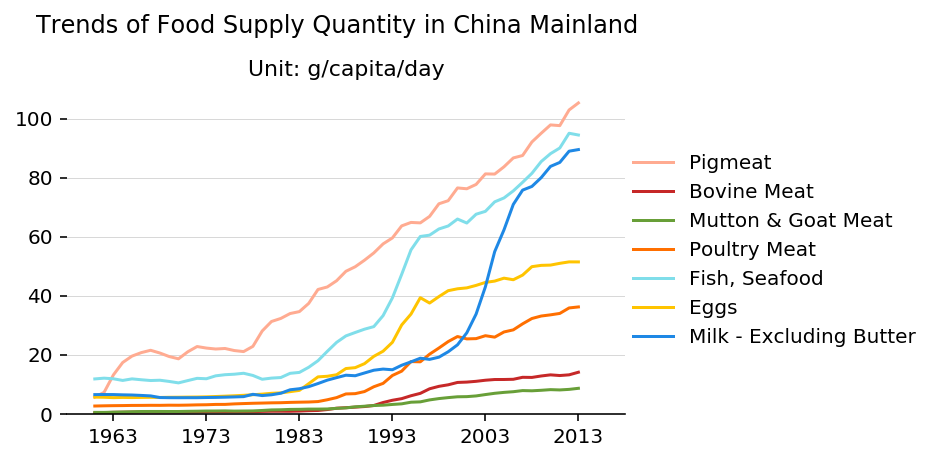

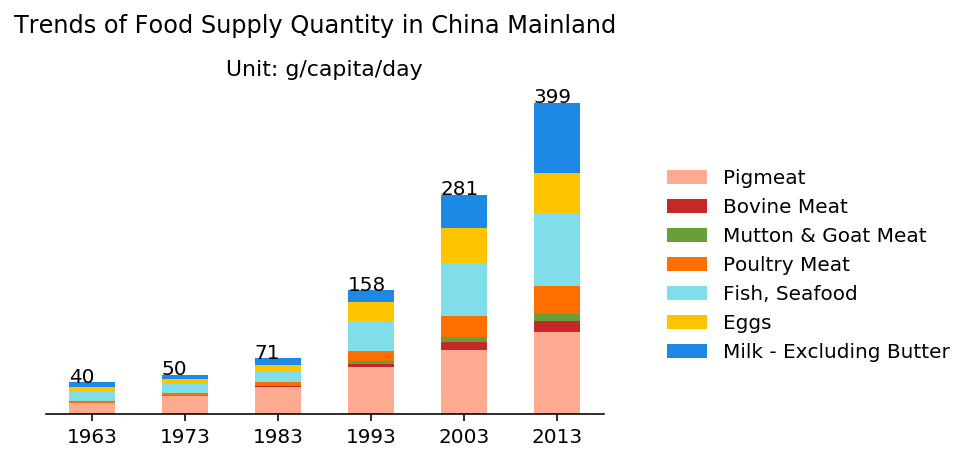

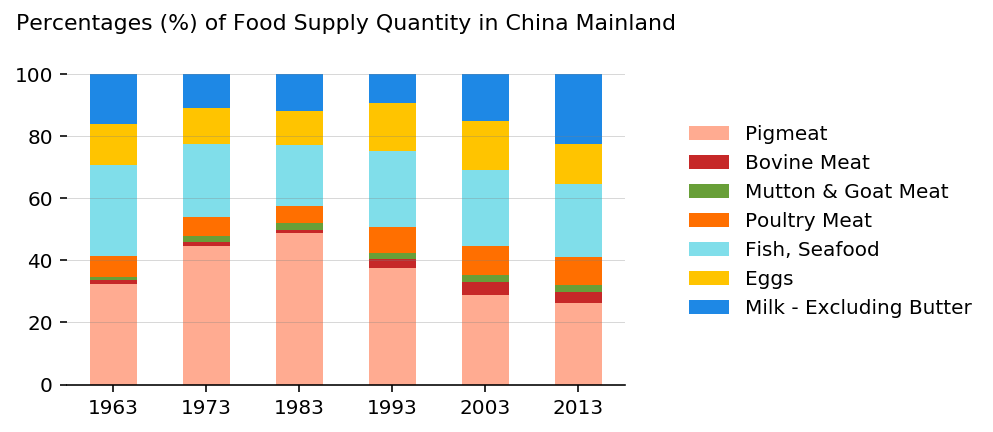

In [28]:
# 所有主要末梢类别, 加上末梢不重要但总类重要的总类
plotTrendsLine(A, E, toUnit='g/capita/day')
plotTrendsBar(A, E, toUnit='g/capita/day')

# # 设置颜色
# cmeat,cfish,cegg,cmilk,coffal,cfat=\
# 'peru','deepskyblue','yellowgreen','darkgray','firebrick','orange'
# cpig,ccattle,cgoat,cbirds,cother=\
# 'hotpink','maroon','orangered','gold','lightslategray'

# # 重要总类的分类
# plotTrends(D, A, E, items_group='Animal Products', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cmeat,cfish,cegg,cmilk,coffal,cfat],
#           )
# plotTrends(D, A, E, items_group='Meat', 
#            toUnit='10,000 t', changeUnit = 1/10000,
#            colors=[cpig,ccattle,cgoat,cbirds,cother],
#           )

### 2. An Area's World Ranking of Some Items

In [29]:
def ranking_AreaItemInWorld(
    area,
    element,
    items_group='',
    items=[],
    area_list=LIST_countries,
    fig_size=FIG_size,
    colors=CLs,
):  
    
    items = getItems(element=element, items_group=items_group, items=items)
    
    # make a pivot for a particular area where 
    # year, items as columns, items' rankings in areas list as values
    rankings = {}
    for i in items:
        if i in PVs_AreaYear[element].keys():
            df = PVs_AreaYear[element][i].copy()
            ranks = np.array([])
            try: 
                df_areas = df[df.index.isin(area_list)]
                for year in df_areas.columns:
                    rank = df_areas.sort_values(year, ascending=False).index.tolist().index(area)+1
                    ranks = np.append(ranks,rank)
                rankings[i]=ranks
            except:continue           
    df_rank = pd.DataFrame(rankings)
    df_rank.index = Years
    
    # plot settings
    X_step=10
    X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)
    
    title_y=1.15
    
    # === ploting ===
    title = f"Changes in World Rankings of {' '.join(area.split(', ')).title()} Per Capita {element[: element.find('(')].title()}"
    fig = plt.figure(figsize = fig_size, dpi=DPI)
    plt.title(title, fontsize=TIT_size, y=title_y)

    df_ = df_rank.loc[X_ticks]      
    display(df_)
    df_.plot.line(color=colors, linestyle=':', marker='o', linewidth=2, alpha=1, ax=plt.gca())

    ax = plt.gca()
    ax.legend(labels=rankings.keys(),fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax = plt.gca().invert_yaxis()
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/Capita_{''.join(element.split('/'))}_02_{title}.png"
    bbox = matplotlib.transforms.Bbox([[-1, 0], [fig_size[0]+2.5, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1963     47.0        133.0               116.0          89.0           85.0   
1973     37.0        133.0               108.0         107.0           96.0   
1983     33.0        133.0                94.0         107.0           96.0   
1993     30.0        148.0                79.0          94.0           51.0   
2003     24.0        124.0                53.0          87.0           29.0   
2013     13.0        109.0                46.0          90.0           15.0   

      Eggs  Milk - Excluding Butter  
1963  64.0                    130.0  
1973  74.0                    131.0  
1983  76.0                    130.0  
1993  41.0                    147.0  
2003   5.0                    133.0  
2013   3.0                    115.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_02_Changes in World Rankings of China Mainland Per Capita Food Supply Quantity .png


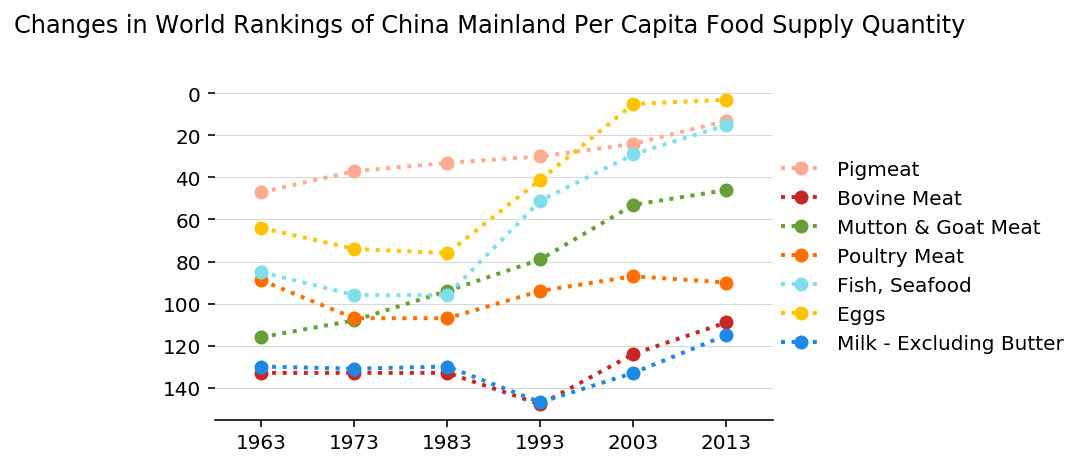

In [30]:
ranking_AreaItemInWorld(A,E)

### 3. Compare

#### World Map

In [31]:
# Map

countries = list(set(LIST_countries_OECD+LIST_countries_EU+LIST_countries_G20+LIST_countries_BRICS))
print(f'OECD, EU, G20 and BRICS are considered. {len(countries)} in total.')
print(countries)

# countries = list(set(LIST_countries_OECD)) + China
# print(f'OECD and China are considered. {len(countries)} in total.')
# display(countries)

def worldMap(
    element,
    items_group='',
    items=[],
    toUnit = '',
    changeUnit = 1,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='YlOrBr',
):
    items = items = getItems(element=E, items_group=items_group, items=items)

    df_all = {}
    for i in items:
        df = PVs_AreaYear[E][i].copy()
        df = df[df.index.isin(countries)]
        df_all[i] = pd.DataFrame()
        for y in years:
            df_y = df[[y]].dropna()
            df_y = df_y * changeUnit
            df_all[i] = pd.concat([df_all[i], df_y], sort=True, axis=1)       

            title = f"{element[: element.find('(')].title()}({''.join(i.split('- '))}, {y}, {toUnit})"
            cn_map = folium.Map(width=1600, height=800, location=[0, 0], zoom_start=2, tiles='Mapbox Bright')
            threshold_scale = np.around(np.linspace(
                0, 
                df_y[y].values.max()+df_y[y].values.max()/20, 
                num=6, endpoint=True
            ),3)

            if y < 1992: geo_data_=f'{FAO_meta}/geojson/world_countries_before1992.json'
            elif y >= 1992: geo_data_=f'{FAO_meta}/geojson/world_countries.json'

            folium.Choropleth(
                geo_data=geo_data_,
                data=df_y,
                name = y,
                columns=[df_y.index, y],
                key_on='feature.properties.name',
                threshold_scale=threshold_scale,
                nan_fill_color='gray',
                fill_color=fill_color_,
                fill_opacity=1, 
                line_opacity=0.2,
                legend_name=title,
                show=False,
                highlight=False,
                reset=False
            ).add_to(cn_map)


    #         display(cn_map) 

            path = f"{LOCAL_ROOT}/results/{Domain_folder}/map/Capita_{''.join(element.split('/'))}_03_01_{title[: title.find('(')]}_{''.join(i.split('- '))}_{y}.html"
            cn_map.save(path)
            print('Atala saved as: ' + path)

    for i in items:
        display(df_all[i].head())

OECD, EU, G20 and BRICS are considered. 52 in total.
['India', 'Cyprus', 'Slovenia', 'Norway', 'Denmark', 'Russian Federation', 'Portugal', 'Germany', 'Sweden', 'United Kingdom', 'Czechia', 'Canada', 'Chile', 'Republic of Korea', 'Turkey', 'China, Hong Kong SAR', 'Indonesia', 'New Zealand', 'France', 'Croatia', 'Saudi Arabia', 'Slovakia', 'Israel', 'Poland', 'Belgium', 'United States of America', 'Netherlands', 'China, mainland', 'Austria', 'Romania', 'Australia', 'Greece', 'Hungary', 'Latvia', 'Lithuania', 'Mexico', 'Bulgaria', 'South Africa', 'Switzerland', 'Iceland', 'Italy', 'Ireland', 'Spain', 'Argentina', 'Luxembourg', 'Japan', 'Malta', 'China, Macao SAR', 'Brazil', 'China, Taiwan Province of', 'Finland', 'Estonia']


In [32]:
worldMap(
    element = E,
    toUnit = 'g/papita/day',
    changeUnit = 1,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='YlOrBr',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply quantity (gcapitaday)_03_01_Food Supply Quantity _Pigmeat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply quantity (gcapitaday)_03_01_Food Supply Quantity _Pigmeat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply quantity (gcapitaday)_03_01_Food Supply Quantity _Pigmeat_2013.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply quantity (gcapitaday)_03_01_Food Supply Quantity _Bovine Meat_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply quantity (gcapitaday)_03_01_Food Supply Quantity _Bovine Meat_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/mea

1973    1993    2013
Argentina   26.90   20.89   28.78
Australia   43.39   50.38   66.14
Austria    131.74  180.07  144.00
Belgium       NaN     NaN  105.89
Brazil      18.27   25.34   34.53

1973    1993    2013
Argentina  175.21  177.49  152.01
Australia  131.84  115.11   92.76
Austria     62.16   63.29   46.95
Belgium       NaN     NaN   42.81
Brazil      53.53   76.67  107.52

1973   1993   2013
Argentina  12.42   5.83   4.27
Australia  91.92  56.58  27.05
Austria     0.77   3.01   3.19
Belgium      NaN    NaN   3.60
Brazil      1.54   2.14   1.70

1973   1993    2013
Argentina  22.48  61.53  105.92
Australia  31.72  70.54  126.37
Austria    25.96  41.21   50.98
Belgium      NaN    NaN   33.42
Brazil     13.92  47.18  123.29

1973   1993   2013
Argentina  15.18  25.43  19.32
Australia  36.02  55.07  71.49
Austria    21.91  27.20  38.03
Belgium      NaN    NaN  68.57
Brazil     22.67  14.59  29.78

1973   1993   2013
Argentina  18.62  18.69  31.20
Australia  30.55  18.33  23.30
Austria    37.64  36.75  40.21
Belgium      NaN    NaN  34.50
Brazil      9.40  20.16  24.60

1973    1993    2013
Argentina  465.87  547.22  534.46
Australia  679.27  652.14  642.45
Austria    597.32  743.76  707.09
Belgium       NaN     NaN  647.08
Brazil     174.03  256.30  408.99

#### Compare with Other Areas

In [33]:
items = ITEMs.copy()
X_step=10
X_ticks=range(Years[-1]-50,Years[-1]+X_step,X_step)

In [34]:
def capitaOfGroup (
    element,
    element_total,
    areas_list,
    items_group='',
    items=[],
):
    items = getItems(element=element, items_group=items_group, items=items)
    
    # Population (1000 persons)
    try:
        population = rdDF('Population')
    except:
        with ZipFile(FAO_BULK_zip, 'r') as zf1:
            zf1.extract(f'Population{SUFFIX}.zip', DATA_FAO)
        population = rdDF('Population')
    
    pivots_pop = mkPVs_forItem_AreaYear(element='Total Population - Both sexes', df=population, items=['Population - Est. & Proj.'])

    population = list(pivots_pop.values())[0]
    population = population[Years].copy()
    population = population[population.index.isin(areas_list)]
    population.loc['Sum'] = population.apply(lambda x: x.sum(), axis=0)
    display(population[population.index=='Sum'])
    
    # Total (tonnes)
    element_total = 'Food supply quantity (tonnes)'
    data = DATA.copy()
    data = DATA[(DATA['Element']==element_total) & (DATA['Item'].isin(items)) & (DATA['Area'].isin(areas_list))]
    
    pivots = mkPVs_forItem_AreaYear(element=element_total, df=data, items=items)
    
    # To Capita (kg/capita/year)
    df_res = pd.DataFrame()
    for i, df in pivots.items():
        pivots[i] = pivots[i][Years].copy()
        pivots[i].loc['Sum'] = pivots[i].apply(lambda x: x.sum(), axis=0)
        capita = np.array(pivots[i][pivots[i].index=='Sum'])/np.array(population[population.index=='Sum'])
        capita = pd.DataFrame(data=capita)
        capita.columns = Years
        capita.index = [i]
        df_res = pd.concat([df_res, capita])
        
    df_res = df_res.transpose()
        
    return df_res

{'DatasetCode': 'OA',
 'DatasetName': 'Population: Annual population',
 'Topic': 'Demography',
 'DatasetDescription': 'The FAOSTAT Population module contains time series data on population, by sex and urban/rural. The series consist of both estimates and projections for different periods as available from the original sources, namely:1. Population data refers to the World Population Prospects: The 2019 Revision from the UN Population Division.2. Urban/rural population data refers to the World Urbanization Prospects: The 2018 Revision from the UN Population Division./',
 'MedaData': ['Piero Conforti',
  'Piero.Conforti@fao.org',
  '2019-10-21',
  'zip',
  'csv',
  '1475KB',
  '160411'],
 'Url_Normalized': 'http://fenixservices.fao.org/faostat/static/bulkdownloads/Population_E_All_Data_(Normalized).zip'}

Area Code         Area  Item Code                       Item  Element Code  \
0          2  Afghanistan       3010  Population - Est. & Proj.           511   
1          2  Afghanistan       3010  Population - Est. & Proj.           511   
2          2  Afghanistan       3010  Population - Est. & Proj.           511   
3          2  Afghanistan       3010  Population - Est. & Proj.           511   
4          2  Afghanistan       3010  Population - Est. & Proj.           511   

                         Element  Year Code  Year          Unit     Value  \
0  Total Population - Both sexes       1950  1950  1000 persons  7752.118   
1  Total Population - Both sexes       1951  1951  1000 persons  7840.156   
2  Total Population - Both sexes       1952  1952  1000 persons  7935.997   
3  Total Population - Both sexes       1953  1953  1000 persons  8039.694   
4  Total Population - Both sexes       1954  1954  1000 persons  8151.317   

  Flag  Note  
0    X   NaN  
1    X   NaN  
2    X   NaN  
3    X   NaN  
4    X   NaN

Area Code                                     Area  Item Code  \
160406       5817  Net Food Importing Developing Countries       3010   
160407       5817  Net Food Importing Developing Countries       3010   
160408       5817  Net Food Importing Developing Countries       3010   
160409       5817  Net Food Importing Developing Countries       3010   
160410       5817  Net Food Importing Developing Countries       3010   

                             Item  Element Code           Element  Year Code  \
160406  Population - Est. & Proj.           561  Urban population       2046   
160407  Population - Est. & Proj.           561  Urban population       2047   
160408  Population - Est. & Proj.           561  Urban population       2048   
160409  Population - Est. & Proj.           561  Urban population       2049   
160410  Population - Est. & Proj.           561  Urban population       2050   

        Year          Unit       Value Flag  Note  
160406  2046  1000 persons  1.3832e+06    A   NaN  
160407  2047  1000 persons  1.4181e+06    A   NaN  
160408  2048  1000 persons  1.4533e+06    A   NaN  
160409  2049  1000 persons  1.4889e+06    A   NaN  
160410  2050  1000 persons  1.5248e+06    A   NaN

1961        1962        1963        1964        1965        1966  \
Area                                                                           
Sum   777100.747  787508.647  797908.934  808202.134  818318.212  828205.308   

            1967        1968        1969        1970        1971        1972  \
Area                                                                           
Sum   837877.277  847410.635  856921.163  866485.985  876136.426  885826.263   

            1973        1974        1975        1976        1977        1978  \
Area                                                                           
Sum   895462.628  904913.977  914088.281  922956.141  931554.618  939940.259   

            1979        1980        1981        1982        1983        1984  \
Area                                                                           
Sum   948199.177  956397.837  964559.329  972676.565  980751.353  988777.378   

            1985        1986        1987        1988        1989        1990  \
Area                                                                           
Sum   996755.427  1.0047e+06  1.0126e+06  1.0205e+06  1.0285e+06  1.0367e+06   

            1991        1992        1993        1994        1995        1996  \
Area                                                                           
Sum   1.0450e+06  1.0632e+06  1.0874e+06  1.0958e+06  1.1041e+06  1.1123e+06   

            1997        1998        1999        2000        2001        2002  \
Area                                                                           
Sum   1.1204e+06  1.1284e+06  1.1365e+06  1.1553e+06  1.1635e+06  1.1717e+06   

            2003        2004        2005        2006        2007        2008  \
Area                                                                           
Sum   1.1800e+06  1.1885e+06  1.1970e+06  1.2057e+06  1.2146e+06  1.2234e+06   

            2009        2010        2011        2012        2013  
Area                                                              
Sum   1.2322e+06  1.2407e+06  1.2490e+06  1.2571e+06  1.2649e+06

World: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961    21.97        25.70                5.26          7.88          24.68   
1962    22.70        26.58                5.26          8.07          25.25   
1963    24.04        27.32                5.17          8.31          26.05   
1964    24.02        27.29                5.06          8.50          26.35   
1965    25.55        27.34                4.98          9.02          27.37   

       Eggs  Milk - Excluding Butter  
1961  12.47                   206.99  
1962  12.54                   205.45  
1963  12.44                   208.48  
1964  12.73                   206.54  
1965  12.82                   202.12

OECD: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961  19.7692      20.9997              3.2553        7.3555        17.8153   
1962  20.1556      21.7839              3.2101        7.5904        17.9388   
1963  20.2107      22.7229              3.1315        7.8946        18.4130   
1964  20.6592      23.3618              3.0643        8.3193        18.0144   
1965  20.4359      23.0953              2.9829        8.8442        18.8932   

         Eggs  Milk - Excluding Butter  
1961  11.2788                 174.3360  
1962  11.4644                 172.7996  
1963  11.5471                 175.5718  
1964  12.0206                 175.3903  
1965  12.0312                 174.8007

China, mainland: 


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1961     5.59         0.25                0.41          2.57          11.75   
1962     7.21         0.33                0.41          2.64          12.01   
1963    13.11         0.43                0.48          2.69          11.80   
1964    17.32         0.47                0.55          2.72          11.24   
1965    19.49         0.52                0.62          2.77          11.77   

      Eggs  Milk - Excluding Butter  
1961  5.58                     6.44  
1962  5.53                     6.46  
1963  5.41                     6.45  
1964  5.48                     6.36  
1965  5.44                     6.30

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_03_02_Compare Per Capita Food Supply Quantity of Pigmeat of China Mainland with Other Areas.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_03_02_Compare Per Capita Food Supply Quantity of Bovine Meat of China Mainland with Other Areas.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_03_02_Compare Per Capita Food Supply Quantity of Mutton & Goat Meat of China Mainland with Other Areas.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_03_02_Compare Per Capita Food Supply Quantity of Poultry Meat of China Mainland with Other Areas.png
Img saved as: /mnt/sda2/_hub/project

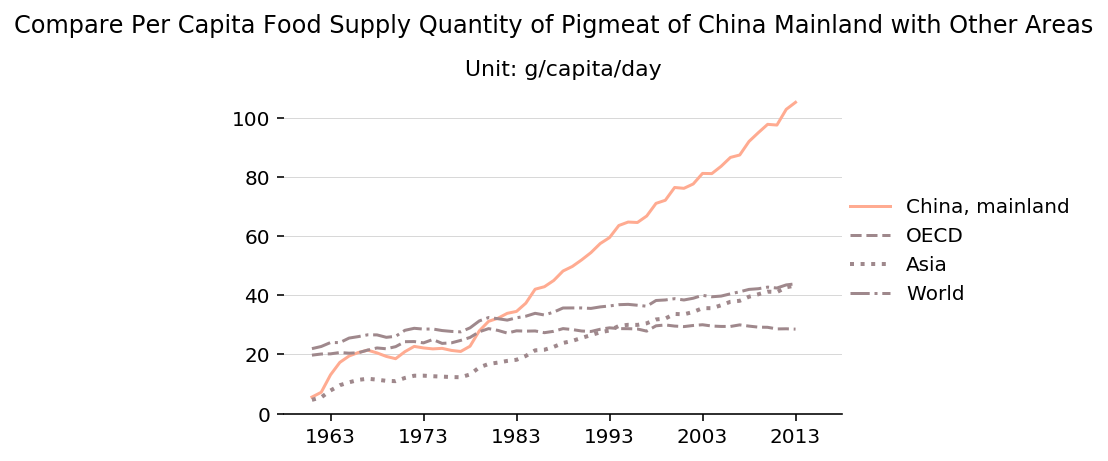

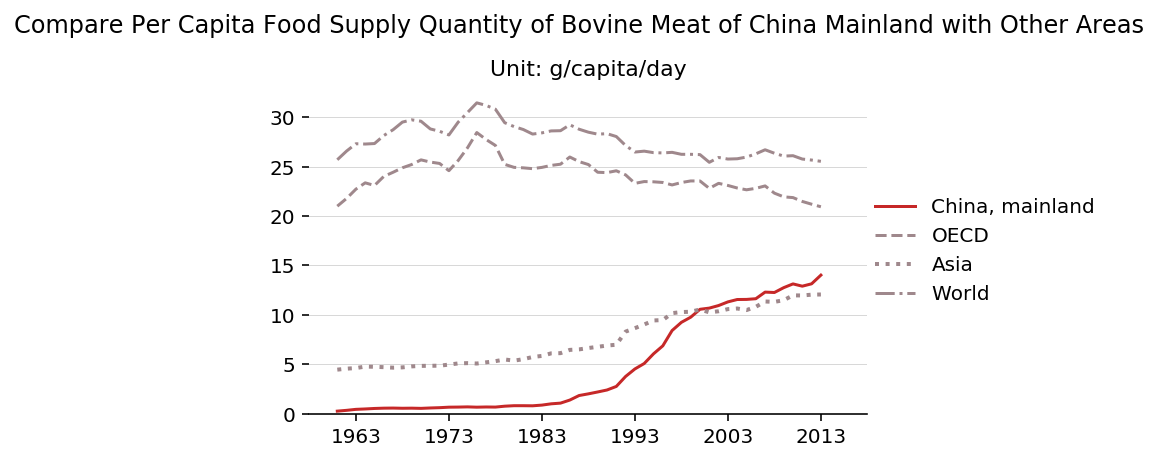

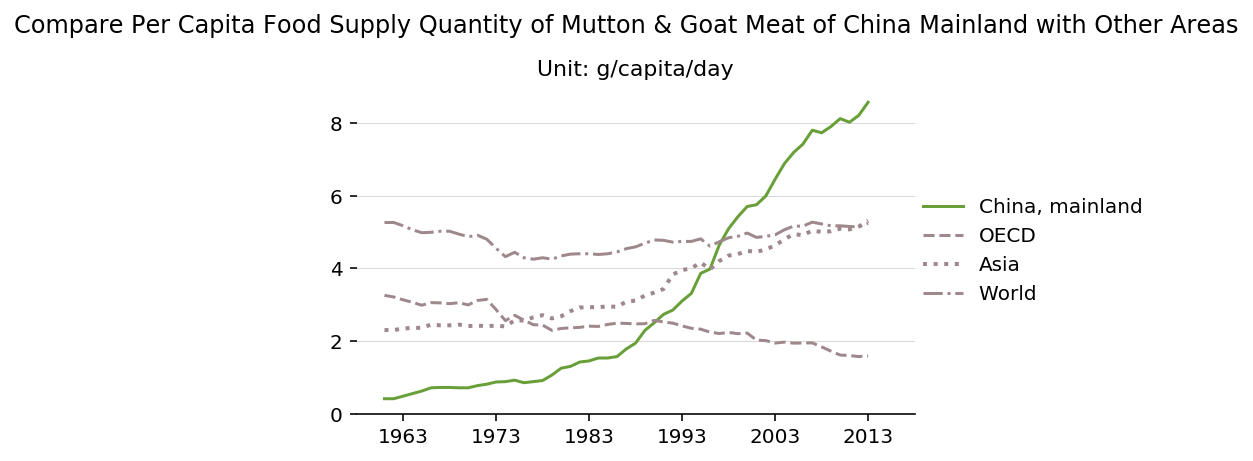

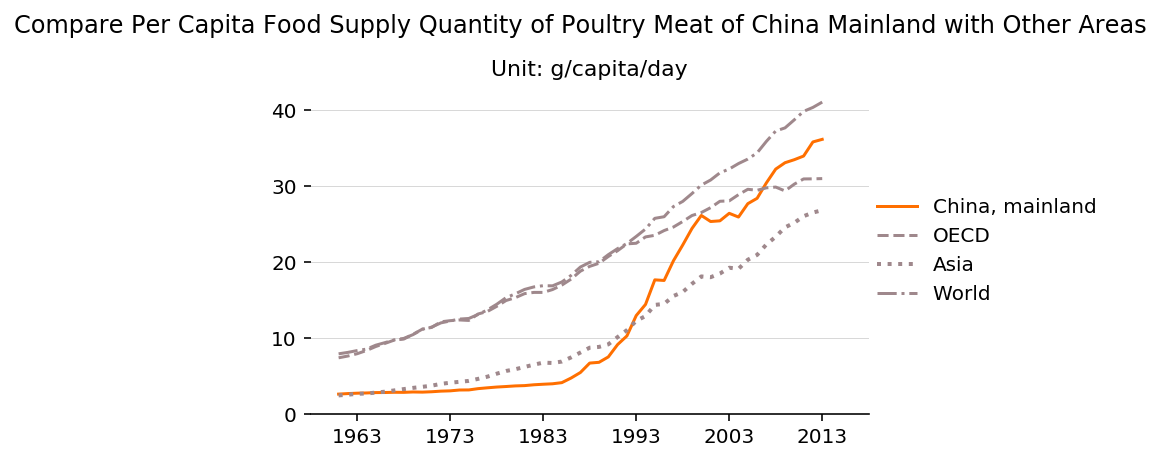

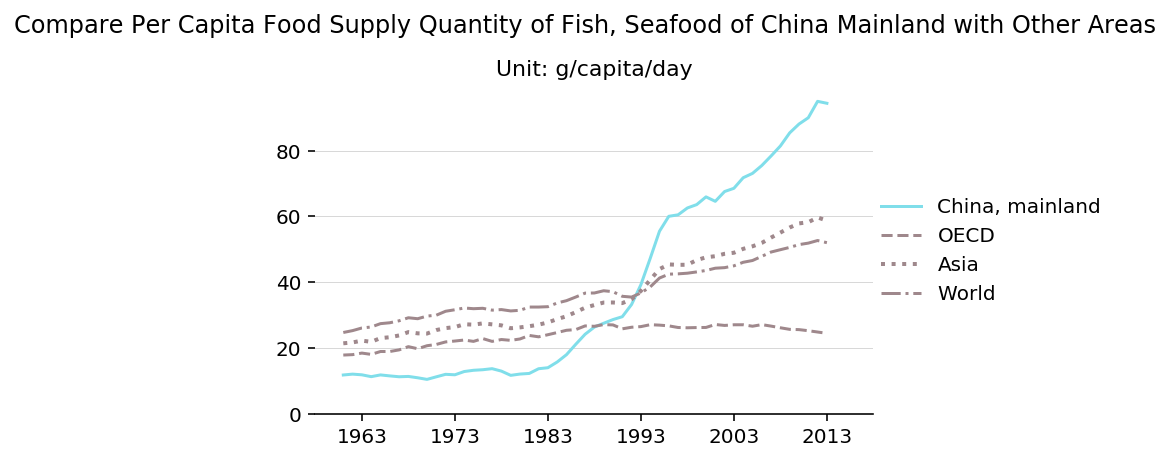

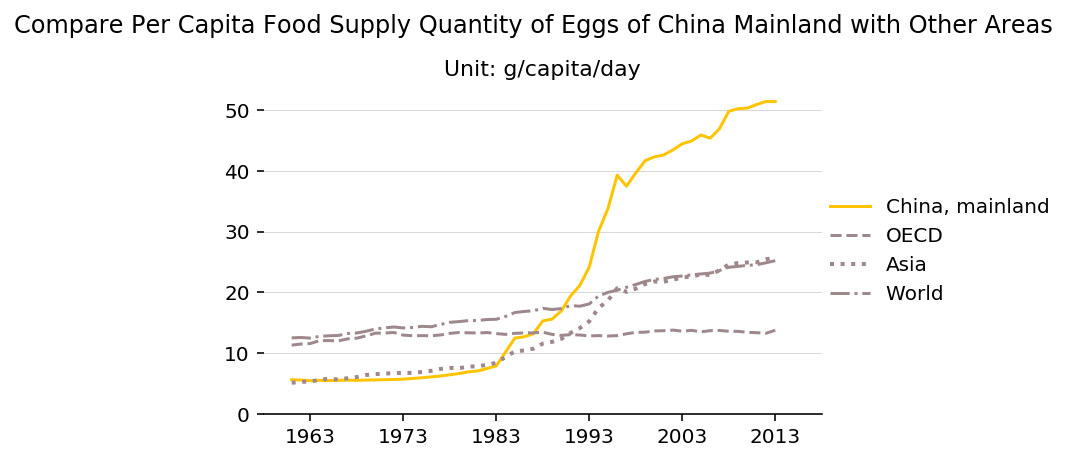

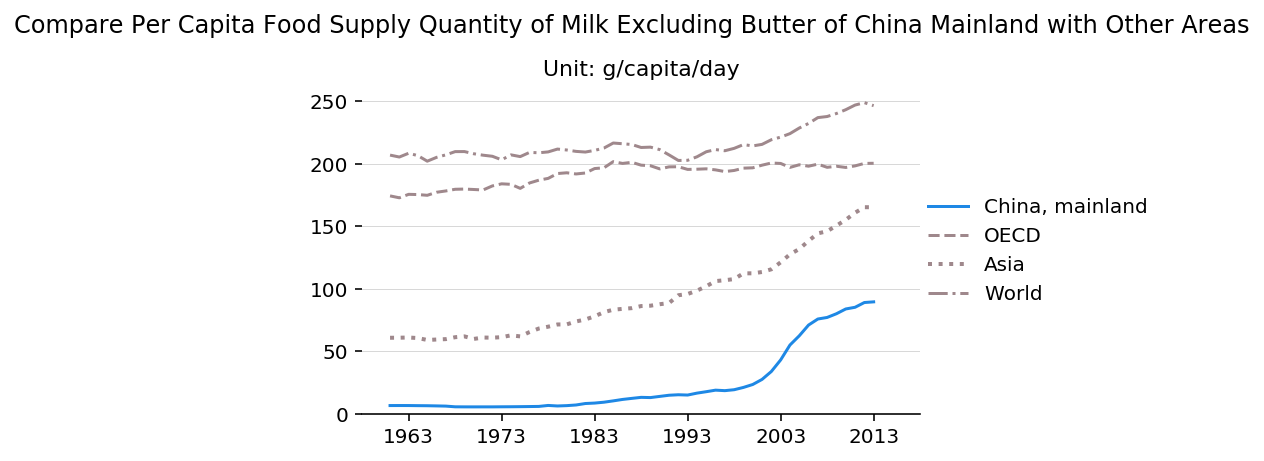

In [35]:
DATA_OECD = capitaOfGroup(E, element_total = 'Food supply quantity (tonnes)', areas_list=LIST_countries_OECD, items=items)
DATA_area = trendsOfArea(A, E, items=items)
DATA_world = trendsOfArea('World', E, items=items)
DATA_asia = trendsOfArea('Asia', E, items=items)

element=E
toUnit='g/capita/day'
changeUnit=1
area = A
colors = CLs
fig_size = FIG_size

df_world = DATA_world.copy() * changeUnit
df_OECD = DATA_OECD.copy() * changeUnit
df_area = DATA_area.copy() * changeUnit
df_asia = DATA_asia.copy() * changeUnit

print('World: ')
display(df_world.head())
print('OECD: ')
display(df_OECD.head())
print(f'{A}: ')
display(df_area.head())

# ==== Line

for i, c in zip(items, colors):
    
    title = f"Compare Per Capita {element[: element.find('(')].title()}of {''.join(i.split('- '))} of {' '.join(area.split(', ')).title()} with Other Areas"
    sub_title = f"Unit: {toUnit}"
    fig = plt.figure(figsize = fig_size,dpi=DPI)
    plt.suptitle(title, fontsize=TIT_size, y=1.05)
    plt.title(sub_title, fontsize=TIT_size-1)
    
    df_area[i].plot(color=c, ax=plt.gca())
    df_OECD[i].plot(color=GF_brand_gray, linestyle='--' ,ax=plt.gca())
    df_asia[i].plot(color=GF_brand_gray, linestyle=':', linewidth=2, ax=plt.gca())
    df_world[i].plot(color=GF_brand_gray, linestyle='-.', ax=plt.gca())
    
    ax = plt.gca()
    ax.legend(labels=[area, 'OECD', 'Asia', 'World'],fontsize=LEG_size,frameon=False,
             loc='center left',bbox_to_anchor=(1.0,0.5),borderaxespad = 0.)
    ax.xaxis.label.set_visible(False)
    ax.set_xticks(X_ticks)
    ax.set_xlim(X_ticks[0]-X_step/2, X_ticks[-1]+X_step/2)
    ax.yaxis.grid(True, linewidth=0.5, color='gray', alpha=0.3)
    ax.set_ylim(0,)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    path = f"{LOCAL_ROOT}/results/{Domain_folder}/img/Capita_{''.join(element.split('/'))}_03_02_{title}.png"
    bbox = matplotlib.transforms.Bbox([[-1.8, 0], [fig_size[0]+2.5, fig_size[1]+0.6]])
    fig.savefig(path, format='png', transparent=False, dpi=DPI, bbox_inches =bbox)
    print('Img saved as: ' + path)

### Other Regions Trends

World


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973    28.58        28.21                4.55         12.21          31.60   
1983    32.41        28.42                4.40         16.86          32.53   
1993    36.41        26.48                4.74         23.35          36.72   
2003    40.01        25.77                4.92         32.24          44.96   
2013    43.89        25.54                5.24         41.06          52.01   

       Eggs  Milk - Excluding Butter     Sum  
1973  14.11                   203.22  322.48  
1983  15.54                   210.77  340.93  
1993  18.07                   202.83  348.60  
2003  22.67                   221.39  391.96  
2013  25.19                   246.57  439.50

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in World_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in World.png
Northern America


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973    75.77       134.21                3.25         58.81          42.84   
1983    81.71       130.69                2.05         77.03          48.51   
1993    81.94       112.51                1.83        114.25          62.76   
2003    81.76       113.32                1.61        132.44          65.94   
2013    74.42        97.66                1.33        133.39          59.21   

       Eggs  Milk - Excluding Butter      Sum  
1973  43.93                   672.67  1031.48  
1983  40.59                   669.43  1050.01  
1993  35.97                   686.39  1095.65  
2003  39.31                   697.55  1131.93  
2013  39.51                   679.54  1085.06

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in Northern America_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in Northern America.png
Western Europe


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973   112.70        67.89                3.84         28.54          41.73   
1983   135.58        69.43                5.34         32.93          45.76   
1993   132.09        58.89                5.92         42.41          52.02   
2003   124.07        48.75                4.98         47.86          58.46   
2013   116.64        48.84                4.61         53.95          58.78   

        Eggs  Milk - Excluding Butter       Sum  
1973  39.345                  595.165   889.210  
1983  42.230                  700.265  1031.535  
1993  35.330                  688.810  1015.470  
2003  36.410                  732.520  1053.050  
2013  34.910                  715.850  1033.580

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in Western Europe_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in Western Europe.png
Australia & New Zealand


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973    41.45       132.28               96.28         29.30          37.47   
1983    40.83       128.11               59.93         50.69          41.76   
1993    48.50       113.17               61.32         68.16          54.95   
2003    56.42       115.49               41.61         95.42          68.49   
2013    65.32        87.72               31.06        121.43          70.97   

       Eggs  Milk - Excluding Butter      Sum  
1973  33.79                   679.92  1050.49  
1983  33.71                   639.87   994.90  
1993  23.15                   619.34   988.59  
2003  15.88                   522.38   915.69  
2013  23.93                   599.34   999.77

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in Australia & New Zealand_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in Australia & New Zealand.png
South-Eastern Asia


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973    10.67         7.57                0.57          6.56          45.65   
1983    12.59         7.00                0.87         10.29          49.86   
1993    19.55         7.98                0.95         16.77          55.74   
2003    25.90         7.64                1.09         22.12          70.43   
2013    34.16        11.11                1.18         33.80          90.41   

       Eggs  Milk - Excluding Butter     Sum  
1973   6.31                    20.74   98.07  
1983   8.19                    27.70  116.50  
1993   9.67                    29.43  140.09  
2003  12.05                    38.90  178.13  
2013  16.41                    50.27  237.34

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in South-Eastern Asia_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in South-Eastern Asia.png
Japan


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973    27.61        10.11                3.33         17.63         179.31   
1983    36.33        15.43                1.87         30.37         183.91   
1993    42.09        27.75                1.23         37.97         185.64   
2003    52.41        26.32                0.48         43.62         179.72   
2013    56.49        25.07                0.39         53.20         133.15   

       Eggs  Milk - Excluding Butter     Sum  
1973  44.64                   144.74  427.37  
1983  45.86                   193.36  507.13  
1993  55.39                   223.32  573.39  
2003  53.03                   216.90  572.48  
2013  52.46                   197.43  518.19

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in Japan_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in Japan.png
Republic of Korea


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973     7.01         3.91                0.38          4.40          94.48   
1983    25.72        11.78                0.43          8.52         122.58   
1993    47.50        21.62                0.72         24.49         137.30   
2003    75.92        37.81                0.33         30.75         144.27   
2013    89.75        39.81                0.37         43.84         144.61   

       Eggs  Milk - Excluding Butter     Sum  
1973  11.38                     8.24  129.80  
1983  19.39                    35.53  223.95  
1993  25.27                    60.14  317.04  
2003  29.25                    72.81  391.14  
2013  30.79                    79.58  428.75

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_02_Trends of Food Supply Quantity in Republic Of Korea_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply quantity (gcapitaday)_01_03_Percentages (%) of Food Supply Quantity in Republic Of Korea.png


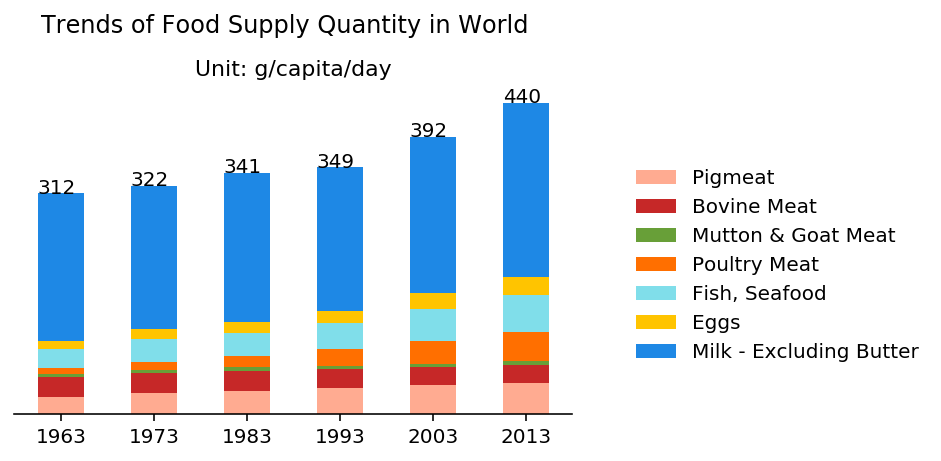

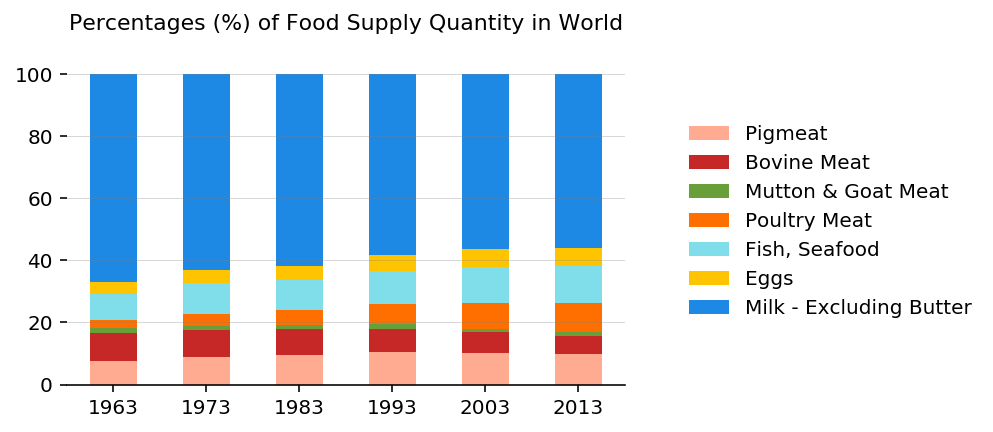

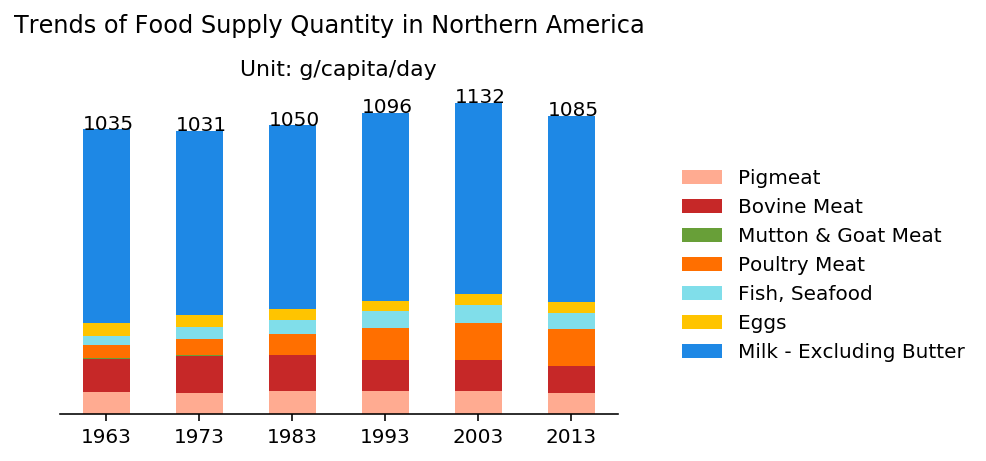

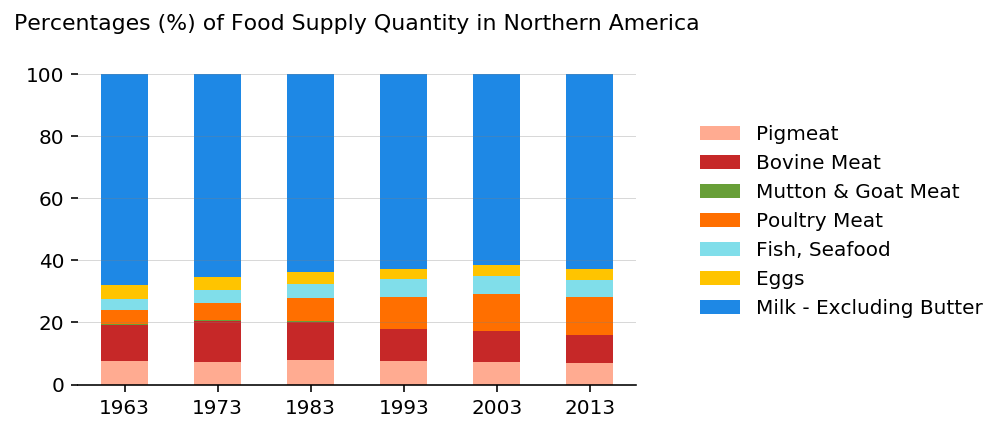

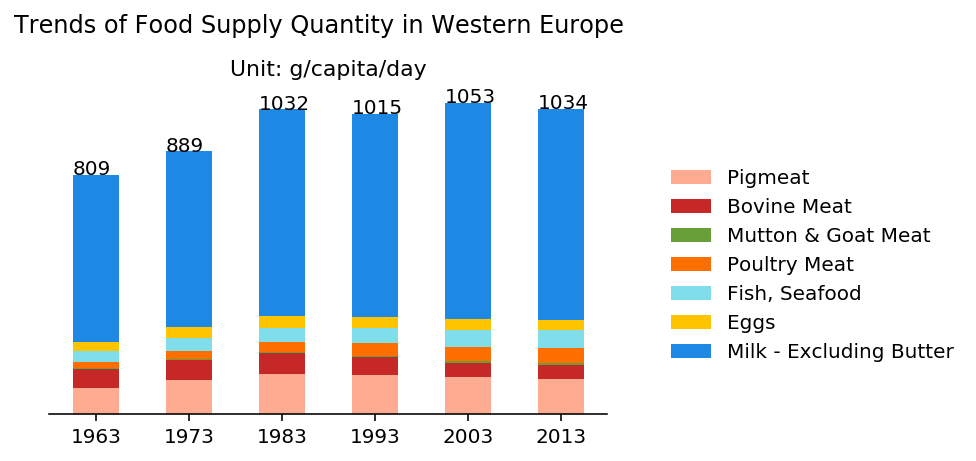

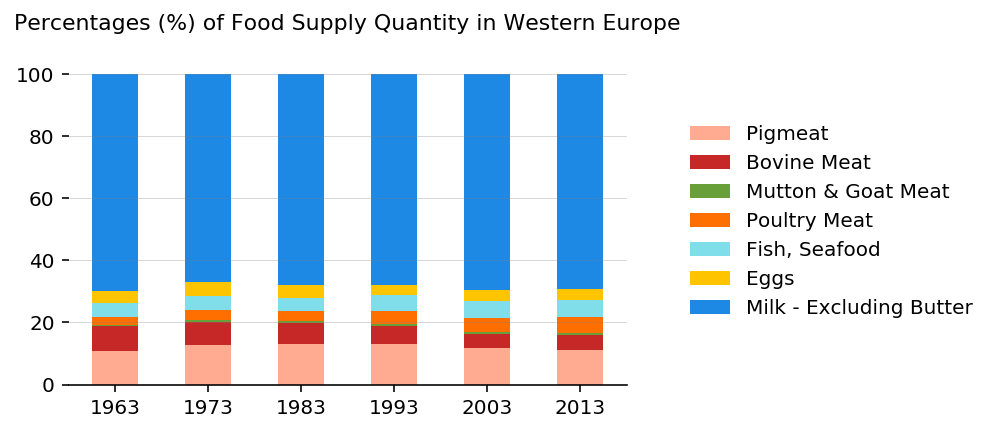

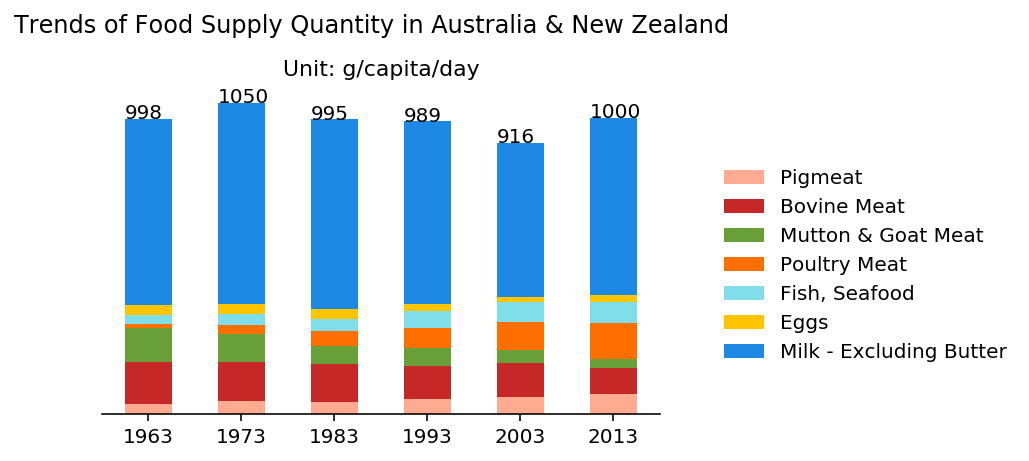

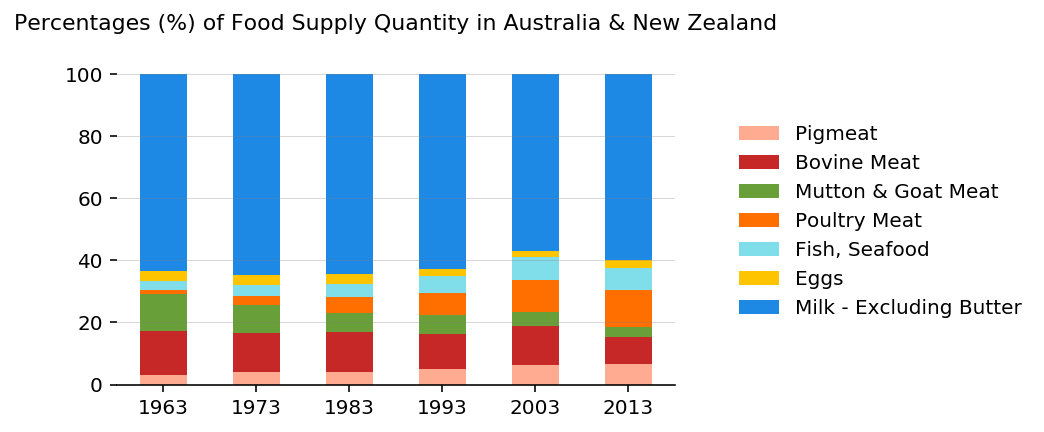

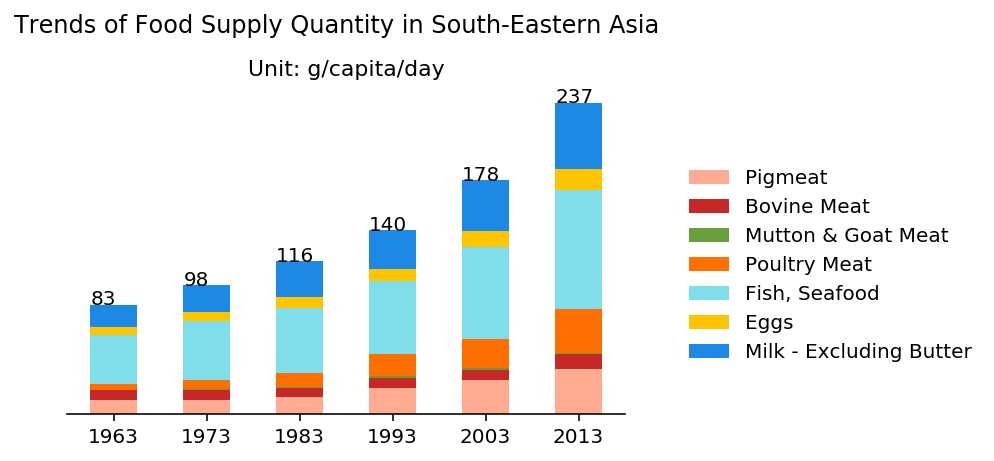

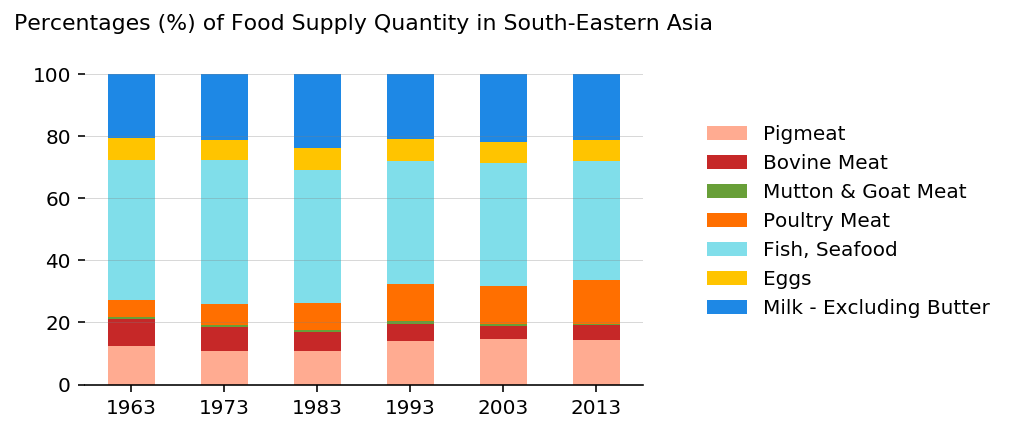

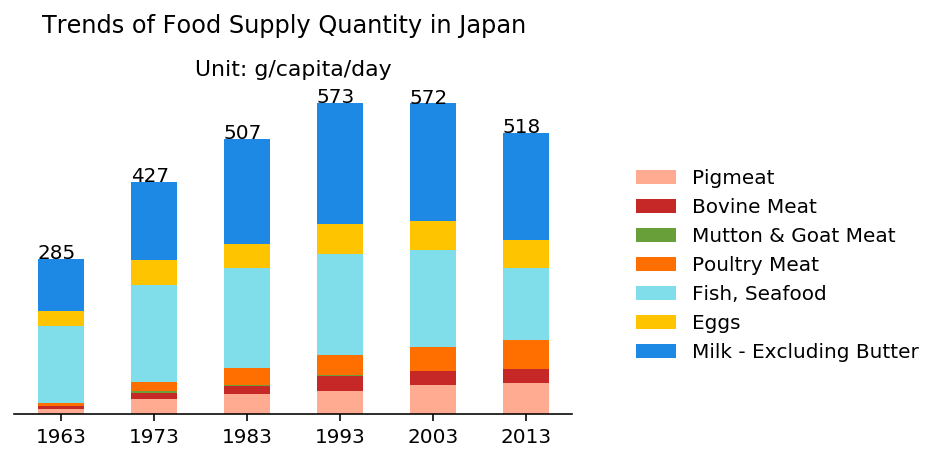

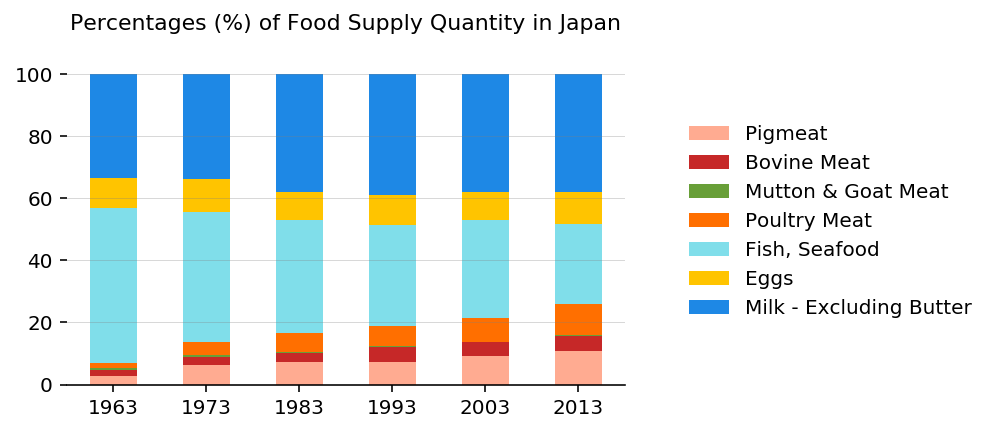

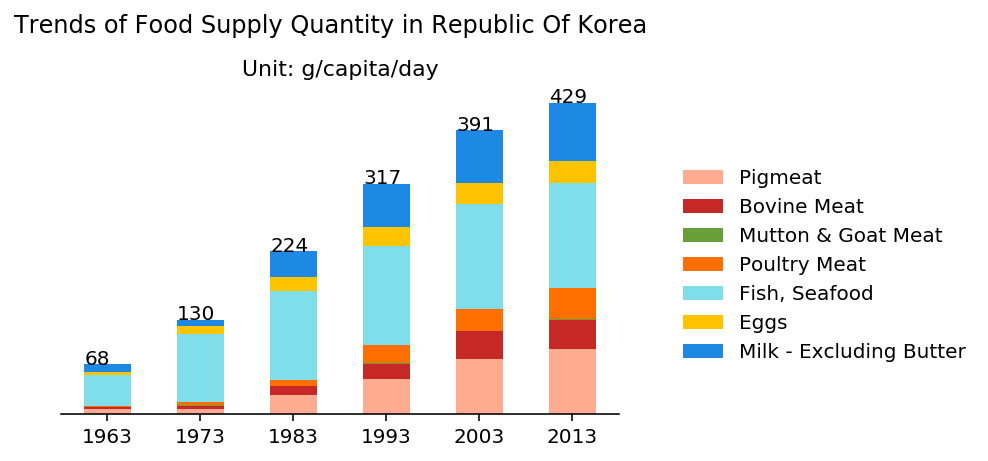

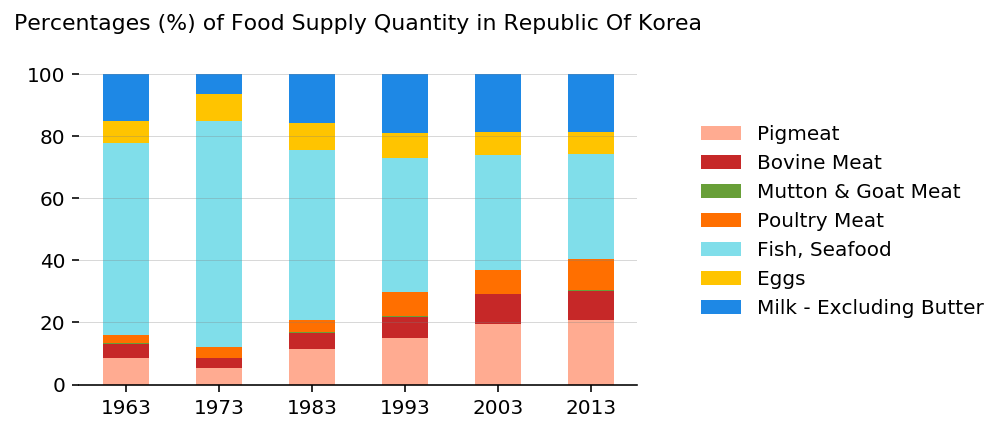

In [36]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea',
]
for a in areas:
    print(a)
    plotTrendsBar(a, E, toUnit='g/capita/day')

## Kcal

In [37]:
# 给 Elements 赋值
E = 'Food supply (kcal/capita/day)'
# 给 Items 赋值
Is = {
    'Grand Total':['Grand Total','Animal Products'],
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [38]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Grand Total', 'Animal Products']

ITEMs_all = getAllItemsInArea(A, E, items_groups=IsGroup)
print(ITEMs_all)

data = DF_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(ITEMs_all))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位

['Fish, Seafood', 'Animal Products', 'Mutton & Goat Meat', 'Bovine Meat', 'Milk - Excluding Butter', 'Eggs', 'Pigmeat', 'Meat', 'Grand Total', 'Animal fats', 'Poultry Meat', 'Offals']


Area Code  Area  Year  \
Element                       Item                                             
Food supply (kcal/capita/day) Animal Products                 53    53    53   
                              Animal fats                     53    53    53   
                              Bovine Meat                     53    53    53   
                              Eggs                            53    53    53   
                              Fish, Seafood                   53    53    53   
                              Grand Total                     53    53    53   
                              Meat                            53    53    53   
                              Milk - Excluding Butter         53    53    53   
                              Mutton & Goat Meat              53    53    53   
                              Offals                          53    53    53   
                              Pigmeat                         53    53    53   
                              Poultry Meat                    53    53    53   

                                                       Unit  Value  
Element                       Item                                  
Food supply (kcal/capita/day) Animal Products            53     53  
                              Animal fats                53     53  
                              Bovine Meat                53     53  
                              Eggs                       53     53  
                              Fish, Seafood              53     53  
                              Grand Total                53     53  
                              Meat                       53     53  
                              Milk - Excluding Butter    53     53  
                              Mutton & Goat Meat         53     53  
                              Offals                     53     53  
                              Pigmeat                    53     53  
                              Poultry Meat               53     53

Area Code  Area  Element  Item  Year  Value
Unit                                                        
kcal/capita/day        636   636      636   636   636    636

In [39]:
PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, items_groups=IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

'Food supply (kcal/capita/day)'

'Fish, Seafood'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Africa        9.0   9.0   9.0  10.0  10.0  11.0  11.0  10.0  10.0  12.0  13.0   
Albania       3.0   3.0   3.0   3.0   4.0   4.0   5.0   5.0   6.0   7.0   7.0   
Algeria       7.0   4.0   3.0   3.0   3.0   3.0   3.0   2.0   3.0   3.0   3.0   
Americas     14.0  15.0  14.0  15.0  15.0  15.0  15.0  15.0  15.0  16.0  16.0   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Africa       13.0  13.0  13.0  14.0  15.0  15.0  16.0  15.0  16.0  17.0  16.0   
Albania       6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   
Algeria       4.0   4.0   5.0   5.0   4.0   5.0   4.0   5.0   5.0   6.0   7.0   
Americas     17.0  18.0  17.0  16.0  18.0  19.0  20.0  21.0  21.0  21.0  20.0   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Africa       15.0  15.0  14.0  15.0  16.0  16.0  15.0  16.0  14.0  15.0  14.0   
Albania       6.0   4.0   7.0   6.0   6.0   6.0   5.0   3.0   1.0   1.0   1.0   
Algeria       7.0   7.0   7.0   8.0  10.0  10.0   9.0   8.0   7.0   8.0   8.0   
Americas     20.0  20.0  21.0  22.0  23.0  21.0  22.0  21.0  20.0  20.0  21.0   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Africa       13.0  14.0  14.0  15.0  15.0  16.0  15.0  16.0  15.0  16.0  17.0   
Albania       1.0   1.0   2.0   2.0   3.0   5.0   6.0   6.0   8.0   7.0   9.0   
Algeria      11.0   9.0   6.0   7.0   7.0   8.0   8.0  10.0  10.0  11.0   9.0   
Americas     21.0  22.0  22.0  22.0  22.0  21.0  21.0  22.0  22.0  23.0  23.0   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Africa       17.0  18.0  19.0  19.0  18.0  19.0  20.0  20.0  20.0  
Albania      10.0   8.0  10.0  11.0  11.0  12.0  12.0   9.0   9.0  
Algeria      10.0  11.0  11.0  10.0  10.0   8.0   8.0   8.0   8.0  
Americas     24.0  24.0  25.0  24.0  24.0  24.0  24.0  24.0  24.0

'Food supply (kcal/capita/day)'

'Animal Products'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  247.0  245.0  260.0  263.0  274.0  292.0  305.0  320.0  311.0   
Africa       156.0  154.0  152.0  154.0  158.0  160.0  161.0  164.0  165.0   
Albania      386.0  380.0  357.0  350.0  366.0  379.0  384.0  381.0  377.0   
Algeria      184.0  157.0  137.0  144.0  153.0  153.0  154.0  167.0  169.0   
Americas     680.0  676.0  676.0  674.0  669.0  672.0  673.0  682.0  663.0   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  278.0  259.0  241.0  255.0  260.0  261.0  279.0  268.0  270.0   
Africa       166.0  166.0  164.0  162.0  162.0  164.0  167.0  174.0  179.0   
Albania      392.0  371.0  337.0  360.0  364.0  359.0  366.0  364.0  378.0   
Algeria      162.0  169.0  181.0  182.0  202.0  208.0  214.0  236.0  237.0   
Americas     661.0  659.0  656.0  634.0  648.0  635.0  652.0  653.0  654.0   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  271.0  277.0  291.0  298.0  307.0  303.0  273.0  228.0  251.0   
Africa       179.0  186.0  192.0  190.0  188.0  180.0  185.0  182.0  181.0   
Albania      382.0  380.0  407.0  391.0  400.0  380.0  375.0  376.0  391.0   
Algeria      234.0  277.0  302.0  306.0  343.0  307.0  350.0  312.0  301.0   
Americas     661.0  678.0  670.0  654.0  659.0  662.0  676.0  672.0  672.0   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  262.0  267.0  308.0  294.0  269.0  264.0  272.0  287.0  300.0   
Africa       182.0  179.0  181.0  175.0  177.0  175.0  172.0  176.0  171.0   
Albania      414.0  422.0  446.0  475.0  530.0  583.0  650.0  736.0  768.0   
Algeria      297.0  305.0  307.0  292.0  300.0  320.0  295.0  280.0  247.0   
Americas     665.0  660.0  653.0  663.0  673.0  676.0  693.0  694.0  688.0   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  315.0  325.0  341.0  275.0  202.0  260.0  238.0  241.0  232.0   
Africa       174.0  176.0  180.0  184.0  184.0  191.0  197.0  199.0  202.0   
Albania      637.0  623.0  660.0  674.0  721.0  763.0  803.0  822.0  845.0   
Algeria      252.0  271.0  270.0  277.0  289.0  295.0  296.0  325.0  326.0   
Americas     693.0  707.0  725.0  733.0  725.0  734.0  733.0  738.0  738.0   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan  204.0  207.0  211.0  211.0  216.0  215.0  217.0  216.0  
Africa       206.0  213.0  214.0  211.0  217.0  220.0  217.0  215.0  
Albania      865.0  862.0  906.0  933.0  949.0  961.0  986.0  987.0  
Algeria      335.0  329.0  324.0  344.0  348.0  387.0  383.0  379.0  
Americas     749.0  753.0  759.0  753.0  758.0  760.0  764.0  769.0

'Food supply (kcal/capita/day)'

'Mutton & Goat Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  55.0  53.0  55.0  57.0  59.0  60.0  65.0  71.0  66.0  65.0  63.0   
Africa       14.0  13.0  13.0  13.0  13.0  14.0  13.0  14.0  14.0  14.0  14.0   
Albania      41.0  40.0  37.0  36.0  35.0  35.0  43.0  37.0  31.0  29.0  29.0   
Algeria      19.0  17.0  15.0  17.0  17.0  16.0  15.0  17.0  18.0  18.0  18.0   
Americas     12.0  12.0  11.0  10.0  10.0  10.0  10.0  10.0   9.0   9.0   9.0   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  51.0  56.0  58.0  61.0  72.0  73.0  74.0  72.0  76.0  80.0  83.0   
Africa       13.0  12.0  11.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0   
Albania      27.0  27.0  26.0  26.0  26.0  24.0  26.0  26.0  25.0  25.0  23.0   
Algeria      19.0  19.0  18.0  18.0  19.0  19.0  19.0  21.0  21.0  22.0  25.0   
Americas      8.0   7.0   7.0   6.0   6.0   6.0   5.0   5.0   5.0   5.0   5.0   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  80.0  77.0  70.0  65.0  70.0  75.0  78.0  78.0  73.0  64.0  58.0   
Africa       12.0  12.0  12.0  11.0  12.0  12.0  12.0  12.0  12.0  12.0  12.0   
Albania      21.0  17.0  17.0  15.0  15.0  17.0  19.0  19.0  19.0  23.0  24.0   
Algeria      25.0  26.0  24.0  24.0  27.0  27.0  30.0  32.0  32.0  33.0  35.0   
Americas      5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  54.0  50.0  52.0  55.0  58.0  62.0  53.0  45.0  32.0  32.0  33.0   
Africa       12.0  13.0  12.0  13.0  13.0  14.0  14.0  14.0  14.0  14.0  14.0   
Albania      29.0  32.0  28.0  26.0  27.0  30.0  32.0  31.0  32.0  33.0  36.0   
Algeria      35.0  35.0  36.0  33.0  33.0  32.0  32.0  31.0  31.0  30.0  33.0   
Americas      5.0   5.0   4.0   4.0   4.0   4.0   4.0   5.0   5.0   4.0   5.0   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  33.0  29.0  24.0  30.0  32.0  35.0  35.0  33.0  31.0  
Africa       14.0  15.0  15.0  15.0  15.0  14.0  15.0  14.0  14.0  
Albania      36.0  37.0  46.0  53.0  59.0  67.0  71.0  84.0  85.0  
Algeria      34.0  33.0  33.0  31.0  32.0  33.0  40.0  41.0  43.0  
Americas      4.0   4.0   5.0   4.0   4.0   4.0   4.0   4.0   4.0

'Food supply (kcal/capita/day)'

'Bovine Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   28.0   30.0   30.0   30.0   30.0   40.0   38.0   40.0   41.0   
Africa        37.0   36.0   36.0   35.0   36.0   36.0   36.0   36.0   36.0   
Albania       20.0   19.0   19.0   15.0   16.0   16.0   19.0   16.0   19.0   
Algeria       21.0   17.0   12.0   11.0   12.0   12.0   12.0   12.0   12.0   
Americas     116.0  117.0  120.0  119.0  118.0  122.0  123.0  128.0  129.0   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   33.0   32.0   31.0   31.0   30.0   29.0   29.0   30.0   30.0   
Africa        36.0   34.0   34.0   35.0   35.0   34.0   35.0   36.0   37.0   
Albania       21.0   22.0   21.0   20.0   21.0   18.0   22.0   20.0   23.0   
Algeria       11.0   13.0   14.0   14.0   15.0   15.0   15.0   18.0   15.0   
Americas     124.0  116.0  116.0  112.0  119.0  126.0  133.0  130.0  128.0   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   32.0   30.0   31.0   32.0   33.0   34.0   35.0   36.0   38.0   
Africa        37.0   38.0   37.0   38.0   38.0   37.0   37.0   35.0   34.0   
Albania       24.0   24.0   23.0   23.0   24.0   25.0   25.0   22.0   23.0   
Algeria       14.0   15.0   15.0   16.0   20.0   14.0   18.0   19.0   18.0   
Americas     119.0  118.0  119.0  113.0  112.0  113.0  116.0  118.0  112.0   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   38.0   38.0   44.0   41.0   37.0   38.0   41.0   44.0   46.0   
Africa        33.0   33.0   33.0   34.0   34.0   33.0   31.0   30.0   29.0   
Albania       27.0   28.0   31.0   51.0   52.0   40.0   44.0   46.0   52.0   
Algeria       19.0   18.0   19.0   20.0   21.0   21.0   21.0   22.0   21.0   
Americas     110.0  111.0  110.0  110.0  108.0  105.0  106.0  108.0  110.0   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   49.0   52.0   44.0   36.0   30.0   40.0   35.0   37.0   34.0   
Africa        29.0   29.0   30.0   31.0   29.0   30.0   30.0   31.0   32.0   
Albania       48.0   48.0   50.0   50.0   51.0   57.0   61.0   64.0   65.0   
Algeria       19.0   20.0   22.0   23.0   18.0   20.0   24.0   29.0   28.0   
Americas     109.0  108.0  111.0  110.0  108.0  109.0  106.0  107.0  110.0   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   27.0   31.0   29.0   29.0   28.0   28.0   30.0   27.0  
Africa        33.0   33.0   33.0   32.0   32.0   32.0   32.0   32.0  
Albania       78.0   79.0   88.0   88.0   95.0   95.0  100.0  101.0  
Algeria       25.0   25.0   24.0   26.0   22.0   23.0   26.0   25.0  
Americas     112.0  113.0  111.0  109.0  109.0  107.0  108.0  108.0

'Food supply (kcal/capita/day)'

'Milk - Excluding Butter'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   98.0   97.0  106.0  106.0  114.0  115.0  122.0  125.0  123.0   
Africa        51.0   50.0   50.0   50.0   53.0   53.0   53.0   54.0   54.0   
Albania      181.0  179.0  180.0  181.0  180.0  179.0  178.0  171.0  170.0   
Algeria       89.0   82.0   72.0   77.0   80.0   86.0   88.0   98.0  100.0   
Americas     242.0  236.0  237.0  241.0  242.0  246.0  236.0  238.0  237.0   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  104.0   92.0   92.0  100.0  103.0  103.0  104.0   93.0   93.0   
Africa        54.0   55.0   54.0   52.0   53.0   54.0   55.0   59.0   60.0   
Albania      173.0  184.0  177.0  192.0  190.0  185.0  182.0  190.0  201.0   
Algeria       96.0   99.0  104.0  102.0  116.0  121.0  127.0  143.0  140.0   
Americas     236.0  235.0  237.0  236.0  235.0  230.0  236.0  234.0  229.0   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   95.0   98.0  103.0  105.0  115.0  114.0   96.0   66.0   76.0   
Africa        60.0   63.0   65.0   65.0   64.0   58.0   61.0   59.0   59.0   
Albania      205.0  209.0  216.0  219.0  220.0  212.0  189.0  186.0  195.0   
Algeria      128.0  155.0  173.0  162.0  182.0  173.0  190.0  162.0  156.0   
Americas     231.0  235.0  231.0  232.0  230.0  234.0  238.0  240.0  243.0   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   80.0   81.0  109.0  107.0  101.0  104.0  114.0  118.0  129.0   
Africa        59.0   59.0   59.0   57.0   58.0   58.0   57.0   60.0   56.0   
Albania      207.0  213.0  253.0  281.0  319.0  341.0  420.0  490.0  529.0   
Algeria      150.0  159.0  154.0  148.0  163.0  178.0  162.0  148.0  129.0   
Americas     236.0  235.0  233.0  234.0  237.0  237.0  242.0  247.0  244.0   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  137.0  141.0  156.0  123.0   80.0  128.0  116.0  115.0  107.0   
Africa        58.0   60.0   61.0   63.0   66.0   71.0   74.0   74.0   75.0   
Albania      447.0  425.0  428.0  445.0  461.0  474.0  514.0  513.0  521.0   
Algeria      141.0  156.0  154.0  161.0  178.0  174.0  167.0  190.0  191.0   
Americas     243.0  244.0  246.0  249.0  246.0  247.0  245.0  239.0  244.0   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   99.0  103.0   98.0   98.0   97.0   95.0  101.0  100.0  
Africa        76.0   77.0   77.0   76.0   79.0   79.0   76.0   74.0  
Albania      529.0  482.0  504.0  503.0  513.0  528.0  525.0  533.0  
Algeria      202.0  196.0  193.0  217.0  216.0  242.0  236.0  227.0  
Americas     245.0  246.0  251.0  249.0  250.0  251.0  254.0  250.0

'Food supply (kcal/capita/day)'

'Eggs'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan   4.0   4.0   4.0   4.0   4.0   4.0   5.0   4.0   5.0   4.0   4.0   
Africa        4.0   4.0   4.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
Albania       6.0   6.0   5.0   5.0   5.0   5.0   6.0   6.0   6.0   6.0   6.0   
Algeria       4.0   3.0   2.0   2.0   2.0   2.0   2.0   2.0   3.0   2.0   2.0   
Americas     39.0  38.0  38.0  38.0  38.0  38.0  39.0  38.0  38.0  38.0  38.0   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan   4.0   4.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   4.0   
Africa        5.0   5.0   5.0   6.0   6.0   6.0   6.0   6.0   6.0   7.0   7.0   
Albania       6.0   7.0   8.0  10.0  10.0   9.0  10.0  10.0  10.0  10.0  11.0   
Algeria       3.0   3.0   3.0   3.0   5.0   6.0  11.0   8.0  11.0  12.0  16.0   
Americas     38.0  36.0  35.0  35.0  35.0  35.0  36.0  37.0  37.0  37.0  37.0   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   3.0   3.0   
Africa        7.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0   8.0   7.0   7.0   
Albania      12.0  12.0  13.0  14.0  15.0  15.0  16.0  17.0  13.0  14.0  19.0   
Algeria      18.0  13.0  14.0   9.0  11.0  11.0  12.0  16.0  15.0  11.0  11.0   
Americas     36.0  36.0  36.0  37.0  37.0  37.0  36.0  35.0  36.0  36.0  35.0   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan   3.0   3.0   3.0   3.0   3.0   3.0   2.0   2.0   3.0   3.0   2.0   
Africa        7.0   7.0   7.0   7.0   7.0   8.0   7.0   8.0   8.0   8.0   8.0   
Albania      19.0  20.0  22.0  19.0  20.0  21.0  25.0  23.0  25.0  27.0  27.0   
Algeria      11.0  13.0   8.0   9.0  10.0   8.0   9.0  10.0  15.0  15.0  16.0   
Americas     36.0  35.0  35.0  36.0  37.0  38.0  39.0  40.0  40.0  40.0  40.0   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan   3.0   3.0   4.0   4.0   4.0   3.0   4.0   3.0   5.0  
Africa        8.0   8.0   8.0   8.0   8.0   8.0   9.0  10.0   9.0  
Albania      27.0  27.0  26.0  27.0  29.0  28.0  29.0  47.0  46.0  
Algeria      15.0  15.0  16.0  15.0  16.0  21.0  22.0  24.0  27.0  
Americas     40.0  42.0  41.0  41.0  42.0  43.0  44.0  44.0  45.0

'Food supply (kcal/capita/day)'

'Pigmeat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                         
Africa     6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   7.0   6.0   7.0   
Albania   22.0  22.0  18.0  18.0  20.0  23.0  25.0  28.0  30.0  30.0  30.0   
Algeria   10.0   4.0   1.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   
Americas  84.0  85.0  85.0  84.0  78.0  79.0  84.0  85.0  77.0  79.0  85.0   
Angola    17.0  17.0  17.0  16.0  18.0  18.0  17.0  17.0  17.0  17.0  17.0   

          1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                         
Africa     7.0   7.0   7.0   6.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   
Albania   30.0  27.0  27.0  27.0  27.0  27.0  27.0  27.0  26.0  32.0  31.0   
Algeria    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Americas  81.0  77.0  81.0  73.0  77.0  81.0  82.0  90.0  96.0  94.0  86.0   
Angola    17.0  18.0  19.0  19.0  20.0  23.0  23.0  26.0  30.0  28.0  27.0   

          1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                         
Africa     7.0   7.0   7.0   8.0   8.0   8.0   9.0   9.0   9.0   9.0   9.0   
Albania   32.0  33.0  34.0  36.0  35.0  37.0  36.0  39.0  27.0  34.0  46.0   
Algeria    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Americas  90.0  87.0  85.0  79.0  79.0  83.0  79.0  76.0  79.0  83.0  85.0   
Angola    28.0  34.0  34.0  31.0  30.0  31.0  32.0  32.0  30.0  30.0  28.0   

          1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                         
Africa     9.0  11.0  11.0  11.0  11.0  10.0  10.0  10.0  10.0  10.0  11.0   
Albania   50.0  49.0  29.0  27.0  41.0  38.0  40.0  48.0  47.0  51.0  56.0   
Algeria    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
Americas  89.0  88.0  85.0  85.0  94.0  96.0  95.0  93.0  93.0  95.0  95.0   
Angola    28.0  29.0  32.0  32.0  33.0  29.0  30.0  34.0  37.0  38.0  40.0   

          2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                            
Africa    11.0  11.0  13.0  14.0  14.0  12.0  13.0  13.0  14.0  
Albania   61.0  73.0  81.0  78.0  82.0  83.0  84.0  81.0  83.0  
Algeria    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Americas  88.0  90.0  94.0  95.0  95.0  94.0  93.0  95.0  97.0  
Angola    43.0  50.0  58.0  65.0  68.0  68.0  80.0  85.0  89.0

'Food supply (kcal/capita/day)'

'Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   89.0   89.0   91.0   93.0   95.0  107.0  109.0  118.0  114.0   
Africa        67.0   66.0   65.0   65.0   66.0   67.0   67.0   68.0   69.0   
Albania       87.0   85.0   80.0   75.0   78.0   81.0   95.0   89.0   88.0   
Algeria       58.0   46.0   35.0   36.0   37.0   36.0   34.0   38.0   38.0   
Americas     251.0  252.0  256.0  254.0  249.0  256.0  263.0  269.0  263.0   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  105.0  102.0   89.0   93.0   95.0   96.0  108.0  110.0  111.0   
Africa        68.0   67.0   67.0   66.0   65.0   65.0   67.0   68.0   70.0   
Albania       88.0   90.0   87.0   84.0   85.0   83.0   88.0   84.0   89.0   
Algeria       37.0   40.0   41.0   42.0   42.0   42.0   43.0   46.0   44.0   
Americas     262.0  260.0  257.0  248.0  260.0  257.0  270.0  271.0  273.0   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  110.0  113.0  118.0  123.0  120.0  118.0  113.0  108.0  116.0   
Africa        69.0   71.0   71.0   72.0   72.0   72.0   72.0   71.0   70.0   
Albania       91.0   90.0   95.0   93.0   91.0   88.0   92.0   86.0   85.0   
Algeria       45.0   49.0   51.0   57.0   62.0   65.0   68.0   69.0   71.0   
Americas     277.0  284.0  284.0  272.0  275.0  274.0  277.0  276.0  277.0   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  120.0  123.0  129.0  120.0  108.0  101.0  100.0   98.0  102.0   
Africa        70.0   70.0   72.0   72.0   72.0   71.0   70.0   71.0   71.0   
Albania       95.0   97.0  104.0  113.0  113.0  130.0  146.0  153.0  155.0   
Algeria       72.0   74.0   78.0   79.0   81.0   83.0   82.0   83.0   82.0   
Americas     280.0  279.0  279.0  288.0  294.0  297.0  305.0  311.0  309.0   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  108.0  114.0  111.0   93.0   79.0   78.0   73.0   77.0   77.0   
Africa        73.0   72.0   74.0   76.0   74.0   76.0   77.0   78.0   80.0   
Albania      116.0  129.0  161.0  149.0  168.0  194.0  193.0  202.0  209.0   
Algeria       78.0   82.0   81.0   83.0   76.0   79.0   83.0   90.0   91.0   
Americas     313.0  323.0  336.0  337.0  334.0  339.0  339.0  347.0  340.0   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   62.0   60.0   68.0   68.0   73.0   74.0   70.0   68.0  
Africa        82.0   85.0   86.0   86.0   87.0   88.0   88.0   90.0  
Albania      225.0  255.0  283.0  296.0  313.0  318.0  330.0  336.0  
Algeria       86.0   86.0   82.0   85.0   82.0   90.0   94.0   95.0  
Americas     348.0  356.0  359.0  353.0  358.0  359.0  359.0  366.0

'Food supply (kcal/capita/day)'

'Grand Total'

1961    1962    1963    1964    1965    1966    1967    1968  \
Area                                                                          
Afghanistan  2999.0  2917.0  2698.0  2953.0  2956.0  2737.0  2971.0  2918.0   
Africa       1993.0  2025.0  2028.0  2037.0  2042.0  2009.0  2041.0  2053.0   
Albania      2223.0  2242.0  2156.0  2270.0  2254.0  2254.0  2262.0  2343.0   
Algeria      1619.0  1569.0  1528.0  1540.0  1591.0  1571.0  1647.0  1706.0   
Americas     2559.0  2561.0  2555.0  2605.0  2617.0  2626.0  2651.0  2683.0   

               1969    1970    1971    1972    1973    1974    1975    1976  \
Area                                                                          
Afghanistan  2935.0  2534.0  2512.0  2658.0  2721.0  2713.0  2752.0  2824.0   
Africa       2086.0  2105.0  2087.0  2049.0  2079.0  2120.0  2127.0  2127.0   
Albania      2404.0  2415.0  2360.0  2388.0  2432.0  2494.0  2494.0  2680.0   
Algeria      1705.0  1675.0  1720.0  1849.0  1851.0  1984.0  2058.0  2047.0   
Americas     2705.0  2701.0  2710.0  2702.0  2688.0  2725.0  2736.0  2800.0   

               1977    1978    1979    1980    1981    1982    1983    1984  \
Area                                                                          
Afghanistan  2489.0  2621.0  2621.0  2478.0  2484.0  2480.0  2524.0  2452.0   
Africa       2143.0  2169.0  2198.0  2233.0  2241.0  2246.0  2210.0  2182.0   
Albania      2776.0  2689.0  2607.0  2596.0  2676.0  2664.0  2798.0  2721.0   
Algeria      2209.0  2344.0  2445.0  2566.0  2597.0  2570.0  2553.0  2500.0   
Americas     2796.0  2820.0  2869.0  2883.0  2898.0  2880.0  2875.0  2887.0   

               1985    1986    1987    1988    1989    1990    1991    1992  \
Area                                                                          
Afghanistan  2403.0  2397.0  2727.0  2518.0  2462.0  2314.0  2044.0  1891.0   
Africa       2233.0  2268.0  2254.0  2274.0  2278.0  2291.0  2322.0  2320.0   
Albania      2565.0  2690.0  2497.0  2594.0  2569.0  2568.0  2572.0  2654.0   
Algeria      2613.0  2627.0  2631.0  2696.0  2760.0  2754.0  2733.0  2865.0   
Americas     2942.0  2933.0  2967.0  2966.0  2946.0  2953.0  2987.0  3008.0   

               1993    1994    1995    1996    1997    1998    1999    2000  \
Area                                                                          
Afghanistan  1910.0  1820.0  1844.0  1843.0  1874.0  1903.0  1852.0  1790.0   
Africa       2342.0  2356.0  2376.0  2390.0  2403.0  2423.0  2433.0  2433.0   
Albania      2795.0  2877.0  2717.0  2843.0  2725.0  2725.0  2797.0  2734.0   
Algeria      2865.0  2763.0  2785.0  2784.0  2733.0  2792.0  2843.0  2812.0   
Americas     3026.0  3065.0  3032.0  3045.0  3069.0  3076.0  3097.0  3145.0   

               2001    2002    2003    2004    2005    2006    2007    2008  \
Area                                                                          
Afghanistan  1737.0  1826.0  1892.0  1967.0  1948.0  1966.0  2046.0  2041.0   
Africa       2457.0  2473.0  2480.0  2493.0  2525.0  2546.0  2550.0  2567.0   
Albania      2803.0  2864.0  2772.0  2792.0  2874.0  2855.0  2860.0  2947.0   
Algeria      2886.0  2925.0  2970.0  2987.0  2958.0  3047.0  3041.0  3048.0   
Americas     3140.0  3158.0  3190.0  3207.0  3211.0  3208.0  3211.0  3211.0   

               2009    2010    2011    2012    2013  
Area                                                 
Afghanistan  2081.0  2104.0  2107.0  2100.0  2090.0  
Africa       2575.0  2594.0  2614.0  2618.0  2624.0  
Albania      2993.0  3076.0  3132.0  3184.0  3193.0  
Algeria      3110.0  3142.0  3217.0  3272.0  3296.0  
Americas     3183.0  3200.0  3217.0  3225.0  3235.0

'Food supply (kcal/capita/day)'

'Animal fats'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   47.0   47.0   50.0   51.0   53.0   55.0   57.0   61.0   58.0   
Africa        19.0   20.0   19.0   20.0   20.0   20.0   20.0   22.0   22.0   
Albania      100.0   97.0   81.0   78.0   90.0  102.0   91.0  100.0   99.0   
Algeria       24.0   19.0   22.0   24.0   27.0   23.0   23.0   24.0   22.0   
Americas     128.0  128.0  123.0  120.0  118.0  110.0  113.0  114.0  104.0   

              1970   1971   1972  1973  1974  1975  1976  1977  1978  1979  \
Area                                                                         
Afghanistan   53.0   50.0   46.0  48.0  49.0  49.0  53.0  51.0  51.0  52.0   
Africa        21.0   21.0   20.0  20.0  20.0  20.0  21.0  21.0  22.0  24.0   
Albania      110.0   77.0   54.0  64.0  68.0  69.0  73.0  69.0  64.0  64.0   
Algeria       20.0   22.0   26.0  29.0  34.0  34.0  32.0  32.0  35.0  45.0   
Americas     101.0  103.0  100.0  89.0  94.0  89.0  86.0  87.0  88.0  88.0   

             1980  1981  1982  1983  1984  1985  1986  1987  1988  1989  1990  \
Area                                                                            
Afghanistan  52.0  55.0  56.0  57.0  56.0  50.0  40.0  44.0  46.0  48.0  55.0   
Africa       24.0  27.0  25.0  24.0  24.0  25.0  25.0  24.0  24.0  23.0  21.0   
Albania      59.0  73.0  57.0  65.0  57.0  67.0  78.0  84.0  85.0  84.0  64.0   
Algeria      54.0  58.0  61.0  71.0  46.0  67.0  60.0  50.0  50.0  47.0  48.0   
Americas     95.0  91.0  87.0  91.0  91.0  96.0  90.0  86.0  84.0  81.0  78.0   

             1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  2001  \
Area                                                                            
Afghanistan  52.0  48.0  46.0  48.0  59.0  57.0  57.0  56.0  62.0  50.0  36.0   
Africa       20.0  20.0  20.0  19.0  19.0  17.0  16.0  17.0  16.0  18.0  16.0   
Albania      62.0  77.0  84.0  54.0  62.0  50.0  41.0  34.0  35.0  39.0  52.0   
Algeria      39.0  33.0  37.0  24.0  23.0  18.0  14.0  12.0  15.0  12.0  12.0   
Americas     78.0  80.0  78.0  82.0  71.0  71.0  71.0  74.0  76.0  79.0  76.0   

             2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  \
Area                                                                            
Afghanistan  44.0  40.0  40.0  39.0  35.0  35.0  35.0  36.0  37.0  36.0  36.0   
Africa       17.0  17.0  16.0  17.0  17.0  18.0  18.0  17.0  17.0  19.0  17.0   
Albania      50.0  48.0  57.0  65.0  65.0  77.0  70.0  84.0  70.0  63.0  61.0   
Algeria      15.0  16.0  16.0  15.0  17.0  16.0  20.0  13.0  17.0  21.0  16.0   
Americas     79.0  79.0  81.0  82.0  81.0  79.0  76.0  77.0  76.0  76.0  77.0   

             2013  
Area               
Afghanistan  38.0  
Africa       17.0  
Albania      52.0  
Algeria      17.0  
Americas     77.0

'Food supply (kcal/capita/day)'

'Poultry Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan   2.0   2.0   2.0   2.0   2.0   3.0   3.0   3.0   3.0   3.0   3.0   
Africa        5.0   5.0   5.0   5.0   5.0   5.0   5.0   6.0   6.0   6.0   6.0   
Albania       5.0   5.0   5.0   5.0   7.0   8.0   8.0   8.0   9.0   8.0   9.0   
Algeria       6.0   6.0   5.0   5.0   6.0   6.0   6.0   6.0   6.0   6.0   7.0   
Americas     36.0  35.0  36.0  37.0  40.0  42.0  44.0  43.0  45.0  47.0  48.0   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   
Africa        6.0   7.0   7.0   7.0   7.0   8.0   8.0   8.0   8.0   9.0   9.0   
Albania       9.0  10.0  11.0  11.0  12.0  13.0  14.0  14.0  15.0  15.0  16.0   
Algeria       7.0   7.0   7.0   7.0   8.0   8.0   8.0   8.0  11.0  12.0  15.0   
Americas     50.0  49.0  50.0  49.0  51.0  53.0  55.0  60.0  62.0  64.0  66.0   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  \
Area                                                                      
Afghanistan   4.0   4.0   4.0   5.0   5.0   4.0   4.0   4.0   3.0   3.0   
Africa       10.0  10.0  11.0  11.0  11.0  11.0  11.0  12.0  12.0  12.0   
Albania      14.0  13.0  16.0  13.0  12.0  14.0  15.0  15.0  15.0   4.0   
Algeria      16.0  23.0  24.0  25.0  25.0  25.0  25.0  26.0  25.0  25.0   
Americas     66.0  66.0  68.0  72.0  78.0  80.0  81.0  86.0  91.0  96.0   

              1993   1994   1995   1996   1997   1998   1999   2000   2001  \
Area                                                                         
Afghanistan    3.0    2.0    2.0    2.0    3.0    3.0    2.0    2.0    2.0   
Africa        12.0   12.0   13.0   13.0   14.0   14.0   14.0   15.0   16.0   
Albania       20.0   23.0   26.0   46.0   15.0   12.0   43.0   26.0   37.0   
Algeria       25.0   25.0   25.0   25.0   25.0   28.0   26.0   27.0   26.0   
Americas     100.0  104.0  108.0  108.0  113.0  116.0  123.0  125.0  126.0   

              2002   2003   2004   2005   2006   2007   2008   2009   2010  \
Area                                                                         
Afghanistan    4.0    4.0    5.0    8.0    5.0    4.0    7.0    5.0    8.0   
Africa        16.0   17.0   17.0   17.0   17.0   19.0   19.0   20.0   22.0   
Albania       58.0   49.0   46.0   47.0   36.0   49.0   63.0   66.0   69.0   
Algeria       26.0   27.0   28.0   28.0   26.0   26.0   26.0   26.0   26.0   
Americas     130.0  132.0  138.0  135.0  140.0  143.0  147.0  142.0  149.0   

              2011   2012   2013  
Area                              
Afghanistan    9.0    5.0    9.0  
Africa        22.0   23.0   24.0  
Albania       68.0   65.0   67.0  
Algeria       26.0   26.0   26.0  
Americas     153.0  151.0  156.0

'Food supply (kcal/capita/day)'

'Offals'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan   9.0   9.0   9.0   9.0   9.0  11.0  11.0  12.0  12.0  11.0  11.0   
Africa        5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
Albania       9.0   9.0   9.0   8.0   8.0   8.0  10.0   8.0   8.0   7.0   7.0   
Algeria       3.0   3.0   2.0   2.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   
Americas      7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  10.0  10.0   9.0   9.0  10.0  10.0  11.0  11.0  11.0  11.0  12.0   
Africa        5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
Albania       7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   
Algeria       3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   3.0   
Americas      7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  12.0  11.0  11.0  10.0  11.0  12.0  12.0  11.0  10.0   9.0   9.0   
Africa        5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
Albania       7.0   7.0   7.0   6.0   6.0   6.0   6.0   6.0   6.0   7.0   8.0   
Algeria       3.0   3.0   3.0   3.0   4.0   4.0   4.0   4.0   4.0   4.0   4.0   
Americas      7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan   9.0   9.0   9.0   9.0  10.0   9.0   7.0   6.0   7.0   6.0   6.0   
Africa        5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
Albania      10.0  11.0  10.0  13.0  13.0  10.0  12.0  12.0  12.0  13.0  13.0   
Algeria       4.0   4.0   4.0   4.0   3.0   4.0   4.0   4.0   4.0   4.0   4.0   
Americas      7.0   7.0   7.0   7.0   7.0   7.0   7.0   7.0   8.0   8.0   8.0   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan   6.0   5.0   5.0   5.0   6.0   6.0   6.0   6.0   5.0  
Africa        5.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0   6.0  
Albania      13.0  12.0  11.0  12.0  10.0  13.0  11.0  13.0  11.0  
Algeria       4.0   4.0   4.0   3.0   4.0   4.0   4.0   4.0   4.0  
Americas      8.0   8.0   8.0   7.0   7.0   7.0   6.0   7.0   7.0

'Food supply (kcal/capita/day)'

'Fish, Seafood'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012          0.0    20.0      9.0      8.0      24.0    26.0       11.0   
2013          0.0    20.0      9.0      8.0      24.0    25.0       13.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012      7.0  37.0       40.0                     41.0     30.0         5.0   
2013      9.0  37.0       41.0                     42.0     32.0         5.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     54.0        34.0     29.0     47.0    23.0   21.0   
2013     52.0        33.0     32.0     46.0    23.0   23.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                               5.0                     9.0      10.0   
2013                               5.0                    10.0       9.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    18.0               70.0      12.0          14.0      84.0      29.0   
2013    17.0               75.0      14.0          13.0      86.0      27.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    35.0       17.0                      16.0             18.0   
2013    37.0       17.0                      15.0             17.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012           5.0  12.0   21.0   51.0                 110.0   
2013           5.0  12.0   21.0   50.0                 110.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              96.0                       54.0             50.0      13.0   
2013              94.0                       54.0             50.0      13.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   47.0        26.0     37.0   9.0    41.0     19.0             NaN   
2013   50.0        25.0     37.0  10.0    40.0     18.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           30.0                                   14.0     62.0       7.0   
2013           30.0                                   14.0     66.0       8.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                15.0            10.0          59.0            39.0   
2013                15.0             9.0          58.0            40.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     15.0   41.0         14.0     24.0       0.0           NaN    47.0   
2013     15.0   40.0         14.0     24.0       0.0           NaN    47.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            47.0  79.0     73.0    72.0   65.0    37.0     22.0     39.0   
2013            48.0  79.0     73.0    73.0   68.0    43.0     22.0     37.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   54.0    29.0        3.0    17.0            3.0    54.0    9.0   
2013   58.0    31.0        3.0    16.0            3.0    48.0    9.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012       7.0     11.0    171.0   10.0       58.0   
2013       7.0     11.0    167.0    9.0       57.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        19.0   6.0     35.0    37.0   48.0     46.0   
2013                        20.0   6.0     35.0    43.0   48.0     46.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  136.0    10.0        11.0    8.0    25.0         5.0   
2013  131.0    10.0        11.0    8.0    26.0         5.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                               8.0                              38.0   
2013                               7.0                              38.0   

Area  Latvia  Least Developed Countries 

'Food supply (kcal/capita/day)'

'Animal Products'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        217.0   217.0    986.0    383.0     764.0   255.0      967.0   
2013        216.0   215.0    987.0    379.0     769.0   254.0      989.0   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    755.0  448.0     1035.0                   1024.0   1108.0       504.0   
2013    783.0  451.0     1050.0                   1040.0   1137.0       511.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    884.0       105.0    884.0   1149.0   558.0  128.0   
2013    843.0       106.0    838.0   1172.0   547.0  128.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             462.0                   526.0     356.0   
2013                             461.0                   523.0     377.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   810.0              614.0     665.0         172.0     210.0     128.0   
2013   826.0              642.0     681.0         159.0     210.0     127.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   884.0      371.0                     263.0            549.0   
2013   864.0      386.0                     206.0            562.0   

Area  Central Asia   Chad  Chile  China  China, Hong Kong SAR  \
2012         601.0  122.0  730.0  717.0                1283.0   
2013         609.0  119.0  754.0  726.0                1318.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             928.0                      654.0            715.0     501.0   
2013             916.0                      659.0            724.0     499.0   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  158.0       612.0    821.0  467.0   713.0    850.0             NaN   
2013  185.0       634.0    820.0  496.0   655.0    838.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          119.0                                  130.0   1164.0     211.0   
2013          114.0                                  130.0   1194.0     231.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               361.0           157.0         691.0           815.0   
2013               388.0           156.0         698.0           819.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    591.0  343.0        389.0    814.0     125.0           NaN   927.0   
2013    615.0  330.0        432.0    801.0     126.0           NaN   928.0   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           980.0  544.0   1312.0  1144.0  403.0   172.0    482.0   1061.0   
2013           978.0  514.0   1314.0  1181.0  415.0   166.0    501.0   1044.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  133.0   803.0      250.0   115.0          166.0   465.0  158.0   
2013  141.0   802.0      254.0   118.0          169.0   470.0  155.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     373.0    923.0   1481.0  236.0      179.0   
2013     364.0    886.0   1496.0  235.0      182.0   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       316.0  156.0    962.0   808.0  929.0    515.0   
2013                       306.0  167.0   1004.0   817.0  901.0    512.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  556.0   373.0       922.0  279.0   661.0       611.0   
2013  547.0   353.0       931.0  275.0   706.0       617.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             270.0                             216.0   
2013                             271.0                             219.0   

Area  Latvia  Least Devel

'Food supply (kcal/capita/day)'

'Mutton & Goat Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         33.0    14.0     84.0     41.0       4.0     5.0       10.0   
2013         31.0    14.0     85.0     43.0       4.0     5.0        9.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     21.0  11.0       67.0                     79.0      7.0        54.0   
2013     22.0  11.0       67.0                     77.0      7.0        54.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     35.0         6.0      1.0      9.0     1.0    3.0   
2013     27.0         6.0      1.0      9.0     1.0    3.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              10.0                     5.0      14.0   
2013                               9.0                     3.0      14.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012     4.0               14.0      13.0          16.0       0.0       6.0   
2013     4.0               12.0      10.0          11.0       0.0       7.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012     6.0        5.0                      18.0              4.0   
2013     7.0        5.0                      18.0              4.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          53.0  16.0    3.0   16.0                   9.0   
2013          55.0  16.0    2.0   17.0                  14.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012               4.0                        6.0             17.0       1.0   
2013               4.0                        6.0             17.0       1.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012    1.0         0.0     11.0   7.0    34.0      2.0             NaN   
2013    1.0         0.0     12.0   6.0    31.0      2.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            3.0                                    3.0      5.0      28.0   
2013            3.0                                    3.0      6.0      28.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 1.0             7.0          15.0             7.0   
2013                 1.0             7.0          16.0             7.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012      2.0   10.0          0.0      3.0       9.0           NaN    12.0   
2013      2.0   10.0          0.0      3.0       9.0           NaN    12.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            13.0  39.0      4.0    21.0    5.0     4.0      4.0      5.0   
2013            13.0  38.0      4.0    21.0    5.0     3.0      5.0      5.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012    7.0    69.0        1.0     6.0            6.0     4.0    3.0   
2013    7.0    67.0        1.0     6.0            5.0     4.0    3.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012       0.0      1.0    141.0    3.0        2.0   
2013       0.0      1.0    135.0    3.0        2.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        21.0  12.0     19.0    11.0    7.0      7.0   
2013                        21.0  12.0     26.0    10.0    6.0      7.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012    1.0    48.0        63.0    9.0   102.0        58.0   
2013    1.0    38.0        64.0    9.0   111.0        57.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              21.0                               1.0   
2013                              21.0                               1.0   

Area  Latvia  Least Developed Countries 

'Food supply (kcal/capita/day)'

'Bovine Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         30.0    32.0    100.0     26.0     108.0    35.0      345.0   
2013         27.0    32.0    101.0     25.0     108.0    36.0      346.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    107.0  21.0      110.0                    100.0     57.0        75.0   
2013    114.0  22.0      105.0                     98.0     55.0        77.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     98.0         6.0    117.0     45.0    26.0   16.0   
2013     77.0         6.0    104.0     45.0    25.0   16.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              95.0                    52.0      37.0   
2013                              94.0                    54.0      35.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   160.0               40.0      12.0          41.0      22.0      21.0   
2013   161.0               44.0      12.0          23.0      21.0      22.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    96.0       39.0                     104.0             44.0   
2013    95.0       39.0                      62.0             45.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         134.0  34.0  104.0   27.0                 104.0   
2013         138.0  33.0  116.0   29.0                  95.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              42.0                       16.0             27.0     100.0   
2013              42.0                       18.0             28.0      96.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   14.0        51.0     75.0  37.0    34.0     24.0             NaN   
2013   18.0        50.0     74.0  37.0    29.0     24.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            9.0                                    5.0     78.0      48.0   
2013            9.0                                    5.0     82.0      53.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                56.0            27.0          28.0            60.0   
2013                58.0            27.0          30.0            60.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    102.0   53.0         28.0     50.0      23.0           NaN    63.0   
2013     98.0   51.0         22.0     33.0      22.0           NaN    62.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            56.0  57.0     90.0    80.0   22.0    12.0     28.0     39.0   
2013            54.0  49.0     90.0    76.0   22.0    11.0     31.0     39.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012    5.0    49.0       22.0    32.0           21.0    14.0   28.0   
2013    5.0    46.0       22.0    33.0           21.0    18.0   27.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      26.0     14.0     76.0    4.0       13.0   
2013      28.0     12.0     75.0    3.0       14.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        23.0  15.0    114.0   130.0  112.0     24.0   
2013                        18.0  16.0    113.0   145.0  100.0     21.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   29.0    25.0       140.0   49.0    37.0        87.0   
2013   29.0    23.0       139.0   50.0    56.0        90.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              48.0                              33.0   
2013                              48.0                              32.0   

Area  Latvia  Least Developed Countries 

'Food supply (kcal/capita/day)'

'Milk - Excluding Butter'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        101.0    76.0    525.0    236.0     254.0    20.0      253.0   
2013        100.0    74.0    533.0    227.0     250.0    20.0      256.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    342.0  98.0      321.0                    295.0    265.0       221.0   
2013    351.0  98.0      339.0                    311.0    269.0       235.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    183.0        37.0    219.0    368.0   146.0   17.0   
2013    186.0        37.0    176.0    379.0   124.0   16.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              76.0                   282.0     187.0   
2013                              74.0                   283.0     205.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   254.0              126.0     237.0          46.0       4.0      28.0   
2013   252.0              135.0     260.0          61.0       6.0      28.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   199.0      109.0                      31.0            159.0   
2013   193.0      113.0                      23.0            159.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         281.0  39.0  150.0   59.0                 201.0   
2013         282.0  38.0  153.0   59.0                 190.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              78.0                       61.0             58.0     188.0   
2013              80.0                       63.0             58.0     179.0   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   15.0       282.0    317.0  144.0   257.0    281.0             NaN   
2013   20.0       295.0    317.0  146.0   228.0    279.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           18.0                                    7.0    312.0      78.0   
2013           12.0                                    6.0    329.0     105.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               102.0            67.0          62.0           274.0   
2013               117.0            66.0          62.0           268.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    206.0  108.0        180.0    382.0      70.0           NaN   303.0   
2013    228.0   94.0        195.0    411.0      72.0           NaN   302.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           315.0  70.0    495.0   337.0   62.0    93.0    246.0    328.0   
2013           316.0  67.0    508.0   341.0   54.0    85.0    254.0    331.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   12.0   393.0       77.0    36.0           32.0   203.0   46.0   
2013   13.0   379.0       76.0    36.0           37.0   205.0   45.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     149.0    225.0    574.0  131.0       19.0   
2013     144.0    217.0    541.0  129.0       19.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        72.0  32.0    320.0   272.0  284.0    161.0   
2013                        66.0  34.0    358.0   282.0  272.0    162.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  115.0   140.0       469.0  170.0   185.0       366.0   
2013  113.0   131.0       475.0  163.0   215.0       375.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             113.0                               7.0   
2013                             114.0                               7.0   

Area  Latvia  Least Developed Countri

'Food supply (kcal/capita/day)'

'Eggs'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012          3.0    10.0     47.0     24.0      44.0     9.0       44.0   
2013          5.0     9.0     46.0     27.0      45.0     4.0       41.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     46.0  37.0       27.0                     29.0     54.0        29.0   
2013     45.0  38.0       32.0                     33.0     57.0        31.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     27.0         7.0     66.0     46.0    12.0    3.0   
2013     23.0         9.0     61.0     49.0    17.0    3.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              18.0                    18.0       7.0   
2013                              18.0                    17.0       7.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    33.0               65.0      31.0           9.0       5.0       1.0   
2013    33.0               65.0      32.0           9.0       5.0       1.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    48.0       20.0                       2.0             53.0   
2013    49.0       20.0                       2.0             58.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          21.0   1.0   36.0   75.0                  60.0   
2013          22.0   1.0   36.0   75.0                  58.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              58.0                       50.0             76.0      38.0   
2013              57.0                       50.0             76.0      38.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012    2.0        34.0     31.0  33.0    33.0     44.0             NaN   
2013    2.0        38.0     32.0  35.0    35.0     44.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            6.0                                   19.0     63.0       3.0   
2013            7.0                                   19.0     63.0       3.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                28.0             4.0          73.0            54.0   
2013                26.0             4.0          74.0            54.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     29.0   19.0         29.0     45.0       1.0           NaN    49.0   
2013     29.0   18.0         34.0     48.0       1.0           NaN    50.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            45.0  11.0     36.0    48.0    4.0     2.0     21.0     46.0   
2013            47.0  26.0     37.0    51.0    4.0     3.0     23.0     47.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012    4.0    35.0       52.0     6.0            2.0     4.0    2.0   
2013    4.0    39.0       52.0     7.0            2.0     3.0    2.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      19.0     48.0     27.0    9.0       19.0   
2013      18.0     48.0     32.0   10.0       20.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        28.0  35.0     34.0    40.0   47.0      9.0   
2013                        30.0  38.0     35.0    44.0   52.0      9.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   75.0    15.0        30.0    6.0    49.0        17.0   
2013   76.0    15.0        32.0    6.0    48.0        18.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                               9.0                               8.0   
2013                               9.0                               8.0   

Area  Latvia  Least Developed Countries 

'Food supply (kcal/capita/day)'

'Pigmeat'

Area  Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia   Asia  \
2012    13.0     81.0      0.0      95.0    85.0       66.0     63.0  144.0   
2013    14.0     83.0      0.0      97.0    89.0       80.0     72.0  146.0   

Area  Australia  Australia & New Zealand  Austria  Azerbaijan  Bahamas  \
2012      110.0                    106.0    231.0         2.0    182.0   
2013      111.0                    106.0    252.0         2.0    175.0   

Area  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012         0.0    195.0    164.0    96.0    6.0   
2013         0.0    195.0    160.0    86.0    5.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              38.0                    69.0       6.0   
2013                              39.0                    69.0       6.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    92.0               46.0     120.0          17.0      65.0      12.0   
2013    92.0               52.0     123.0          16.0      64.0      12.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   112.0       58.0                      31.0            101.0   
2013   106.0       63.0                      32.0            104.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          23.0   0.0  177.0  360.0                 415.0   
2013          23.0   0.0  178.0  368.0                 445.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             428.0                      273.0            361.0      36.0   
2013             423.0                      276.0            369.0      39.0   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012    8.0        33.0    180.0  113.0   171.0    182.0             NaN   
2013   13.0        33.0    174.0  129.0   166.0    178.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            7.0                                   45.0    191.0       1.0   
2013            9.0                                   46.0    186.0       1.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                33.0            15.0         327.0           141.0   
2013                35.0            16.0         334.0           141.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     46.0    0.0         13.0    129.0       0.0           NaN   188.0   
2013     48.0    0.0         16.0    131.0       0.0           NaN   186.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           216.0  42.0    364.0   253.0   54.0     2.0     39.0    242.0   
2013           213.0  40.0    355.0   248.0   72.0     1.0     42.0    237.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012    9.0   118.0       16.0     1.0           78.0    19.0   27.0   
2013    9.0   122.0       16.0     1.0           77.0    22.0   27.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      33.0    209.0    189.0    3.0       29.0   
2013      33.0    189.0    208.0    3.0       29.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                         0.0   0.0    164.0    25.0  176.0     14.0   
2013                         0.0   0.0    164.0    20.0  178.0     13.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kyrgyzstan  \
2012   94.0     0.0        60.0    3.0        25.0   
2013   93.0     0.0        59.0    4.0        22.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              18.0                              88.0   
2013                              19.0                              92.0   

Area  Latvia  Least Developed Countries  Lebanon  Lesotho  Liberia  Lithuania  \
2012   182.0    

'Food supply (kcal/capita/day)'

'Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         70.0    88.0    330.0     94.0     359.0   182.0      593.0   
2013         68.0    90.0    336.0     95.0     366.0   190.0      605.0   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    237.0  217.0      478.0                    471.0    368.0       167.0   
2013    252.0  220.0      476.0                    467.0    384.0       169.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    509.0        18.0    410.0    272.0   240.0   80.0   
2013    468.0        18.0    405.0    266.0   236.0   78.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             297.0                   180.0     108.0   
2013                             295.0                   170.0     106.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   430.0              317.0     237.0          83.0      96.0      59.0   
2013   449.0              324.0     228.0          61.0      94.0      60.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   359.0      192.0                     180.0            252.0   
2013   352.0      202.0                     138.0            259.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         246.0  54.0  434.0  472.0                 752.0   
2013         250.0  53.0  449.0  483.0                 764.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             623.0                      421.0            471.0     222.0   
2013             616.0                      424.0            482.0     231.0   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   83.0       163.0    300.0  257.0   340.0    297.0             NaN   
2013  103.0       168.0    292.0  280.0   318.0    288.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           51.0                                   81.0    359.0      99.0   
2013           53.0                                   81.0    374.0      92.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               177.0            59.0         438.0           298.0   
2013               190.0            60.0         447.0           301.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    244.0  118.0        106.0    263.0      38.0           NaN   354.0   
2013    245.0  122.0        107.0    252.0      37.0           NaN   351.0   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           378.0  246.0    532.0   466.0  245.0    33.0    113.0    357.0   
2013           371.0  198.0    526.0   453.0  262.0    27.0    119.0    353.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   53.0   293.0       95.0    46.0          111.0   193.0   89.0   
2013   55.0   298.0       96.0    48.0          110.0   200.0   87.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     149.0    334.0    522.0   17.0       69.0   
2013     148.0    303.0    543.0   15.0       71.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       131.0  74.0    391.0   402.0  379.0    227.0   
2013                       129.0  80.0    404.0   393.0  366.0    221.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  190.0   189.0       342.0   73.0   337.0       192.0   
2013  188.0   178.0       338.0   73.0   349.0       181.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             107.0                             139.0   
2013                             107.0                             142.0   

Area  Latvia  Least Developed C

'Food supply (kcal/capita/day)'

'Grand Total'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012       2100.0  2618.0   3184.0   3272.0    3225.0  2384.0     3197.0   
2013       2090.0  2624.0   3193.0   3296.0    3235.0  2473.0     3229.0   

Area  Armenia    Asia  Australia  Australia & New Zealand  Austria  \
2012   2882.0  2766.0     3257.0                   3236.0   3739.0   
2013   2928.0  2779.0     3276.0                   3253.0   3768.0   

Area  Azerbaijan  Bahamas  Bangladesh  Belarus  Belgium  Belize   Benin  \
2012      3055.0   2671.0      2435.0   3400.0   3715.0  2735.0  2610.0   
2013      3118.0   2670.0      2450.0   3250.0   3733.0  2751.0  2619.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                            2234.0                  3050.0    2342.0   
2013                            2256.0                  3154.0    2326.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  3248.0             2970.0    2777.0        2707.0    2432.0    2622.0   
2013  3263.0             2985.0    2829.0        2720.0    2477.0    2671.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012  3485.0     2706.0                    2116.0           2920.0   
2013  3494.0     2738.0                    1879.0           2941.0   

Area  Central Asia    Chad   Chile   China  China, Hong Kong SAR  \
2012        2788.0  2124.0  2958.0  3098.0                3281.0   
2013        2829.0  2110.0  2979.0  3108.0                3290.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            2909.0                     2955.0           3100.0    2752.0   
2013            2915.0                     2997.0           3108.0    2804.0   

Area   Congo  Costa Rica  Croatia    Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  2158.0      2850.0   2995.0  3346.0  2640.0   3243.0             NaN   
2013  2208.0      2848.0   3059.0  3409.0  2649.0   3256.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012         2780.0                                 2105.0   3331.0    2545.0   
2013         2799.0                                 2094.0   3367.0    2607.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012              2573.0          2170.0        3060.0          3296.0   
2013              2614.0          2169.0        3068.0          3291.0   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012   2347.0  3561.0       2559.0   3232.0    2124.0           NaN  3362.0   
2013   2344.0  3522.0       2577.0   3253.0    2131.0           NaN  3367.0   

Area  European Union    Fiji  Finland  France   Gabon  Gambia  Georgia  \
2012          3397.0  2931.0   3323.0  3460.0  2795.0  2652.0   2839.0   
2013          3409.0  2943.0   3368.0  3482.0  2830.0  2628.0   2905.0   

Area  Germany   Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  \
2012   3501.0  3043.0  3404.0     2416.0  2561.0         2331.0  2728.0   
2013   3499.0  3016.0  3400.0     2419.0  2566.0         2292.0  2764.0   

Area   Haiti  Honduras  Hungary  Iceland   India  Indonesia  \
2012  2084.0    2629.0   3009.0   3396.0  2435.0     2770.0   
2013  2091.0    2641.0   3037.0   3380.0  2459.0     2777.0   

Area  Iran (Islamic Republic of)    Iraq  Ireland  Israel   Italy  Jamaica  \
2012                      3064.0  2527.0   3598.0  3603.0  3575.0   2754.0   
2013                      3094.0  2545.0   3600.0  3610.0  3579.0   2746.0   

Area   Japan  Jordan  Kazakhstan   Kenya  Kuwait  Kyrgyzstan  \
2012  2740.0  3141.0      3187.0  2192.0  3440.0      2776.0   
2013  2726.0  3100.0      3264.0  2206.0  3501.0      2817.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                            2391.0                            2379.0   
2013                            2393.0             

'Food supply (kcal/capita/day)'

'Animal fats'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         36.0    17.0     61.0     16.0      77.0    14.0       50.0   
2013         38.0    17.0     52.0     17.0      77.0    12.0       57.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    109.0  49.0      147.0                    168.0    387.0        77.0   
2013    113.0  49.0      138.0                    163.0    392.0        66.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    106.0         8.0    136.0    402.0   135.0    4.0   
2013    107.0         8.0    140.0    421.0   145.0    5.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              56.0                    30.0      33.0   
2013                              57.0                    34.0      39.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    69.0               33.0     132.0          13.0      15.0       8.0   
2013    68.0               40.0     131.0          11.0      15.0       7.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   240.0       27.0                      25.0             54.0   
2013   230.0       28.0                      18.0             57.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          38.0   9.0   87.0   40.0                  97.0   
2013          40.0   9.0   92.0   38.0                 114.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              58.0                       58.0             39.0      31.0   
2013              54.0                       56.0             38.0      29.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012    4.0       102.0    130.0  18.0    34.0    198.0             NaN   
2013    3.0       103.0    135.0  20.0    25.0    199.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            3.0                                    7.0    348.0      16.0   
2013            4.0                                    7.0    341.0      15.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                34.0            13.0          39.0           137.0   
2013                34.0            13.0          38.0           144.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     87.0   50.0         56.0     86.0      11.0           NaN   164.0   
2013     88.0   45.0         81.0     54.0      10.0           NaN   167.0   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           186.0  128.0    171.0   202.0    9.0     6.0     76.0    287.0   
2013           187.0  135.0    165.0   245.0    9.0     5.0     77.0    273.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012    5.0    44.0       21.0     6.0           13.0     9.0    7.0   
2013    5.0    45.0       24.0     7.0           13.0    12.0    7.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      44.0    301.0    170.0   68.0        9.0   
2013      43.0    302.0    199.0   70.0        9.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        62.0   7.0    169.0    32.0  162.0     62.0   
2013                        57.0   8.0    162.0    32.0  155.0     64.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   30.0    16.0        53.0   17.0    53.0        21.0   
2013   28.0    16.0        60.0   20.0    56.0        28.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              27.0                              19.0   
2013                              27.0                              19.0   

Area  Latvia  Least Developed Countri

'Food supply (kcal/capita/day)'

'Poultry Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012          5.0    23.0     65.0     26.0     151.0    56.0      170.0   
2013          9.0    24.0     67.0     26.0     156.0    58.0      166.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     47.0  39.0      184.0                    178.0     70.0        36.0   
2013     45.0  40.0      186.0                    179.0     66.0        35.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    192.0         6.0     97.0     44.0   116.0   52.0   
2013    186.0         6.0    105.0     43.0   121.0   52.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             148.0                    54.0      15.0   
2013                             148.0                    44.0      18.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   174.0              215.0      89.0           8.0       9.0      11.0   
2013   192.0              214.0      79.0           8.0       9.0      11.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   145.0       79.0                       5.0            102.0   
2013   145.0       82.0                       5.0            104.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          23.0   1.0  150.0   64.0                 208.0   
2013          21.0   1.0  153.0   65.0                 197.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             146.0                      126.0             62.0      84.0   
2013             145.0                      124.0             63.0      95.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   33.0        80.0     32.0  65.0    90.0     76.0             NaN   
2013   44.0        84.0     30.0  69.0    85.0     71.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            7.0                                    8.0     82.0      18.0   
2013            8.0                                    8.0     98.0       7.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                86.0             6.0          63.0            85.0   
2013                95.0             6.0          63.0            86.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     93.0   50.0         66.0     81.0       2.0           NaN    83.0   
2013     94.0   56.0         68.0     85.0       2.0           NaN    83.0   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            83.0  108.0     68.0   101.0  109.0    13.0     43.0     65.0   
2013            82.0   71.0     71.0    97.0  111.0     9.0     41.0     65.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   18.0    51.0       55.0     6.0            6.0   155.0   28.0   
2013   19.0    54.0       57.0     6.0            6.0   154.0   26.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      89.0    107.0     90.0    6.0       25.0   
2013      86.0     97.0     92.0    6.0       26.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        86.0  47.0     92.0   236.0   66.0    182.0   
2013                        89.0  52.0     96.0   217.0   65.0    181.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   65.0   116.0        64.0    2.0   195.0        18.0   
2013   64.0   117.0        62.0    2.0   179.0         8.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              14.0                              17.0   
2013                              14.0                              17.0   

Area  Latvia  Least Developed Countri

'Food supply (kcal/capita/day)'

'Offals'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012          6.0     6.0     13.0      4.0       7.0     3.0       16.0   
2013          5.0     6.0     11.0      4.0       7.0     3.0       16.0   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     14.0   6.0       21.0                     20.0      3.0         6.0   
2013     14.0   6.0       24.0                     22.0      4.0         6.0   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012      5.0         2.0     24.0     14.0     2.0    3.0   
2013      7.0         2.0     24.0     10.0     2.0    3.0   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              11.0                     7.0      10.0   
2013                              11.0                     8.0      11.0   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012     7.0                3.0      15.0           7.0       4.0       3.0   
2013     7.0                3.0      15.0           5.0       4.0       4.0   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012     3.0        6.0                      10.0             13.0   
2013     3.0        6.0                      10.0             12.0   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          10.0   6.0    1.0   11.0                  62.0   
2013          10.0   6.0    3.0   11.0                  81.0   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              15.0                       10.0             10.0       9.0   
2013              15.0                       10.0             10.0       8.0   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012    7.0         6.0      7.0   5.0     8.0     10.0             NaN   
2013    8.0         5.0      6.0   6.0     8.0     10.0             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012            9.0                                    2.0     20.0       9.0   
2013            9.0                                    2.0     21.0       8.0   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 6.0             4.0          10.0            13.0   
2013                 6.0             4.0          11.0            12.0   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     10.0    7.0          3.0     13.0       4.0           NaN    11.0   
2013     10.0   10.0          2.0     12.0       4.0           NaN    11.0   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            10.0   9.0      4.0    19.0   18.0     2.0      5.0      3.0   
2013             9.0   8.0      4.0    18.0   17.0     2.0      6.0      2.0   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012    5.0    10.0        3.0     4.0            5.0     2.0    4.0   
2013    6.0    10.0        3.0     5.0            5.0     2.0    4.0   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012       5.0      4.0     17.0    1.0        5.0   
2013       4.0      5.0     15.0    1.0        6.0   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                         4.0   1.0     14.0    25.0    8.0     11.0   
2013                         4.0   1.0     11.0    24.0    7.0     10.0   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012    8.0     4.0        16.0    5.0    13.0        10.0   
2013    9.0     4.0        15.0    5.0    13.0        10.0   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                               7.0                               5.0   
2013                               6.0                               5.0   

Area  Latvia  Least Developed Countries 

Grand Total  Animal Products
2009       2994.0            668.0
2010       3044.0            687.0
2011       3081.0            690.0
2012       3100.0            715.0
2013       3108.0            724.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in China Mainland.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973     79.0          1.0                 2.0           5.0            8.0   
1983    124.0          1.0                 3.0           7.0            8.0   
1993    213.0          9.0                 6.0          22.0           20.0   
2003    291.0         23.0                13.0          45.0           36.0   
2013    369.0         28.0                17.0          63.0           50.0   

      Eggs  Milk - Excluding Butter    Sum  
1973   8.0                      5.0  108.0  
1983  12.0                      7.0  162.0  
1993  36.0                     11.0  317.0  
2003  66.0                     29.0  503.0  
2013  76.0                     58.0  661.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_02_Trends of Food Supply in China Mainland_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_03_Percentages (%) of Food Supply in China Mainland.png


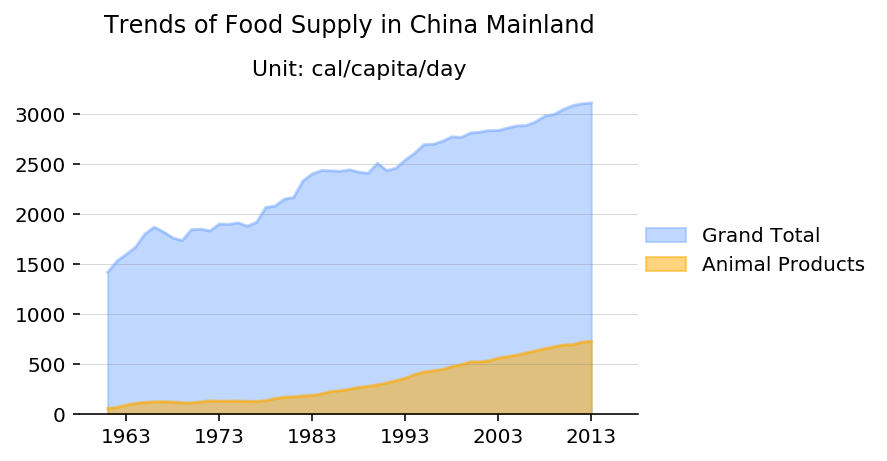

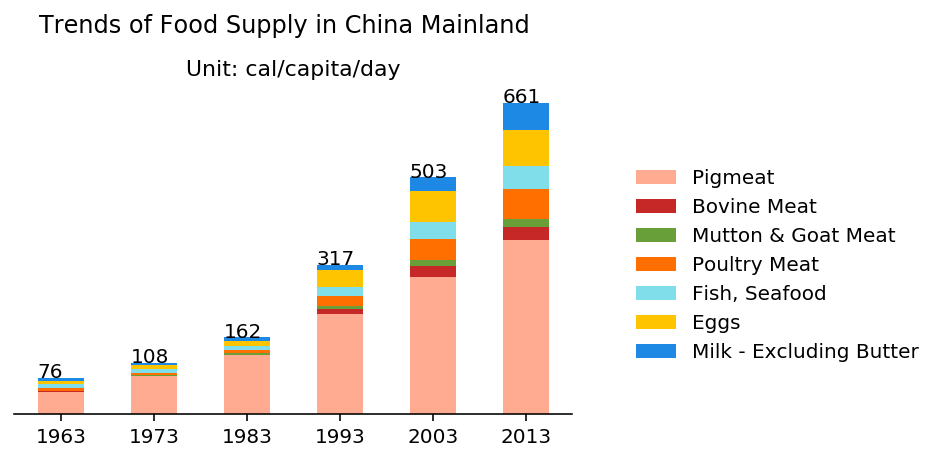

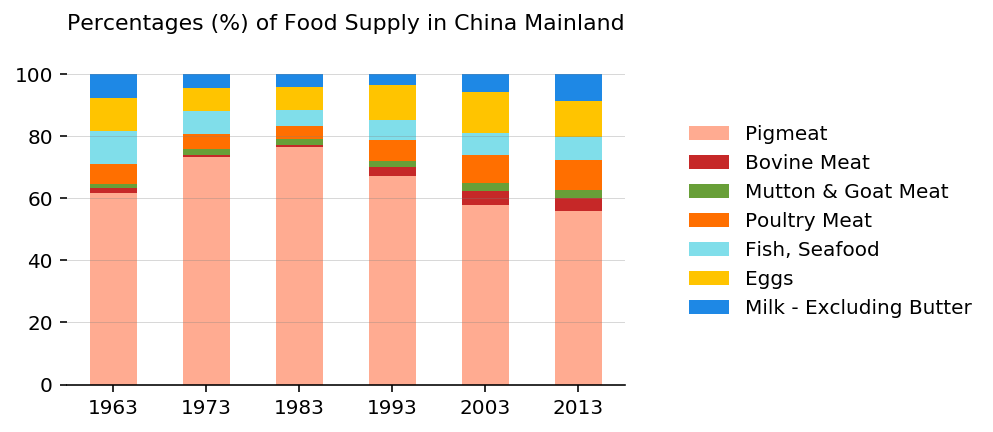

In [40]:
plotTrendsLine(A, E, items_group='Grand Total', toUnit='cal/capita/day', kind='area', colors=[GF_blue1, GF_amber2], alpha=0.5)
plotTrendsBar(A, E, toUnit='cal/capita/day')

Grand Total  Animal Products
1963        130.0            119.0
1973        116.0            111.0
1983         75.0             98.0
1993         71.0             83.0
2003         61.0             60.0
2013         52.0             47.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_02_Changes in World Rankings of China Mainland Per Capita Food Supply .png


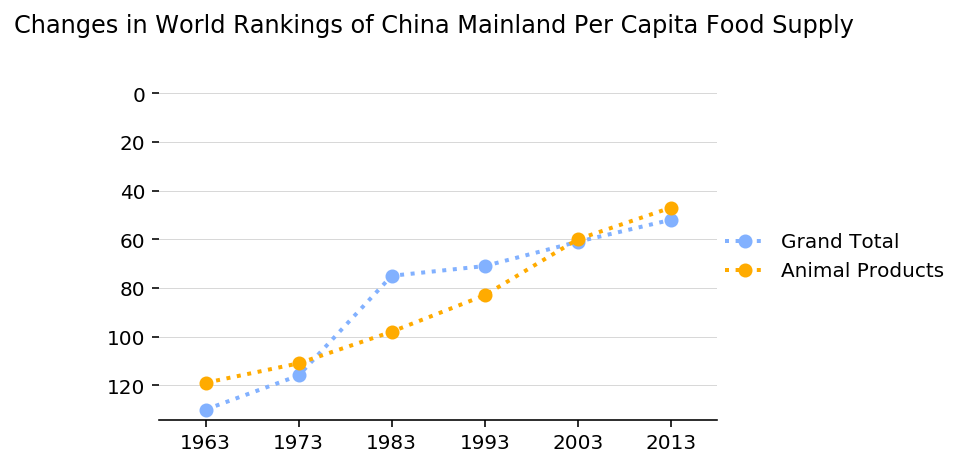

In [41]:
ranking_AreaItemInWorld(A,E, items_group='Grand Total', colors=[GF_blue1, GF_amber2])

In [42]:
worldMap(
    element = E,
    items=['Animal Products'],
    toUnit = 'g/papita/day',
    changeUnit = 1,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='YlOrBr',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply (kcalcapitaday)_03_01_Food Supply _Animal Products_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply (kcalcapitaday)_03_01_Food Supply _Animal Products_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Food supply (kcalcapitaday)_03_01_Food Supply _Animal Products_2013.html


1973    1993    2013
Argentina   902.0   987.0   989.0
Australia  1199.0  1044.0  1050.0
Austria    1084.0  1220.0  1137.0
Belgium       NaN     NaN  1172.0
Brazil      324.0   483.0   826.0

World


Grand Total  Animal Products
2009       2825.0            497.0
2010       2850.0            504.0
2011       2869.0            507.0
2012       2874.0            513.0
2013       2884.0            514.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in World.png
Northern America


Grand Total  Animal Products
2009       3625.0            989.0
2010       3630.0            986.0
2011       3632.0            971.0
2012       3667.0            976.0
2013       3663.0            972.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in Northern America.png
Western Europe


Grand Total  Animal Products
2009       3511.0           1123.0
2010       3508.0           1116.0
2011       3519.0           1116.0
2012       3481.0           1100.0
2013       3490.0           1108.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in Western Europe.png
Australia & New Zealand


Grand Total  Animal Products
2009       3195.0           1002.0
2010       3201.0            998.0
2011       3221.0           1056.0
2012       3236.0           1024.0
2013       3253.0           1040.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in Australia & New Zealand.png
South-Eastern Asia


Grand Total  Animal Products
2009       2607.0            310.0
2010       2643.0            323.0
2011       2677.0            330.0
2012       2709.0            330.0
2013       2716.0            332.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in South-Eastern Asia.png
Japan


Grand Total  Animal Products
2009       2675.0            549.0
2010       2685.0            550.0
2011       2712.0            548.0
2012       2740.0            556.0
2013       2726.0            547.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in Japan.png
Republic of Korea


Grand Total  Animal Products
2009       3203.0            535.0
2010       3281.0            535.0
2011       3354.0            564.0
2012       3325.0            574.0
2013       3334.0            576.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Food supply (kcalcapitaday)_01_01_Trends of Food Supply in Republic Of Korea.png


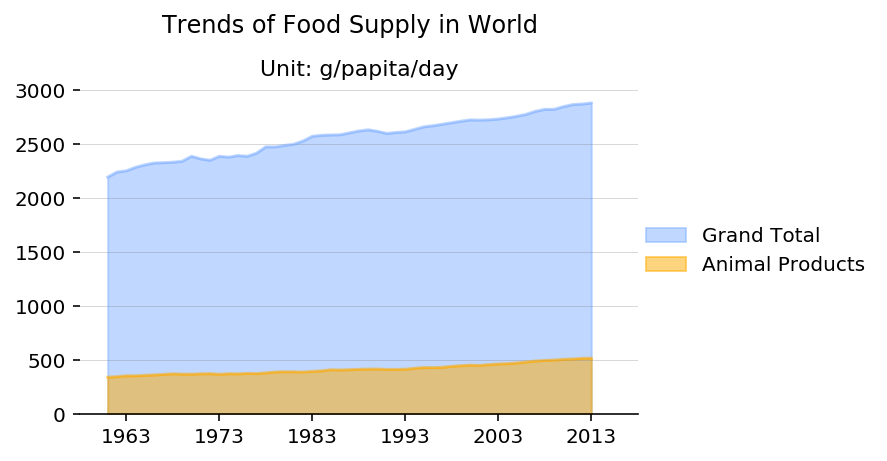

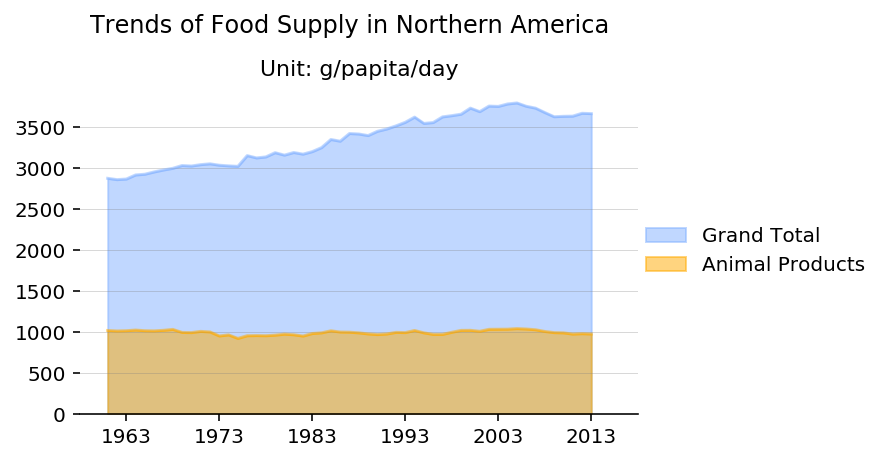

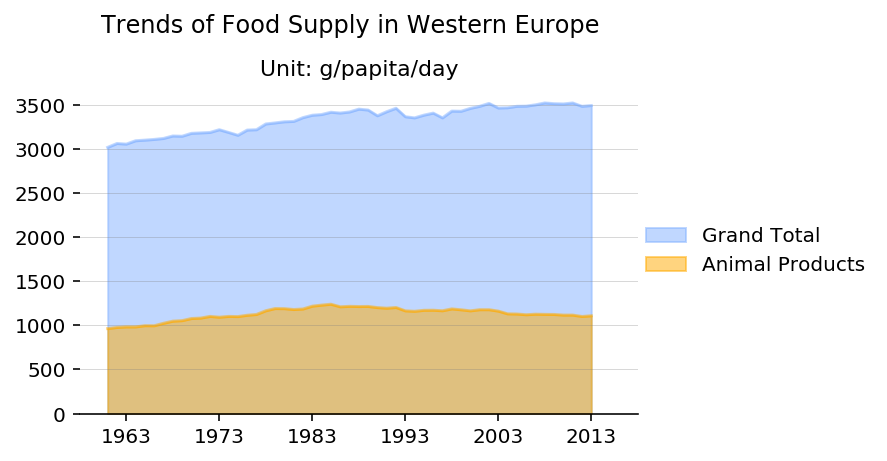

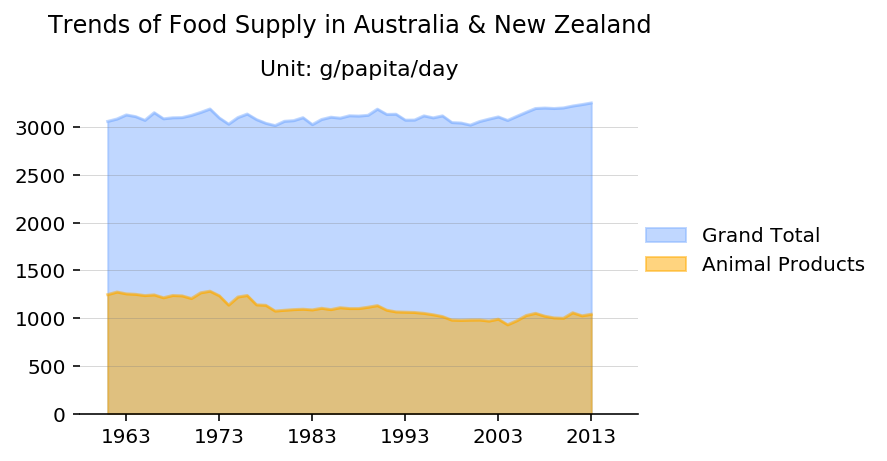

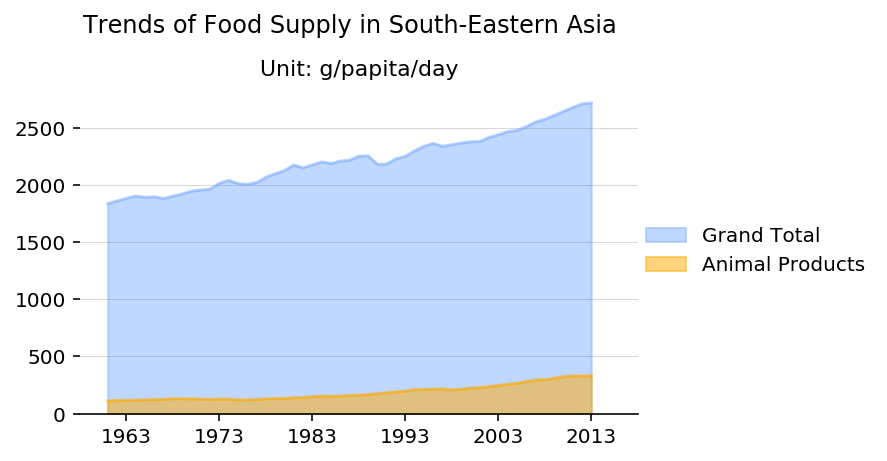

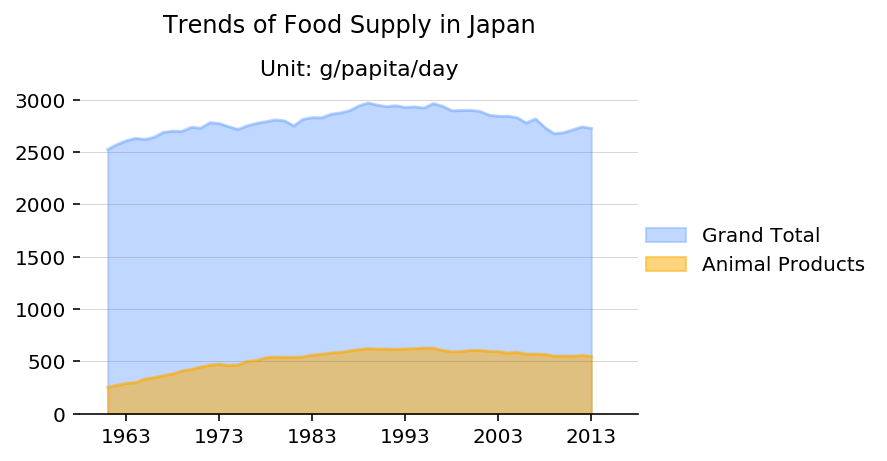

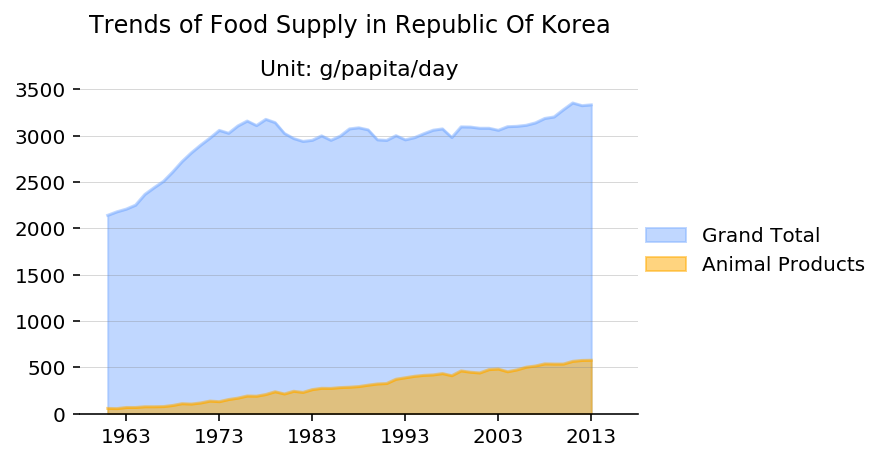

In [43]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea',
]
for a in areas:
    print(a)
    plotTrendsLine(a, E, items_group='Grand Total', kind='area', alpha=0.5, colors=[GF_blue1, GF_amber2], toUnit = 'g/papita/day',)

## Protein

In [44]:
# 给 Elements 赋值
E = 'Protein supply quantity (g/capita/day)'
# 给 Items 赋值
Is = {
    'Grand Total':['Grand Total','Animal Products'],
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [45]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Grand Total', 'Animal Products']

ITEMs_all = getAllItemsInArea(A, E, items_groups=IsGroup)
print(ITEMs_all)

data = DF_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(Is))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位


PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, items_groups=IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Fish, Seafood', 'Animal Products', 'Mutton & Goat Meat', 'Bovine Meat', 'Milk - Excluding Butter', 'Eggs', 'Pigmeat', 'Meat', 'Grand Total', 'Animal fats', 'Poultry Meat', 'Offals']


Area Code  \
Element                                Item                                 
Protein supply quantity (g/capita/day) Animal Products                 53   
                                       Bovine Meat                     53   
                                       Eggs                            53   
                                       Fish, Seafood                   53   
                                       Grand Total                     53   
                                       Meat                            53   
                                       Milk - Excluding Butter         53   
                                       Mutton & Goat Meat              53   
                                       Pigmeat                         53   
                                       Poultry Meat                    53   

                                                                Area  Year  \
Element                                Item                                  
Protein supply quantity (g/capita/day) Animal Products            53    53   
                                       Bovine Meat                53    53   
                                       Eggs                       53    53   
                                       Fish, Seafood              53    53   
                                       Grand Total                53    53   
                                       Meat                       53    53   
                                       Milk - Excluding Butter    53    53   
                                       Mutton & Goat Meat         53    53   
                                       Pigmeat                    53    53   
                                       Poultry Meat               53    53   

                                                                Unit  Value  
Element                                Item                                  
Protein supply quantity (g/capita/day) Animal Products            53     53  
                                       Bovine Meat                53     53  
                                       Eggs                       53     53  
                                       Fish, Seafood              53     53  
                                       Grand Total                53     53  
                                       Meat                       53     53  
                                       Milk - Excluding Butter    53     53  
                                       Mutton & Goat Meat         53     53  
                                       Pigmeat                    53     53  
                                       Poultry Meat               53     53

Area Code  Area  Element  Item  Year  Value
Unit                                                     
g/capita/day        530   530      530   530   530    530

'Protein supply quantity (g/capita/day)'

'Fish, Seafood'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
Africa       1.47  1.47  1.57  1.68  1.69  1.75  1.78  1.65  1.69  1.89  2.03   
Albania      0.55  0.47  0.49  0.47  0.61  0.60  0.73  0.85  0.97  1.08  1.05   
Algeria      1.01  0.59  0.43  0.49  0.44  0.51  0.44  0.36  0.46  0.48  0.45   
Americas     2.19  2.29  2.26  2.27  2.25  2.42  2.28  2.43  2.35  2.52  2.44   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.01  0.01  0.01  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02   
Africa       2.09  2.09  2.12  2.25  2.34  2.36  2.45  2.43  2.42  2.64  2.60   
Albania      1.02  1.00  1.03  1.01  0.98  0.96  0.99  0.97  0.94  0.95  0.89   
Algeria      0.55  0.56  0.66  0.70  0.62  0.74  0.59  0.67  0.79  0.93  1.04   
Americas     2.62  2.85  2.63  2.48  2.63  2.64  2.85  2.96  2.95  3.03  2.86   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.02  0.02  0.03  0.03  0.03  0.03  0.03  0.04  0.03  0.03  0.03   
Africa       2.41  2.29  2.22  2.32  2.46  2.46  2.44  2.51  2.20  2.28  2.23   
Albania      0.90  0.70  1.07  0.87  0.92  0.93  0.72  0.54  0.16  0.18  0.16   
Algeria      1.05  1.02  1.09  1.16  1.40  1.48  1.33  1.15  0.97  1.13  1.19   
Americas     2.84  2.96  3.00  3.15  3.33  3.11  3.40  3.35  3.18  3.22  3.39   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.03  0.03  0.03  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02   
Africa       2.11  2.21  2.27  2.36  2.36  2.45  2.40  2.49  2.37  2.49  2.68   
Albania      0.13  0.20  0.31  0.28  0.48  0.75  0.90  0.94  1.30  1.19  1.35   
Algeria      1.57  1.30  0.95  1.04  1.06  1.17  1.25  1.46  1.47  1.62  1.36   
Americas     3.36  3.48  3.48  3.51  3.42  3.37  3.38  3.40  3.46  3.62  3.68   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  
Africa       2.70  2.89  3.05  2.92  2.86  3.01  3.16  3.16  3.10  
Albania      1.40  1.25  1.47  1.57  1.67  1.67  1.70  1.44  1.36  
Algeria      1.45  1.68  1.66  1.50  1.50  1.18  1.24  1.24  1.22  
Americas     3.61  3.71  3.69  3.67  3.61  3.58  3.60  3.63  3.64

'Protein supply quantity (g/capita/day)'

'Animal Products'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  13.53  13.48  14.20  14.33  14.94  16.11  16.77  17.47  17.19   
Africa       10.68  10.54  10.52  10.68  10.88  11.05  11.12  11.19  11.28   
Albania      18.87  18.56  18.15  17.68  17.96  18.04  19.39  18.31  18.27   
Algeria      10.79   9.09   7.44   7.65   7.88   8.12   7.99   8.75   8.92   
Americas     42.06  41.93  42.31  42.57  42.28  43.28  43.28  43.96  43.51   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  15.29  14.31  13.21  13.96  14.14  14.26  15.03  14.50  14.60   
Africa       11.41  11.49  11.43  11.30  11.32  11.55  11.84  12.24  12.66   
Albania      18.56  19.33  18.59  19.26  19.44  19.27  19.72  19.89  21.14   
Algeria       8.55   9.05   9.48   9.34  10.54  10.73  11.53  12.54  12.57   
Americas     43.40  42.96  43.03  42.21  42.81  42.30  44.01  43.83  43.74   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  14.65  15.09  15.84  16.29  16.77  16.60  14.94  12.85  14.05   
Africa       12.61  12.88  13.26  13.33  13.15  12.68  12.80  12.65  12.79   
Albania      21.40  21.41  21.98  22.14  22.29  21.39  20.89  19.74  20.29   
Algeria      12.31  13.81  15.19  16.19  17.53  17.11  18.29  16.99  18.11   
Americas     43.81  44.53  44.32  43.33  43.43  43.59  44.38  44.98  45.20   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  14.66  14.96  16.95  16.24  14.94  14.61  15.01  15.16  16.01   
Africa       12.74  12.69  12.97  12.56  12.67  12.46  12.28  12.56  12.25   
Albania      21.56  21.96  23.91  26.68  28.05  29.75  35.27  39.50  42.30   
Algeria      17.63  18.58  18.93  18.30  18.53  20.70  19.80  18.80  16.09   
Americas     44.55  44.55  44.42  44.84  45.47  45.79  46.90  47.72  47.52   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  16.97  17.71  18.14  14.80  11.07  14.26  13.22  13.35  13.02   
Africa       12.67  12.76  13.10  13.27  13.33  13.77  14.13  14.40  14.66   
Albania      36.36  35.78  39.07  38.89  41.09  44.77  47.05  47.90  48.86   
Algeria      16.84  18.21  17.82  18.68  19.26  20.03  19.89  21.81  21.85   
Americas     47.74  48.28  49.46  49.75  49.51  50.12  49.87  50.24  50.20   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan  11.28  11.46  11.80  11.68  12.11  12.18  12.26  12.22  
Africa       15.04  15.54  15.47  15.31  15.89  16.17  16.12  16.06  
Albania      50.40  50.18  53.29  54.03  56.31  56.91  59.21  59.42  
Algeria      21.88  21.91  21.32  22.78  22.54  25.03  25.16  24.99  
Americas     50.95  51.36  51.83  51.15  51.49  51.64  51.74  52.13

'Protein supply quantity (g/capita/day)'

'Mutton & Goat Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  3.11  3.01  3.07  3.16  3.27  3.42  3.76  4.06  3.79  3.67  3.62   
Africa       1.02  0.99  0.96  0.97  0.99  1.02  1.01  1.03  1.05  1.01  1.01   
Albania      2.95  2.89  2.66  2.61  2.53  2.51  3.10  2.60  2.18  2.02  1.98   
Algeria      1.37  1.22  1.07  1.13  1.18  1.10  1.04  1.21  1.22  1.27  1.26   
Americas     0.71  0.70  0.66  0.61  0.59  0.61  0.59  0.61  0.57  0.56  0.55   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  2.87  3.17  3.30  3.45  4.04  3.96  4.02  3.92  4.18  4.45  4.62   
Africa       1.00  0.92  0.87  0.89  0.90  0.93  0.95  0.96  0.96  0.95  0.92   
Albania      1.83  1.79  1.78  1.77  1.77  1.66  1.76  1.75  1.71  1.67  1.55   
Algeria      1.26  1.29  1.22  1.21  1.25  1.28  1.30  1.41  1.43  1.44  1.68   
Americas     0.53  0.47  0.44  0.41  0.38  0.36  0.35  0.34  0.32  0.33  0.33   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  4.47  4.27  3.86  3.57  3.89  4.15  4.32  4.37  4.14  3.68  3.32   
Africa       0.91  0.89  0.89  0.87  0.89  0.93  0.95  0.94  0.94  0.96  0.92   
Albania      1.45  1.25  1.21  1.07  1.13  1.24  1.33  1.30  1.35  1.61  1.67   
Algeria      1.64  1.70  1.59  1.58  1.76  1.75  1.96  2.07  2.09  2.18  2.30   
Americas     0.33  0.32  0.33  0.35  0.33  0.33  0.33  0.33  0.33  0.33  0.33   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  3.12  2.93  3.02  3.23  3.45  3.71  3.20  2.63  2.12  2.08  2.15   
Africa       0.94  0.96  0.95  0.99  1.01  1.05  1.08  1.08  1.06  1.05  1.06   
Albania      2.05  1.96  1.85  1.75  1.87  2.07  2.25  2.23  2.28  2.30  2.53   
Algeria      2.26  2.25  2.34  2.16  2.16  2.09  2.10  2.03  2.02  2.00  2.14   
Americas     0.32  0.32  0.28  0.27  0.28  0.29  0.29  0.30  0.30  0.29  0.30   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  2.11  1.84  1.50  1.86  1.92  2.15  2.14  2.02  1.91  
Africa       1.10  1.11  1.11  1.13  1.12  1.11  1.11  1.07  1.07  
Albania      2.54  2.56  3.11  3.55  4.01  4.47  4.76  5.63  5.66  
Algeria      2.22  2.19  2.18  2.03  2.14  2.19  2.62  2.68  2.81  
Americas     0.29  0.29  0.30  0.29  0.27  0.27  0.25  0.24  0.25

'Protein supply quantity (g/capita/day)'

'Bovine Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   1.99   2.07   2.09   2.08   2.06   2.82   2.63   2.81   2.89   
Africa        2.78   2.70   2.67   2.65   2.66   2.70   2.68   2.73   2.73   
Albania       1.82   1.79   1.79   1.37   1.47   1.49   1.78   1.52   1.78   
Algeria       1.79   1.41   0.98   0.88   0.92   0.94   0.89   0.97   0.95   
Americas     12.10  12.18  12.50  12.59  12.56  12.92  13.07  13.45  13.56   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   2.33   2.27   2.17   2.18   2.09   2.01   2.01   2.09   2.10   
Africa        2.70   2.59   2.57   2.60   2.59   2.54   2.64   2.70   2.80   
Albania       1.93   2.03   1.96   1.89   1.92   1.70   2.06   1.83   2.16   
Algeria       0.81   1.01   1.08   1.10   1.18   1.13   1.22   1.51   1.26   
Americas     13.02  12.32  12.40  11.96  12.61  13.31  14.09  13.73  13.45   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   2.22   2.10   2.17   2.26   2.30   2.37   2.44   2.50   2.64   
Africa        2.75   2.86   2.80   2.89   2.86   2.81   2.79   2.67   2.56   
Albania       2.20   2.19   2.16   2.11   2.26   2.30   2.30   2.03   2.12   
Algeria       1.20   1.27   1.33   1.36   1.70   1.24   1.56   1.65   1.49   
Americas     12.33  12.27  12.34  11.87  11.88  11.93  12.16  12.36  11.75   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   2.69   2.65   3.05   2.84   2.59   2.65   2.85   3.06   3.21   
Africa        2.51   2.47   2.51   2.57   2.56   2.50   2.42   2.31   2.25   
Albania       2.51   2.58   2.85   4.77   4.79   3.72   4.06   4.30   4.94   
Algeria       1.52   1.38   1.53   1.66   1.70   1.76   1.75   1.82   1.70   
Americas     11.54  11.38  11.18  11.23  11.14  10.92  11.23  11.38  11.63   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   3.39   3.63   3.08   2.53   2.09   2.80   2.46   2.59   2.39   
Africa        2.28   2.27   2.33   2.39   2.20   2.33   2.35   2.41   2.53   
Albania       4.50   4.51   4.70   4.72   4.74   5.39   5.78   6.21   6.28   
Algeria       1.49   1.63   1.78   1.82   1.37   1.66   2.05   2.61   2.60   
Americas     11.46  11.39  11.65  11.61  11.37  11.47  11.12  11.16  11.33   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   1.94   2.19   2.05   2.03   1.94   2.00   2.13   1.89  
Africa        2.61   2.62   2.54   2.51   2.51   2.51   2.48   2.52  
Albania       7.55   7.62   8.40   8.20   8.89   8.85   9.32   9.36  
Algeria       2.27   2.23   2.14   2.30   1.85   1.98   2.32   2.25  
Americas     11.45  11.48  11.35  11.15  11.04  10.84  10.86  10.83

'Protein supply quantity (g/capita/day)'

'Milk - Excluding Butter'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   6.23   6.15   6.68   6.72   7.17   7.18   7.59   7.74   7.62   
Africa        2.72   2.70   2.66   2.66   2.79   2.80   2.82   2.90   2.89   
Albania      10.84  10.74  10.72  10.82  10.78  10.73  10.74  10.37  10.33   
Algeria       4.64   4.27   3.71   3.90   3.98   4.24   4.30   4.84   4.88   
Americas     14.34  14.00  14.06  14.25  14.27  14.49  13.96  14.10  14.07   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   6.47   5.65   5.62   6.12   6.32   6.37   6.42   5.84   5.84   
Africa        2.90   2.96   2.85   2.78   2.85   2.93   2.99   3.21   3.33   
Albania      10.56  11.30  10.82  11.61  11.58  11.48  11.48  12.07  12.67   
Algeria       4.62   4.91   5.12   4.89   5.93   6.07   6.69   7.10   7.17   
Americas     14.03  13.99  14.03  14.03  13.88  13.49  13.84  13.78  13.47   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   5.90   6.14   6.47   6.59   7.19   7.13   5.92   4.17   4.76   
Africa        3.34   3.41   3.58   3.56   3.55   3.26   3.44   3.29   3.32   
Albania      12.92  13.00  13.45  13.73  13.85  13.36  12.15  11.80  12.22   
Algeria       6.90   7.72   8.71   8.71   9.47   9.37  10.06   8.99   9.71   
Americas     13.59  13.92  13.55  13.55  13.49  13.62  13.95  14.12  14.25   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   5.00   5.12   6.80   6.70   6.25   6.37   6.89   7.05   7.69   
Africa        3.30   3.32   3.33   3.22   3.24   3.26   3.18   3.36   3.07   
Albania      12.78  13.03  14.85  16.59  18.04  18.78  23.05  26.68  28.58   
Algeria       8.98   9.95   9.78   9.37   9.65  11.61  10.33   9.50   7.60   
Americas     13.65  13.59  13.49  13.48  13.67  13.69  13.97  14.33  14.13   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   8.17   8.37   9.28   7.30   4.84   7.47   6.88   6.72   6.28   
Africa        3.19   3.26   3.31   3.40   3.55   3.85   4.00   4.01   4.06   
Albania      24.25  22.98  23.40  24.06  24.99  25.73  27.92  27.93  28.52   
Algeria       8.59   9.47   9.12   9.74  10.68  10.73   9.94  11.21  11.15   
Americas     14.02  14.05  14.16  14.36  14.22  14.29  14.17  13.83  14.10   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   5.79   6.09   5.82   5.81   5.86   5.70   6.25   6.12  
Africa        4.07   4.16   4.14   4.10   4.29   4.28   4.17   4.03  
Albania      29.12  27.27  27.99  27.97  28.64  29.57  29.47  29.96  
Algeria      11.47  11.47  11.45  12.56  12.55  14.26  13.74  13.34  
Americas     14.08  14.11  14.41  14.38  14.38  14.47  14.69  14.50

'Protein supply quantity (g/capita/day)'

'Eggs'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.28  0.30  0.30  0.31  0.32  0.33  0.36  0.33  0.34  0.30  0.28   
Africa       0.35  0.35  0.35  0.36  0.38  0.39  0.40  0.41  0.42  0.41  0.42   
Albania      0.47  0.47  0.44  0.44  0.43  0.42  0.46  0.48  0.51  0.50  0.47   
Algeria      0.34  0.28  0.20  0.19  0.19  0.19  0.19  0.21  0.22  0.21  0.21   
Americas     2.96  2.94  2.89  2.92  2.90  2.90  2.97  2.92  2.88  2.90  2.91   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.27  0.27  0.26  0.26  0.25  0.25  0.25  0.25  0.25  0.26  0.27   
Africa       0.42  0.42  0.44  0.47  0.47  0.49  0.52  0.52  0.54  0.54  0.58   
Albania      0.48  0.55  0.62  0.80  0.78  0.74  0.84  0.82  0.80  0.78  0.87   
Algeria      0.21  0.22  0.23  0.29  0.38  0.51  0.89  0.71  0.97  1.01  1.39   
Americas     2.88  2.77  2.72  2.71  2.68  2.66  2.76  2.85  2.86  2.80  2.82   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.28  0.29  0.29  0.30  0.31  0.31  0.31  0.29  0.27  0.25  0.23   
Africa       0.58  0.55  0.56  0.58  0.60  0.61  0.57  0.63  0.62  0.61  0.60   
Albania      0.96  0.99  1.07  1.12  1.21  1.19  1.33  1.38  1.08  1.11  1.54   
Algeria      1.48  1.11  1.18  0.78  0.90  0.97  1.00  1.39  1.23  0.91  0.89   
Americas     2.75  2.76  2.79  2.86  2.86  2.81  2.75  2.70  2.76  2.72  2.72   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.21  0.20  0.24  0.23  0.22  0.22  0.17  0.14  0.21  0.22  0.19   
Africa       0.61  0.61  0.57  0.56  0.62  0.63  0.61  0.62  0.66  0.65  0.65   
Albania      1.52  1.58  1.78  1.50  1.60  1.70  1.96  1.83  1.96  2.13  2.14   
Algeria      0.96  1.11  0.65  0.74  0.86  0.71  0.76  0.80  1.23  1.26  1.35   
Americas     2.75  2.72  2.71  2.79  2.80  2.91  2.98  3.05  3.03  3.03  3.07   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.21  0.20  0.27  0.31  0.29  0.24  0.32  0.25  0.38  
Africa       0.64  0.65  0.68  0.69  0.65  0.70  0.72  0.79  0.77  
Albania      2.15  2.17  2.04  2.14  2.30  2.24  2.34  3.72  3.65  
Algeria      1.28  1.29  1.39  1.28  1.33  1.79  1.89  2.07  2.30  
Americas     3.10  3.22  3.15  3.16  3.24  3.28  3.34  3.34  3.44

'Protein supply quantity (g/capita/day)'

'Pigmeat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                         
Africa    0.20  0.19  0.18  0.19  0.19  0.19  0.19  0.20  0.20  0.20  0.20   
Albania   0.56  0.56  0.47  0.46  0.51  0.59  0.65  0.72  0.77  0.77  0.77   
Algeria   0.43  0.18  0.04  0.04  0.04  0.04  0.01  0.01  0.01  0.01  0.00   
Americas  4.68  4.73  4.79  4.73  4.35  4.39  4.68  4.76  4.24  4.36  4.71   
Angola    0.45  0.44  0.44  0.43  0.48  0.46  0.45  0.45  0.45  0.44  0.46   

          1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                         
Africa    0.21  0.22  0.21  0.20  0.20  0.21  0.21  0.21  0.21  0.22  0.22   
Albania   0.77  0.70  0.71  0.69  0.70  0.70  0.69  0.69  0.67  0.83  0.81   
Algeria   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Americas  4.44  4.18  4.43  3.89  4.08  4.28  4.30  4.78  5.07  4.91  4.50   
Angola    0.45  0.47  0.49  0.51  0.53  0.61  0.62  0.68  0.80  0.74  0.73   

          1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                         
Africa    0.22  0.23  0.23  0.24  0.26  0.26  0.29  0.29  0.27  0.28  0.28   
Albania   0.83  0.84  0.89  0.93  0.91  0.95  0.93  1.01  0.69  0.89  1.22   
Algeria   0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Americas  4.68  4.56  4.49  4.20  4.24  4.43  4.29  4.11  4.20  4.41  4.48   
Angola    0.75  0.91  0.93  0.82  0.82  0.82  0.87  0.85  0.80  0.80  0.75   

          1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                         
Africa    0.28  0.34  0.34  0.34  0.33  0.32  0.31  0.32  0.32  0.32  0.34   
Albania   1.31  1.28  0.80  0.71  1.27  1.50  1.08  1.65  1.76  2.00  2.17   
Algeria   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Americas  4.62  4.57  4.35  4.35  4.74  4.84  4.76  4.69  4.70  4.76  4.75   
Angola    0.75  0.78  0.86  0.85  0.90  0.79  0.82  0.91  1.01  1.04  1.08   

          2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                            
Africa    0.35  0.36  0.39  0.42  0.42  0.39  0.41  0.42  0.43  
Albania   2.28  2.94  3.01  2.72  2.85  2.79  2.77  2.77  2.73  
Algeria   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
Americas  4.50  4.57  4.72  4.74  4.75  4.69  4.61  4.68  4.77  
Angola    1.17  1.35  1.59  1.79  1.88  1.88  2.20  2.34  2.47

'Protein supply quantity (g/capita/day)'

'Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   5.68   5.69   5.84   5.90   6.04   6.94   7.14   7.61   7.46   
Africa        5.30   5.17   5.11   5.14   5.18   5.26   5.28   5.38   5.42   
Albania       5.68   5.58   5.28   4.82   4.98   5.15   6.09   5.42   5.33   
Algeria       4.32   3.50   2.73   2.70   2.87   2.79   2.65   2.91   2.92   
Americas     21.22  21.30  21.72  21.80  21.53  22.15  22.71  23.13  22.84   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   6.76   6.67   5.80   6.11   6.15   6.21   6.80   6.87   6.93   
Africa        5.36   5.25   5.25   5.19   5.10   5.13   5.25   5.39   5.54   
Albania       5.31   5.42   5.20   5.07   5.15   4.97   5.41   5.11   5.57   
Algeria       2.83   3.04   3.12   3.19   3.22   3.19   3.34   3.70   3.47   
Americas     22.58  22.24  22.18  21.32  22.29  22.32  23.51  23.40  23.33   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   6.92   7.09   7.43   7.70   7.60   7.50   7.11   6.84   7.33   
Africa        5.49   5.67   5.67   5.76   5.78   5.76   5.75   5.65   5.63   
Albania       5.65   5.63   5.74   5.60   5.54   5.32   5.55   4.96   4.99   
Algeria       3.55   3.85   4.05   4.53   4.92   5.13   5.40   5.54   5.53   
Americas     23.09  23.47  23.59  22.83  23.04  22.96  23.35  23.59  23.49   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   7.63   7.78   8.23   7.74   7.05   6.70   6.61   6.57   6.70   
Africa        5.58   5.58   5.69   5.72   5.75   5.59   5.62   5.62   5.58   
Albania       5.70   5.87   6.21   7.90   7.60   8.03   9.08   9.41  10.13   
Algeria       5.61   5.66   5.95   6.08   6.18   6.36   6.32   6.32   6.33   
Americas     23.70  23.51  23.54  24.12  24.58  24.72  25.51  25.93  25.97   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   7.11   7.58   7.27   6.18   5.15   5.52   5.18   5.48   5.56   
Africa        5.78   5.71   5.88   6.00   5.85   6.04   6.12   6.21   6.39   
Albania       8.32   8.68  11.67  10.12  11.49  13.81  13.76  14.43  14.73   
Algeria       5.94   6.32   6.26   6.38   5.80   6.08   6.55   7.35   7.43   
Americas     26.14  26.71  27.68  27.74  27.54  27.97  27.70  28.26  28.01   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   4.47   4.29   4.82   4.70   5.11   5.25   4.88   4.85  
Africa        6.51   6.73   6.78   6.80   6.96   7.07   7.07   7.19  
Albania      15.89  17.44  19.50  20.28  21.61  21.41  22.50  22.72  
Algeria       6.90   6.85   6.59   6.85   6.47   7.02   7.50   7.50  
Americas     28.57  29.03  29.30  28.66  29.03  29.05  28.86  29.33

'Protein supply quantity (g/capita/day)'

'Grand Total'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  84.91  82.98  77.12  83.49  83.86  79.17  85.25  84.10  84.84   
Africa       52.64  53.26  53.17  53.76  53.49  53.00  53.48  53.71  54.61   
Albania      66.11  66.12  64.58  65.59  66.63  64.92  66.39  67.72  68.97   
Algeria      45.01  43.54  40.26  40.11  42.10  41.61  43.13  45.04  44.87   
Americas     77.17  76.74  77.37  78.21  78.12  78.82  79.46  80.19  79.70   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  72.82  72.70  75.75  77.38  76.99  77.79  79.73  71.13  74.66   
Africa       54.93  54.54  53.60  53.68  54.88  55.08  55.01  55.11  55.77   
Albania      69.46  69.16  70.68  71.02  72.73  71.49  77.71  81.38  79.40   
Algeria      44.03  44.67  48.71  49.59  52.21  54.88  55.88  57.32  61.14   
Americas     79.13  79.36  78.44  77.66  78.18  78.48  79.97  79.33  79.49   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  74.10  70.67  70.97  70.58  71.42  69.49  67.07  64.87  76.41   
Africa       56.37  57.27  57.19  57.35  56.90  55.99  57.22  57.72  57.96   
Albania      75.79  75.89  79.11  79.05  82.78  80.89  76.32  79.89  73.83   
Algeria      62.16  65.68  64.96  65.62  67.28  66.13  69.60  71.27  71.79   
Americas     80.29  81.00  82.22  80.86  80.46  80.52  82.43  82.05  83.05   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  70.43  67.90  66.22  59.66  54.72  56.83  54.84  52.96  54.25   
Africa       58.47  58.47  58.79  58.93  58.75  59.01  59.61  60.25  60.78   
Albania      77.26  77.02  77.62  78.73  85.19  88.74  94.08  89.77  94.47   
Algeria      72.58  74.39  73.67  73.84  76.48  78.04  76.24  75.70  75.26   
Americas     82.67  82.13  82.24  83.75  84.20  84.79  86.77  86.58  87.65   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  56.82  57.78  56.12  52.57  49.67  53.35  54.54  55.24  53.51   
Africa       61.01  61.83  62.15  62.34  62.75  63.42  64.01  64.35  65.60   
Albania      89.03  88.42  92.76  90.39  92.83  97.92  95.79  95.27  98.24   
Algeria      72.98  78.69  79.07  75.87  77.35  79.91  82.16  83.44  84.11   
Americas     87.83  88.28  89.86  90.20  89.99  90.25  91.00  91.02  91.02   

              2006   2007    2008    2009    2010    2011    2012    2013  
Area                                                                       
Afghanistan  53.46  56.00   56.96   57.79   58.14   58.91   58.91   58.25  
Africa       66.37  66.83   67.24   67.86   68.57   69.30   69.03   69.10  
Albania      97.63  97.28  101.95  101.91  106.70  108.59  111.31  111.42  
Algeria      83.73  83.21   83.45   86.53   85.94   90.09   90.18   91.96  
Americas     91.73  92.44   92.84   91.69   92.40   92.34   92.71   93.25

'Protein supply quantity (g/capita/day)'

'Animal fats'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.04  0.04  0.04  0.04  0.04  0.05  0.05  0.05  0.05  0.04  0.04   
Africa       0.02  0.03  0.02  0.03  0.02  0.03  0.03  0.03  0.03  0.03  0.03   
Albania      0.05  0.05  0.04  0.04  0.05  0.05  0.05  0.05  0.06  0.06  0.06   
Algeria      0.02  0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.02  0.01  0.01   
Americas     0.16  0.18  0.17  0.17  0.16  0.15  0.15  0.15  0.13  0.12  0.12   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04   
Africa       0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.03  0.03  0.03  0.03   
Albania      0.06  0.06  0.06  0.06  0.07  0.07  0.07  0.07  0.07  0.08  0.07   
Algeria      0.02  0.02  0.03  0.03  0.03  0.03  0.04  0.05  0.06  0.06  0.06   
Americas     0.12  0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.11  0.10  0.09   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.04  0.04  0.04  0.03  0.03  0.03  0.03  0.04  0.04  0.04  0.04   
Africa       0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03   
Albania      0.07  0.07  0.08  0.08  0.08  0.08  0.08  0.07  0.08  0.11  0.13   
Algeria      0.08  0.05  0.07  0.07  0.06  0.05  0.05  0.05  0.04  0.03  0.04   
Americas     0.10  0.10  0.10  0.10  0.09  0.09  0.10  0.09  0.09  0.09  0.09   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.04  0.06  0.05  0.06  0.06  0.06  0.05  0.03  0.05  0.05  0.05   
Africa       0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.03  0.03   
Albania      0.10  0.09  0.12  0.11  0.11  0.07  0.10  0.16  0.17  0.15  0.18   
Algeria      0.02  0.02  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
Americas     0.08  0.09  0.08  0.09  0.09  0.09  0.09  0.09  0.10  0.10  0.11   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.05  0.08  
Africa       0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  0.03  
Albania      0.21  0.23  0.26  0.26  0.28  0.25  0.20  0.19  0.13  
Algeria      0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  
Americas     0.10  0.09  0.10  0.10  0.10  0.10  0.10  0.11  0.10

'Protein supply quantity (g/capita/day)'

'Poultry Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.22  0.23  0.23  0.24  0.25  0.26  0.26  0.27  0.32  0.31  0.30   
Africa       0.44  0.44  0.45  0.47  0.48  0.50  0.51  0.53  0.56  0.58  0.59   
Albania      0.34  0.34  0.36  0.38  0.47  0.56  0.56  0.58  0.60  0.59  0.64   
Algeria      0.54  0.49  0.45  0.45  0.49  0.50  0.51  0.53  0.54  0.55  0.56   
Americas     3.23  3.21  3.28  3.39  3.61  3.80  3.94  3.90  4.06  4.24  4.26   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.29  0.30  0.29  0.30  0.29  0.30  0.30  0.32  0.32  0.34  0.35   
Africa       0.62  0.64  0.63  0.68  0.71  0.75  0.77  0.78  0.83  0.88  0.89   
Albania      0.64  0.69  0.74  0.81  0.88  0.91  0.96  1.01  1.05  1.09  1.14   
Algeria      0.58  0.60  0.62  0.64  0.65  0.67  0.68  0.69  0.91  1.06  1.26   
Americas     4.43  4.34  4.42  4.34  4.58  4.67  4.88  5.27  5.46  5.65  5.76   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.37  0.41  0.42  0.47  0.48  0.42  0.41  0.38  0.35  0.33  0.28   
Africa       0.95  0.99  1.01  1.04  1.09  1.06  1.05  1.16  1.14  1.16  1.13   
Albania      1.00  0.92  1.15  0.92  0.84  1.01  1.04  1.03  1.10  0.30  1.42   
Algeria      1.38  2.01  2.08  2.14  2.10  2.17  2.16  2.19  2.17  2.14  2.15   
Americas     5.80  5.81  6.03  6.37  6.84  7.07  7.19  7.59  8.05  8.40  8.70   

             1994  1995  1996  1997   1998   1999   2000   2001   2002   2003  \
Area                                                                            
Afghanistan  0.25  0.25  0.25  0.26   0.27   0.25   0.23   0.22   0.40   0.44   
Africa       1.18  1.24  1.27  1.38   1.35   1.41   1.48   1.52   1.58   1.65   
Albania      1.66  1.87  2.49  1.28   0.96   3.35   2.04   2.84   4.34   3.67   
Algeria      2.17  2.11  2.14  2.15   2.39   2.24   2.30   2.25   2.25   2.35   
Americas     9.02  9.36  9.42  9.80  10.00  10.60  10.75  10.85  11.17  11.25   

              2004   2005   2006   2007   2008   2009   2010   2011   2012  \
Area                                                                         
Afghanistan   0.53   0.80   0.49   0.39   0.70   0.55   0.84   0.94   0.56   
Africa        1.65   1.66   1.71   1.84   1.93   1.98   2.16   2.25   2.31   
Albania       3.48   3.59   2.81   3.68   4.81   5.21   5.43   5.01   4.77   
Algeria       2.45   2.46   2.29   2.30   2.28   2.27   2.29   2.28   2.35   
Americas     11.77  11.61  11.99  12.25  12.61  12.15  12.71  13.04  12.77   

              2013  
Area                
Afghanistan   0.87  
Africa        2.40  
Albania       4.94  
Algeria       2.28  
Americas     13.17

'Protein supply quantity (g/capita/day)'

'Offals'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  1.29  1.30  1.33  1.34  1.35  1.61  1.62  1.74  1.70  1.69  1.65   
Africa       0.82  0.82  0.80  0.81  0.81  0.83  0.82  0.83  0.82  0.82  0.80   
Albania      1.28  1.25  1.18  1.09  1.11  1.09  1.32  1.14  1.07  1.06  1.02   
Algeria      0.47  0.44  0.36  0.36  0.38  0.38  0.39  0.42  0.43  0.40  0.42   
Americas     1.19  1.21  1.21  1.17  1.16  1.18  1.20  1.23  1.23  1.23  1.24   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  1.46  1.40  1.36  1.36  1.49  1.49  1.52  1.53  1.55  1.61  1.67   
Africa       0.80  0.80  0.79  0.75  0.76  0.77  0.80  0.80  0.81  0.79  0.79   
Albania      1.00  0.97  0.99  0.94  1.01  0.95  1.00  0.97  0.98  0.98  0.97   
Algeria      0.45  0.46  0.48  0.45  0.46  0.47  0.41  0.44  0.43  0.44  0.46   
Americas     1.19  1.14  1.18  1.19  1.24  1.24  1.22  1.21  1.21  1.24  1.19   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  1.64  1.62  1.55  1.49  1.59  1.66  1.68  1.56  1.46  1.32  1.24   
Africa       0.80  0.80  0.80  0.78  0.75  0.76  0.76  0.78  0.77  0.76  0.75   
Albania      0.97  0.95  0.97  0.91  0.88  0.88  0.92  0.87  0.87  1.02  1.10   
Algeria      0.52  0.43  0.48  0.46  0.53  0.56  0.59  0.60  0.60  0.62  0.62   
Americas     1.21  1.20  1.18  1.16  1.17  1.18  1.21  1.24  1.21  1.20  1.19   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  1.24  1.25  1.30  1.38  1.45  1.27  1.08  0.88  0.99  0.88  0.89   
Africa       0.74  0.74  0.74  0.76  0.78  0.81  0.83  0.79  0.83  0.84  0.83   
Albania      1.39  1.54  1.39  1.89  1.92  1.48  1.74  1.68  1.79  1.89  1.86   
Algeria      0.59  0.55  0.55  0.52  0.49  0.55  0.55  0.51  0.51  0.51  0.53   
Americas     1.24  1.17  1.16  1.18  1.22  1.24  1.19  1.21  1.28  1.25  1.31   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.91  0.76  0.75  0.80  0.81  0.84  0.85  0.81  0.77  
Africa       0.85  0.89  0.90  0.90  0.86  0.90  0.90  0.91  0.94  
Albania      1.86  1.74  1.71  1.83  1.51  1.91  1.70  1.88  1.60  
Algeria      0.52  0.52  0.52  0.50  0.53  0.54  0.60  0.60  0.63  
Americas     1.28  1.28  1.28  1.18  1.16  1.13  1.08  1.10  1.11

'Protein supply quantity (g/capita/day)'

'Fish, Seafood'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.02    3.16     1.44     1.24      3.63    4.14       1.82   
2013         0.02    3.10     1.36     1.22      3.64    4.01       2.16   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     1.01  5.92       6.27                     6.29     3.91        0.64   
2013     1.31  5.84       6.36                     6.40     4.14        0.63   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     7.62        5.43     4.31     6.51    3.62   3.42   
2013     7.14        5.36     4.67     6.45    3.53   3.60   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              0.64                    1.26       1.3   
2013                              0.64                    1.39       1.1   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    2.91              11.34      1.81          2.24     12.85      4.53   
2013    2.88              12.04      2.11          2.18     13.12      4.26   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    5.41       2.54                      2.48             2.71   
2013    5.68       2.54                      2.29             2.67   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          0.68  1.93   3.33   8.44                 17.78   
2013          0.66  1.87   3.32   8.39                 17.64   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             15.17                       9.16             8.38      1.84   
2013             14.93                       9.14             8.33      1.82   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   7.68        3.75     5.80  1.47    6.10     2.61             NaN   
2013   8.16        3.67     5.85  1.53    6.03     2.57             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           4.73                                   2.58     8.07      1.06   
2013           4.62                                   2.57     8.60      1.08   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                2.33            1.51          9.35            5.59   
2013                2.30            1.48          9.22            5.68   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     2.41   6.45         2.14     3.95      0.08           NaN    6.50   
2013     2.38   6.33         2.12     3.96      0.07           NaN    6.55   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            6.56  10.39    10.36    8.96   9.70    5.95     3.16     4.53   
2013            6.60  10.32    10.32    9.04  10.22    6.91     3.18     4.23   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   8.07    4.87       0.40    2.74           0.53    8.61   1.45   
2013   8.59    5.21       0.39    2.67           0.39    7.86   1.43   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      1.09     1.44    27.54   1.55       9.44   
2013      1.07     1.48    26.85   1.53       9.33   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        2.80  1.02     5.22    5.44   6.94     6.70   
2013                        2.89  0.92     5.17    6.12   6.89     6.67   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  18.24    1.43        1.59   1.26    3.76        0.69   
2013  17.50    1.37        1.57   1.23    3.88        0.68   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              1.17                              6.01   
2013                              1.16                              5.90   

Area  Latvia  Least Developed Countri

'Protein supply quantity (g/capita/day)'

'Animal Products'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        12.26   16.12    59.21    25.16     51.74   18.43      66.35   
2013        12.22   16.06    59.42    24.99     52.13   18.40      66.94   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    42.31  26.52      70.29                    67.68    60.91       29.14   
2013    43.25  26.62      71.68                    68.95    62.86       30.08   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    60.85        9.87    57.87    58.42   29.76  14.23   
2013    56.43        9.92    54.96    58.12   28.95  14.25   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             30.04                   31.25     26.64   
2013                             29.76                   30.42     26.41   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   51.44              51.16     39.98         12.61     18.89     11.87   
2013   52.59              52.95     41.30         11.07     19.11     11.70   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   55.41      24.85                     20.97            35.91   
2013   54.70      25.76                     17.13            36.42   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         36.25  9.94  43.17  39.21                 93.83   
2013         36.52  9.70  45.27  39.64                 94.41   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             61.89                      43.12            38.85     33.45   
2013             61.10                      43.49            39.28     33.48   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  19.56       39.69    48.52  29.88   48.50    51.20             NaN   
2013  22.25       40.98    47.98  31.77   45.05    50.48             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          13.97                                  10.10    64.75     14.31   
2013          13.67                                  10.07    69.82     15.09   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                24.7           10.18         39.78           51.56   
2013                26.4           10.05         40.09           51.41   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    35.49  26.21        24.55    52.07      7.65           NaN   58.07   
2013    36.53  26.34        25.25    53.24      7.69           NaN   57.91   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           60.59  35.33    72.23   69.78  42.26   13.98    27.71    61.80   
2013           60.38  31.37    73.03   69.35  43.03   14.10    28.82    61.48   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  16.30   58.93      17.80    9.80           8.91   36.29  10.38   
2013  17.22   59.24      17.83    9.94           8.89   36.07  10.15   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     23.56     44.6    96.97  12.20      17.46   
2013     23.20     42.1    96.48  11.99      17.71   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       22.65  12.31    61.44   71.82  59.63    37.70   
2013                       22.22  13.18    64.82   72.47  58.24    37.11   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  49.28   28.23       57.08   16.3   50.11       35.86   
2013  48.46   27.18       57.06   15.9   53.58       35.04   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             16.86                             14.56   
2013                             16.85                             14.59   

Area  Latvia  Least Develope

'Protein supply quantity (g/capita/day)'

'Mutton & Goat Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         2.02    1.07     5.63     2.68      0.24    0.44       0.58   
2013         1.91    1.07     5.66     2.81      0.25    0.44       0.56   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     1.06  0.72       3.29                     3.89     0.39        2.80   
2013     1.12  0.74       3.30                     3.79     0.41        2.79   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     2.61        0.56     0.04     0.45    0.04   0.33   
2013     2.03        0.56     0.04     0.49    0.05   0.32   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              0.72                    0.24      1.45   
2013                              0.70                    0.17      1.45   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    0.23               0.85      0.79          1.33       0.0      0.50   
2013    0.23               0.77      0.59          0.98       0.0      0.57   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    0.33       0.41                      1.98             0.28   
2013    0.35       0.39                      1.96             0.28   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          2.87  1.36   0.21   1.11                  0.48   
2013          2.93  1.35   0.16   1.16                  0.77   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              0.28                       0.34             1.13      0.09   
2013              0.29                       0.34             1.18      0.08   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.15        0.01     0.60  0.55    2.24     0.12             NaN   
2013   0.16        0.01     0.63  0.52    1.99     0.13             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.27                                   0.27     0.26      2.05   
2013           0.27                                   0.26     0.31      2.01   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                0.09            0.55          1.01            0.40   
2013                0.09            0.55          1.05            0.39   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     0.17   0.65         0.01     0.16      0.59           NaN    0.67   
2013     0.17   0.63         0.01     0.16      0.59           NaN    0.67   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            0.74  2.02     0.19    1.14   0.51    0.31     0.19     0.26   
2013            0.73  2.04     0.18    1.14   0.51    0.29     0.23     0.25   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.69    4.81       0.09    0.60           0.57    0.42   0.31   
2013   0.68    4.66       0.09    0.62           0.56    0.41   0.31   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.01     0.05     7.52   0.24       0.18   
2013      0.01     0.04     7.23   0.23       0.18   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        1.47   0.7     1.03    0.74   0.38     0.55   
2013                        1.49   0.7     1.40    0.69   0.31     0.53   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   0.04    2.67        3.53   0.73    5.34        3.26   
2013   0.05    2.17        3.55   0.73    5.78        3.23   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              1.39                              0.11   
2013                              1.39                              0.11   

Area  Latvia  Least Developed Countries 

'Protein supply quantity (g/capita/day)'

'Bovine Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         2.13    2.48     9.32     2.32     10.86    3.35      27.18   
2013         1.89    2.52     9.36     2.25     10.83    3.48      27.27   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     7.71  1.66      13.52                    12.37     6.96        5.00   
2013     7.97  1.67      12.88                    12.06     6.80        5.12   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    11.81        0.54     7.84     5.57    2.11   1.25   
2013     9.11        0.54     6.95     5.50    2.06   1.22   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              7.24                    3.59      3.29   
2013                              7.11                    3.68      3.10   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   14.70               4.05      1.47          3.12      2.01      1.66   
2013   14.68               4.38      1.47          1.79      1.98      1.69   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   11.32        2.7                      7.96             5.40   
2013   11.17        2.7                      4.77             5.46   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          8.86  3.28   7.72   1.85                 11.32   
2013          9.11  3.20   9.03   1.96                 10.21   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              4.26                       1.90             1.80      6.59   
2013              4.22                       2.12             1.92      6.23   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   1.32        6.26     5.05  2.41    2.68     2.89             NaN   
2013   1.82        6.20     4.97  2.48    2.29     2.90             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.69                                   0.34     9.69      3.40   
2013           0.69                                   0.33    10.08      4.04   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                3.63            2.08          2.07            4.64   
2013                3.76            2.07          2.17            4.61   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     6.55   4.97         3.17     4.31      1.48           NaN    5.91   
2013     6.33   4.83         2.58     3.02      1.46           NaN    5.77   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            5.88  4.20     8.01    9.92   2.58    0.90     2.22     4.77   
2013            5.68  3.55     7.99    9.40   2.92    0.89     2.37     4.71   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.46    6.07       2.45    2.45           1.62    1.01   1.81   
2013   0.46    5.74       2.45    2.51           1.58    1.30   1.78   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      2.96     1.52     5.16   0.44       0.89   
2013      3.16     1.33     5.16   0.31       0.96   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        1.84  1.05     8.87   10.43   8.33     2.09   
2013                        1.48  1.12     8.88   11.62   7.46     1.73   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   3.56    2.31        9.46   3.83    3.48        5.86   
2013   3.59    2.25        9.41   3.85    5.10        6.04   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              3.56                              2.59   
2013                              3.53                              2.56   

Area  Latvia  Least Developed Countries 

'Protein supply quantity (g/capita/day)'

'Milk - Excluding Butter'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         6.25    4.17    29.47    13.74     14.69    1.07      14.90   
2013         6.12    4.03    29.96    13.34     14.50    1.05      14.94   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    19.33  5.83      18.91                    17.37    21.72       13.71   
2013    19.86  5.83      19.81                    18.17    22.23       14.41   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     9.60        2.02    15.08    23.20    8.14   0.77   
2013     9.96        2.05    12.27    23.91    7.24   0.78   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              4.28                   15.59     10.01   
2013                              4.18                   15.69     10.40   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   13.31               5.83     13.63          2.30      0.24      1.43   
2013   13.16               6.52     15.82          2.97      0.30      1.42   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   13.03       5.73                      1.54             9.65   
2013   12.62       6.01                      1.16             9.53   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         15.30  1.86   9.23   3.09                  9.75   
2013         15.33  1.81   9.54   3.12                  9.26   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              3.35                       3.73             3.04     11.18   
2013              3.37                       3.88             3.07     10.68   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.75       16.43    19.40  7.53   13.03    20.51             NaN   
2013   0.98       17.25    19.39  7.79   11.63    20.39             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.93                                   0.32    20.86      4.13   
2013           0.61                                   0.32    22.87      5.50   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                5.78            3.52          3.39           16.33   
2013                6.60            3.48          3.40           16.00   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    11.37   6.34        10.09    23.73      3.97           NaN   19.12   
2013    12.48   5.66        10.83    25.98      4.06           NaN   19.05   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           20.33  4.04    30.91   22.63   3.21    4.57    13.13    24.39   
2013           20.47  3.64    31.86   22.91   2.80    4.15    13.61    24.58   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.78   24.91       4.22    1.85           1.64   13.35   1.78   
2013   0.90   24.13       4.11    1.83           1.86   13.51   1.75   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      8.95    14.73    32.33   8.25       1.28   
2013      8.57    14.34    30.73   8.17       1.32   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        4.79  1.91    22.03   19.29  17.60     8.79   
2013                        4.31  2.06    24.50   20.41  17.07     8.84   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   7.28    8.18       25.49   7.92   11.85       19.35   
2013   7.19    7.65       25.90   7.65   14.85       19.48   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              6.14                              0.27   
2013                              6.18                              0.26   

Area  Latvia  Least Developed Countries 

'Protein supply quantity (g/capita/day)'

'Eggs'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.25    0.79     3.72     2.07      3.34    0.67       3.34   
2013         0.38    0.77     3.65     2.30      3.44    0.33       3.10   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     3.55  2.88       2.08                     2.23     4.34        2.22   
2013     3.43  2.92       2.50                     2.56     4.56        2.41   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     2.06        0.56     5.09     3.56    0.92   0.23   
2013     1.70        0.64     4.65     3.77    1.31   0.26   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              1.40                    1.38      0.63   
2013                              1.41                    1.32      0.56   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    2.47               5.12      2.52          0.76      0.41      0.11   
2013    2.48               5.07      2.59          0.74      0.41      0.11   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    3.73       1.54                      0.14             4.02   
2013    3.81       1.53                      0.13             4.40   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          1.63  0.07   2.71   5.85                  4.71   
2013          1.68  0.07   2.70   5.85                  4.56   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              4.47                       3.85             5.89      2.87   
2013              4.39                       3.86             5.89      2.93   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.17        2.57     2.38  2.53    2.47     3.42             NaN   
2013   0.17        2.86     2.49  2.67    2.62     3.42             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.50                                   1.48     5.04       0.2   
2013           0.56                                   1.48     5.08       0.2   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                2.13            0.30          5.72            4.22   
2013                1.95            0.29          5.72            4.20   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     2.22   1.40         2.23     3.45      0.11           NaN    3.89   
2013     2.17   1.35         2.58     3.68      0.11           NaN    3.96   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            3.61  0.87     2.91    3.84   0.35    0.16     1.65     3.75   
2013            3.74  2.03     3.00    4.10   0.35    0.28     1.80     3.82   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.33    2.80       3.95    0.54            0.2    0.33   0.14   
2013   0.34    3.16       3.96    0.55            0.2    0.22   0.14   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      1.45     3.88     2.18   0.72       1.46   
2013      1.41     3.88     2.53   0.76       1.54   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        2.08  2.62     2.72    3.26   3.81     0.69   
2013                        2.26  2.88     2.77    3.56   4.16     0.65   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   5.99    1.13        2.33   0.53    3.78        1.33   
2013   6.02    1.14        2.44   0.52    3.69        1.36   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.69                              0.59   
2013                              0.71                              0.60   

Area  Latvia  Least Developed Countries 

'Protein supply quantity (g/capita/day)'

'Pigmeat'

Area  Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia  Asia  \
2012    0.42     2.77      0.0      4.68    2.34       2.69     2.28  4.66   
2013    0.43     2.73      0.0      4.77    2.47       3.20     2.53  4.73   

Area  Australia  Australia & New Zealand  Austria  Azerbaijan  Bahamas  \
2012       5.69                     5.57    13.81        0.07     9.35   
2013       5.69                     5.57    15.06        0.06     9.11   

Area  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012         0.0    11.75     9.78    5.63   0.31   
2013         0.0    11.73     9.43    4.98   0.24   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              2.26                    2.51      0.21   
2013                              2.27                    2.50      0.22   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    3.34               1.60      7.18          0.62      2.02      0.45   
2013    3.33               2.01      7.26          0.61      1.98      0.47   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    6.57       2.90                      1.15             3.59   
2013    6.18       3.17                      1.17             3.73   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          1.01  0.02   7.30  11.36                 16.53   
2013          0.99  0.02   7.33  11.62                 17.43   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             19.03                      11.58            11.32      1.79   
2013             18.80                      11.77            11.58      1.94   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.33        2.64    10.65  5.26    9.66    10.89             NaN   
2013   0.61        2.64    10.17  6.02    9.34    10.60             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.36                                   1.40     7.63      0.03   
2013           0.45                                   1.41     7.61      0.04   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                2.31            0.43         10.66            8.33   
2013                2.46            0.46         10.89            8.36   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     3.69    0.0         0.71     7.19      0.01           NaN    9.63   
2013     3.87    0.0         0.81     7.19      0.01           NaN    9.60   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           10.94  1.37     9.78    8.84   2.00    0.08     1.89    14.43   
2013           10.79  1.32     9.45    8.69   2.79    0.05     2.17    14.26   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.36    6.68       1.24    0.05           2.92    0.63   1.26   
2013   0.42    6.88       1.24    0.05           2.88    0.84   1.25   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      1.53    10.84     5.08   0.09       0.90   
2013      1.79     9.77     5.68   0.08       0.91   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                         0.0   0.0     8.48    0.64  10.41     0.86   
2013                         0.0   0.0     8.56    0.53  10.54     0.86   

Area  Japan  Jordan  Kazakhstan  Kenya  Kyrgyzstan  \
2012   5.66    0.01        2.81   0.06        1.31   
2013   5.60    0.01        2.73   0.07        1.18   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.72                              2.73   
2013                              0.73                              2.83   

Area  Latvia  Least Developed Countries  Lebanon  Lesotho  Liberia  Lithuania  \
2012   10.06          

'Protein supply quantity (g/capita/day)'

'Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         4.88    7.07    22.50      7.5     28.86   11.99      43.57   
2013         4.85    7.19    22.72      7.5     29.33   12.44      43.93   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    15.75  10.56      39.40                    38.28    29.78       11.50   
2013    16.13  10.70      38.96                    37.95    30.55       11.59   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    40.54         1.6    29.45    22.09   16.62   9.34   
2013    36.29         1.6    29.38    21.44   16.39   9.18   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             21.87                   11.87     13.06   
2013                             21.68                   10.84     12.46   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   31.57              28.28     19.29          6.17      4.61      5.23   
2013   32.86              28.67     18.08          4.43      4.52      5.31   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   31.36      14.06                     15.07            17.36   
2013   30.83      14.66                     11.84            17.72   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         16.95  5.04  27.47  19.33                 51.30   
2013         17.17  4.93  28.97  19.77                 49.55   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             36.27                      24.72            19.06     16.00   
2013             35.84                      24.96            19.52     16.55   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   9.84       15.79    19.80  17.48   25.58    22.59             NaN   
2013  11.65       16.16    19.17  18.81   23.50    22.06             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           6.25                                   5.36    26.70      7.55   
2013           6.34                                   5.35    29.06      7.05   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               13.43            4.16         18.90           23.01   
2013               14.48            4.12         19.29           23.19   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    17.56  10.70         9.56    18.55      2.86           NaN   26.41   
2013    17.63  11.17         9.31    17.58      2.82           NaN   26.28   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           28.18  18.24    26.80   30.76  25.88    2.96     8.70    27.97   
2013           27.75  13.82    26.64   29.84  26.73    2.47     8.97    27.88   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   6.27   24.63       8.68    3.95           5.74   13.69   6.25   
2013   6.45   25.10       8.81    4.10           5.65   14.13   6.07   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     11.18    23.31    32.86   1.45       4.38   
2013     11.52    21.05    34.40   1.32       4.58   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       12.22  6.55    29.18   39.86  29.64    19.62   
2013                       12.12  7.12    30.55   38.62  28.58    19.13   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  16.35   16.95       24.85   5.69   28.97       12.88   
2013  16.26   16.44       24.51   5.67   29.36       11.92   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              7.78                              6.72   
2013                              7.74                              6.85   

Area  Latvia  Least Developed C

'Protein supply quantity (g/capita/day)'

'Grand Total'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        58.91   69.03   111.31    90.18     92.71   55.59     101.97   
2013        58.25   69.10   111.42    91.96     93.25   57.26     102.64   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    87.75  76.88     104.51                   102.45   103.44       91.57   
2013    90.04  77.57     106.28                   104.06   106.21       93.15   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    90.80       54.64    99.55    98.95   71.66  64.48   
2013    86.62       55.84    93.82    99.59   73.27  64.43   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             65.09                   88.96     65.97   
2013                             66.01                   91.64     64.86   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   93.58              90.57     81.52         80.54     64.78     69.00   
2013   94.99              93.41     83.53         79.38     65.66     69.96   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012  104.60      66.30                     52.80            81.59   
2013  104.95      68.33                     46.06            82.49   

Area  Central Asia   Chad  Chile  China  China, Hong Kong SAR  \
2012         83.74  62.77  85.25  97.38                129.29   
2013         84.91  62.72  87.36  98.04                129.18   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             95.85                      88.39            97.37     64.15   
2013             94.84                      89.74            98.02     64.38   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  49.74       74.35    83.53  86.55   81.11    86.86             NaN   
2013  51.66       75.07    84.35  90.86   77.61    87.47             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          58.67                                  55.36   103.81     64.28   
2013          58.51                                  55.00   108.88     65.86   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               56.08           57.39         95.96           97.82   
2013               58.20           56.71         96.48           97.42   

Area  Ecuador   Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    60.86  103.78        71.98    97.75     61.94           NaN  102.15   
2013    61.36  103.24        71.90   103.90     60.40           NaN  102.06   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012          103.79  78.11   116.36  111.25  85.54   62.08    77.15   101.81   
2013          103.85  73.60   117.72  110.52  86.63   61.55    80.53   101.59   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  66.62  108.23      64.57   55.28          43.77   78.23  47.21   
2013  64.57  108.80      63.73   55.93          44.04   79.51  47.72   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     64.28    80.67   134.11  59.18      61.94   
2013     64.88    78.85   133.54  60.25      62.18   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel   Italy  Jamaica  \
2012                       86.78  62.39   105.87  127.87  109.10    76.29   
2013                       87.28  63.63   110.02  128.14  108.51    76.97   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  88.57   80.08       94.87  62.58   99.79       85.48   
2013  87.73   79.59       96.41  61.84  108.24       85.16   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             67.57                             66.08   
2013                             67.46                             68.90   

Area  Latvia  Least

'Protein supply quantity (g/capita/day)'

'Animal fats'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.05    0.03     0.19     0.01      0.11    0.02       0.03   
2013         0.08    0.03     0.13     0.01      0.10    0.01       0.03   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     0.28  0.05       0.18                     0.20     0.70        0.09   
2013     0.27  0.05       0.17                     0.19     0.75        0.08   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     0.17        0.01     0.09     0.89    0.10   0.01   
2013     0.12        0.01     0.10     0.90    0.11   0.01   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              0.05                    0.08      0.07   
2013                              0.05                    0.08      0.07   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    0.05               0.07      0.33          0.04      0.08      0.02   
2013    0.05               0.09      0.33          0.03      0.07      0.02   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    1.37       0.03                      0.09             0.03   
2013    1.34       0.03                      0.07             0.03   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          0.05  0.02   0.24   0.01                  0.07   
2013          0.05  0.02   0.22   0.01                  0.08   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              0.12                       0.04             0.01      0.05   
2013              0.12                       0.04             0.01      0.05   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.01        0.11     0.05  0.01    0.07     0.50             NaN   
2013   0.01        0.11     0.06  0.01    0.03     0.51             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.01                                   0.04     0.81      0.03   
2013           0.01                                   0.04     0.75      0.03   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                0.03            0.03          0.02            0.27   
2013                0.03            0.03          0.01            0.29   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     0.16   0.07         0.04     0.34      0.01           NaN    0.36   
2013     0.17   0.06         0.06     0.17      0.01           NaN    0.36   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            0.41  0.14     0.57    0.48   0.03    0.04     0.20     0.63   
2013            0.40  0.16     0.55    0.51   0.03    0.02     0.22     0.60   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.01    0.21       0.04    0.01           0.07    0.01   0.02   
2013   0.01    0.21       0.05    0.01           0.07    0.02   0.02   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.02     0.63     0.69   0.04       0.05   
2013      0.02     0.59     0.73   0.04       0.05   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        0.08  0.01     0.50    0.04   0.32     0.03   
2013                        0.07  0.01     0.48    0.04   0.30     0.03   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   0.02    0.05        0.12   0.04    0.08        0.03   
2013   0.01    0.06        0.12   0.04    0.09        0.03   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.04                               0.1   
2013                              0.05                               0.1   

Area  Latvia  Least Developed Countries 

'Protein supply quantity (g/capita/day)'

'Poultry Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.56    2.31     4.77     2.35     12.77    5.65      12.62   
2013         0.87    2.40     4.94     2.28     13.17    5.84      12.38   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     4.71  3.23      15.85                    15.36     7.94        3.63   
2013     4.51  3.27      16.06                    15.45     7.67        3.56   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    16.51        0.44     9.73     4.57    8.70   7.03   
2013    15.78        0.44    10.56     4.36    9.13   6.97   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             10.95                    5.52      1.57   
2013                             10.91                    4.48      1.90   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   13.23              21.59      9.28          0.80      0.58      1.10   
2013   14.56              21.36      8.09          0.76      0.56      1.11   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   13.10       6.86                      0.52             7.82   
2013   13.08       7.15                      0.49             7.96   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          2.30  0.15  12.13   4.42                 21.12   
2013          2.15  0.14  12.36   4.45                 19.58   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             12.19                      10.87             4.23      7.38   
2013             12.04                      10.69             4.26      8.23   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   3.37        6.88     3.18  5.83    9.44     6.89             NaN   
2013   4.51        7.32     3.02  6.13    8.91     6.48             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.73                                   0.55     8.72      1.80   
2013           0.81                                   0.55    10.64      0.69   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                7.39            0.60          4.60            8.79   
2013                8.15            0.55          4.61            8.92   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     6.87   4.45         5.67     6.78      0.22           NaN    8.91   
2013     6.96   5.04         5.91     7.14      0.22           NaN    8.89   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            9.16  10.59     7.90    9.21  11.66    1.31     4.34     7.20   
2013            9.04   6.82     8.19    8.76  11.82    0.89     4.15     7.26   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   2.51    6.12       4.78    0.59           0.63   11.58   2.37   
2013   2.69    6.48       4.90    0.65           0.63   11.50   2.25   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      6.68    10.20    10.64   0.63       2.41   
2013      6.55     9.24    10.88   0.63       2.53   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        8.80  4.79    10.51   28.04   7.87    16.11   
2013                        9.04  5.28    10.85   25.78   7.69    16.00   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   7.02   11.95        6.48   0.20   19.91        1.75   
2013   6.95   11.98        6.20   0.16   18.26        0.76   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              1.30                              1.30   
2013                              1.28                              1.35   

Area  Latvia  Least Developed Countri

'Protein supply quantity (g/capita/day)'

'Offals'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.81    0.91     1.88     0.60      1.10    0.55       2.69   
2013         0.77    0.94     1.60     0.63      1.11    0.56       2.78   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     2.39  0.99       3.43                     3.29     0.46        0.99   
2013     2.25  1.00       3.86                     3.65     0.63        0.98   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     0.85        0.26     3.85     2.16    0.36   0.45   
2013     1.21        0.26     3.89     1.66    0.37   0.43   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                               1.8                    1.08      1.58   
2013                               1.8                    1.10      1.82   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    1.13               0.51      2.39          1.10      0.70      0.56   
2013    1.16               0.52      2.37          0.72      0.69      0.57   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    0.50       0.96                      1.66             2.12   
2013    0.42       0.99                      1.63             2.05   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          1.64  1.02   0.19   1.72                 10.17   
2013          1.62  1.00   0.50   1.74                 13.27   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              2.47                        1.6             1.68      1.50   
2013              2.43                        1.6             1.69      1.46   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   1.10        1.04     1.09  0.87    1.23     1.58             NaN   
2013   1.28        0.92     1.02  0.97    1.21     1.53             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           1.55                                   0.31     3.27      1.34   
2013           1.54                                   0.31     3.44      1.22   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                1.01            0.67          1.68            2.13   
2013                1.03            0.65          1.71            2.05   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     1.76   1.26         0.49     2.05      0.62           NaN    1.78   
2013     1.70   1.77         0.34     1.88      0.61           NaN    1.71   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            1.49  1.62     0.68    3.09    3.1    0.29     0.87     0.54   
2013            1.41  1.39     0.66    2.93    2.9    0.28     1.05     0.37   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.84    1.51       0.51    0.72           0.74    0.30   0.74   
2013   0.92    1.41       0.50    0.77           0.73    0.34   0.73   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.86     0.61     1.37   0.19       0.85   
2013      0.61     0.76     1.24   0.18       0.90   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        0.68  0.19     1.79    3.91   1.29     1.87   
2013                        0.57  0.19     1.36    3.71   1.20     1.78   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   1.31    0.50        2.70   0.85    1.67        1.60   
2013   1.36    0.52        2.52   0.78    1.70        1.56   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              1.04                              0.86   
2013                              1.03                              0.87   

Area  Latvia  Least Developed Countries 

Grand Total  Animal Products
2009        92.63            36.06
2010        94.98            37.10
2011        95.64            37.45
2012        97.37            38.85
2013        98.02            39.28

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in China Mainland.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973     2.46         0.08                0.12          0.35           1.45   
1983     3.83         0.11                0.20          0.45           1.27   
1993     6.60         0.61                0.43          1.52           3.35   
2003     9.01         1.54                0.88          3.12           5.97   
2013    11.58         1.92                1.18          4.26           8.33   

      Eggs  Milk - Excluding Butter    Sum  
1973  0.65                     0.26   5.37  
1983  0.90                     0.38   7.14  
1993  2.77                     0.62  15.90  
2003  5.10                     1.55  27.17  
2013  5.89                     3.07  36.23

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_02_Trends of Protein Supply Quantity in China Mainland_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_03_Percentages (%) of Protein Supply Quantity in China Mainland.png


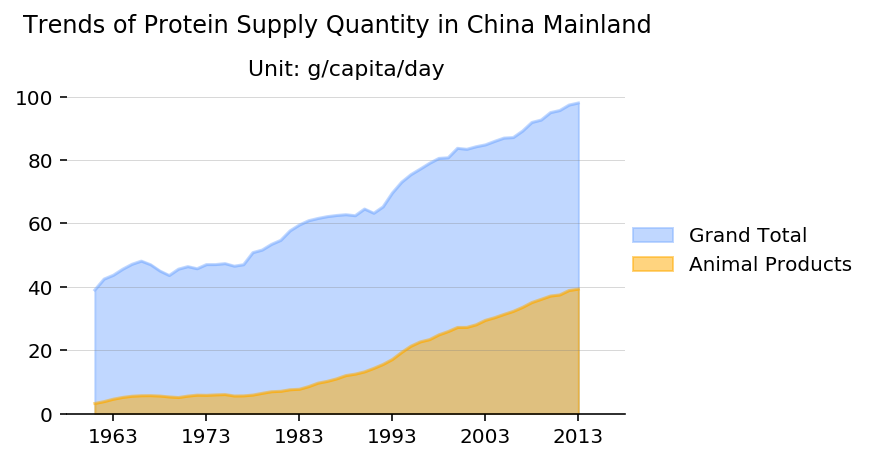

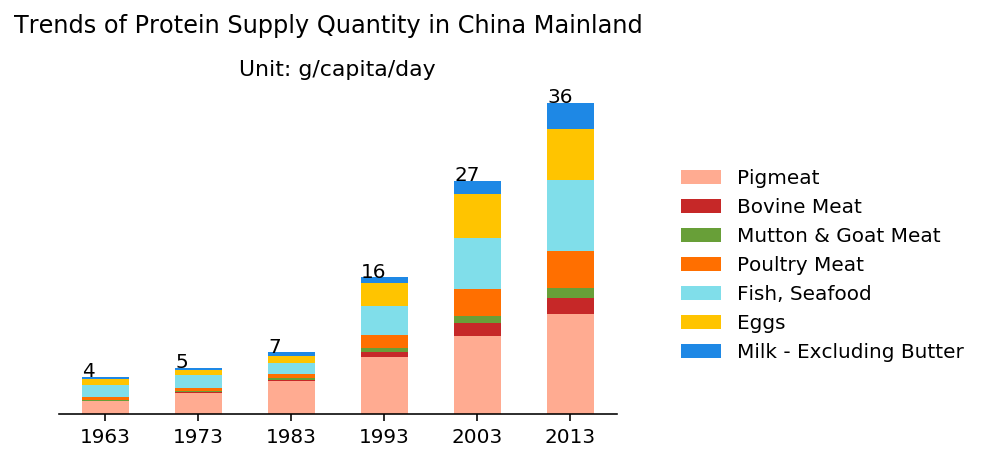

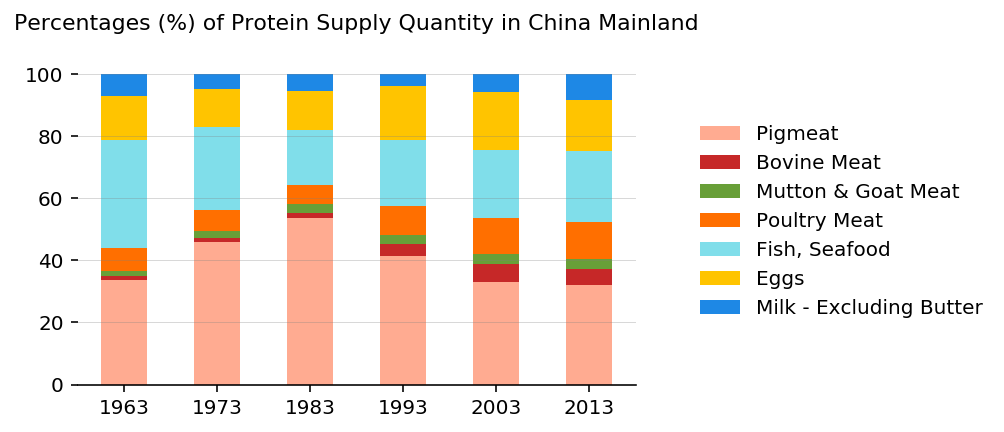

In [46]:
plotTrendsLine(A, E, items_group='Grand Total', toUnit='g/capita/day', kind='area', colors=[GF_blue1, GF_amber2], alpha=0.5)
plotTrendsBar(A, E, toUnit='g/capita/day')

Grand Total  Animal Products
1963        114.0            129.0
1973        109.0            127.0
1983         82.0            122.0
1993         73.0            100.0
2003         52.0             77.0
2013         35.0             63.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_02_Changes in World Rankings of China Mainland Per Capita Protein Supply Quantity .png


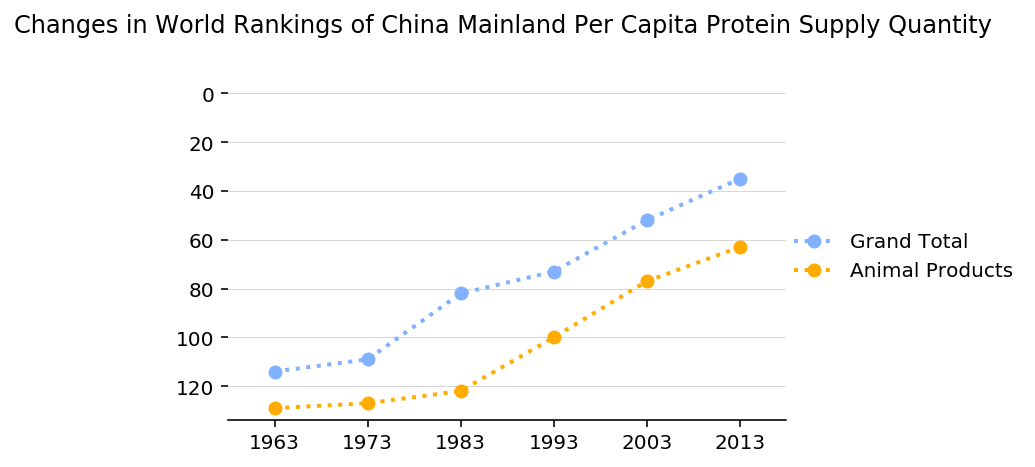

In [47]:
ranking_AreaItemInWorld(A,E, items_group='Grand Total', colors=[GF_blue1, GF_amber2])

In [48]:
worldMap(
    element = E,
    items=['Animal Products'],
    toUnit = 'g/papita/day',
    changeUnit = 1,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='YlOrBr',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Protein supply quantity (gcapitaday)_03_01_Protein Supply Quantity _Animal Products_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Protein supply quantity (gcapitaday)_03_01_Protein Supply Quantity _Animal Products_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Protein supply quantity (gcapitaday)_03_01_Protein Supply Quantity _Animal Products_2013.html


1973   1993   2013
Argentina  59.40  66.50  66.94
Australia  71.61  70.25  71.68
Austria    55.08  67.00  62.86
Belgium      NaN    NaN  58.12
Brazil     20.60  31.35  52.59

World


Grand Total  Animal Products
2009        78.88            31.08
2010        80.06            31.52
2011        80.50            31.76
2012        80.78            32.10
2013        81.23            32.13

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in World.png
Northern America


Grand Total  Animal Products
2009       110.13            69.76
2010       109.98            69.44
2011       108.15            68.26
2012       109.18            68.34
2013       109.13            68.29

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in Northern America.png
Western Europe


Grand Total  Animal Products
2009       105.44            65.97
2010       105.58            65.39
2011       105.73            65.27
2012       105.38            65.40
2013       105.23            65.19

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in Western Europe.png
Australia & New Zealand


Grand Total  Animal Products
2009       101.47            65.88
2010       101.60            66.80
2011       104.95            70.62
2012       102.45            67.68
2013       104.06            68.95

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in Australia & New Zealand.png
South-Eastern Asia


Grand Total  Animal Products
2009        63.52            22.61
2010        65.22            23.53
2011        66.27            24.26
2012        67.02            24.22
2013        67.47            24.38

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in South-Eastern Asia.png
Japan


Grand Total  Animal Products
2009        87.06            48.51
2010        87.64            48.71
2011        87.41            48.55
2012        88.57            49.28
2013        87.73            48.46

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in Japan.png
Republic of Korea


Grand Total  Animal Products
2009        91.87            43.06
2010        91.64            43.19
2011        97.21            45.73
2012        95.61            46.15
2013        96.20            46.13

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Protein supply quantity (gcapitaday)_01_01_Trends of Protein Supply Quantity in Republic Of Korea.png


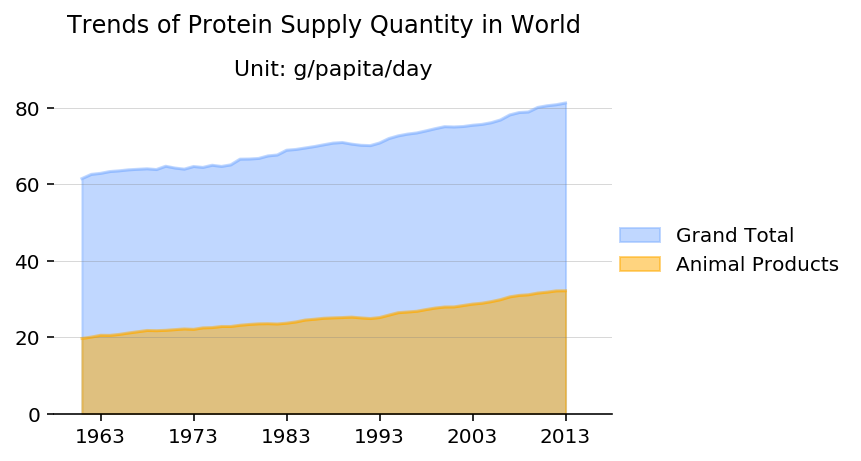

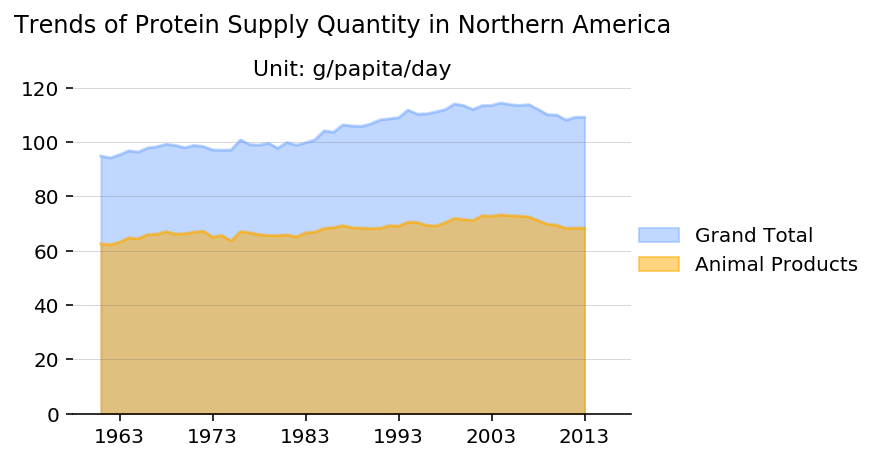

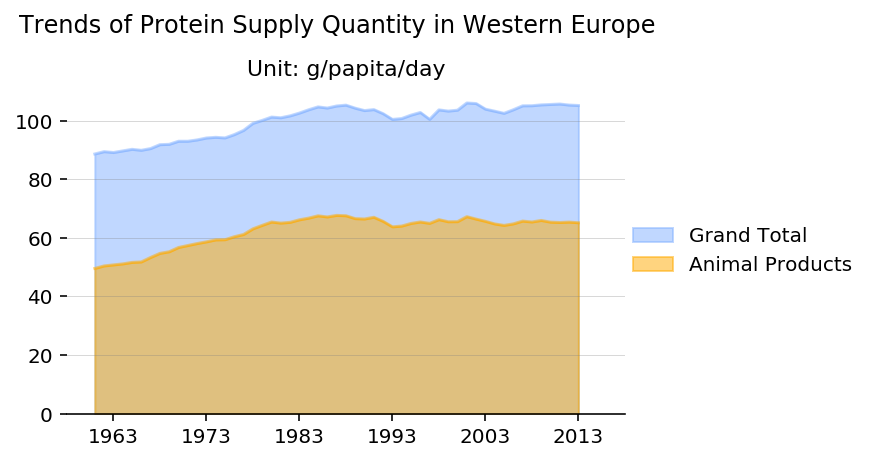

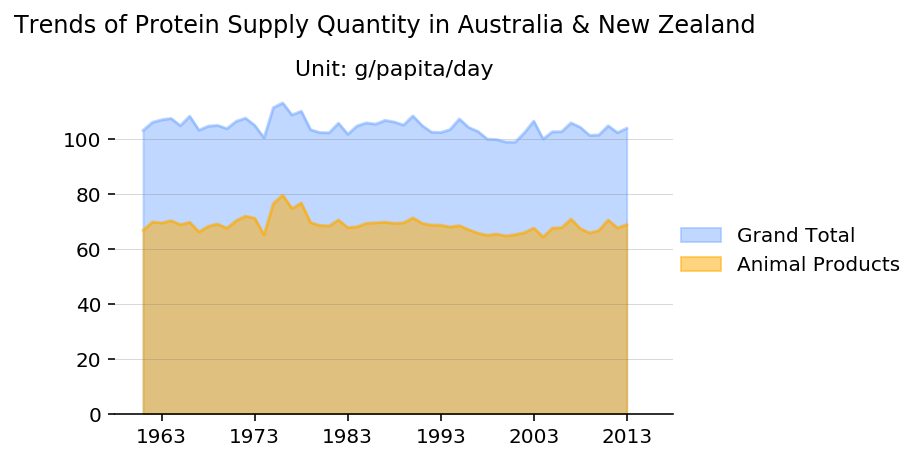

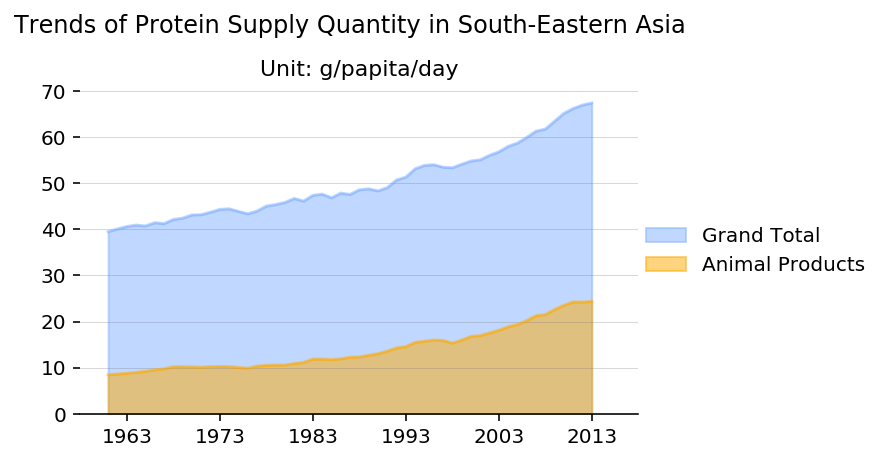

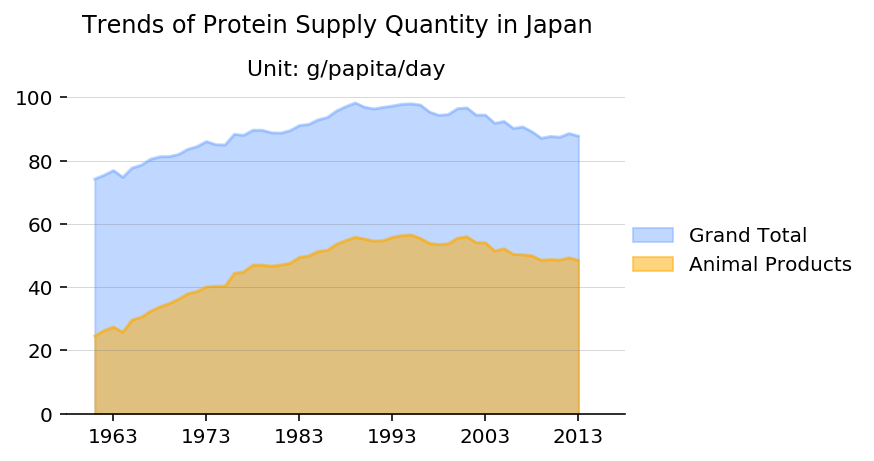

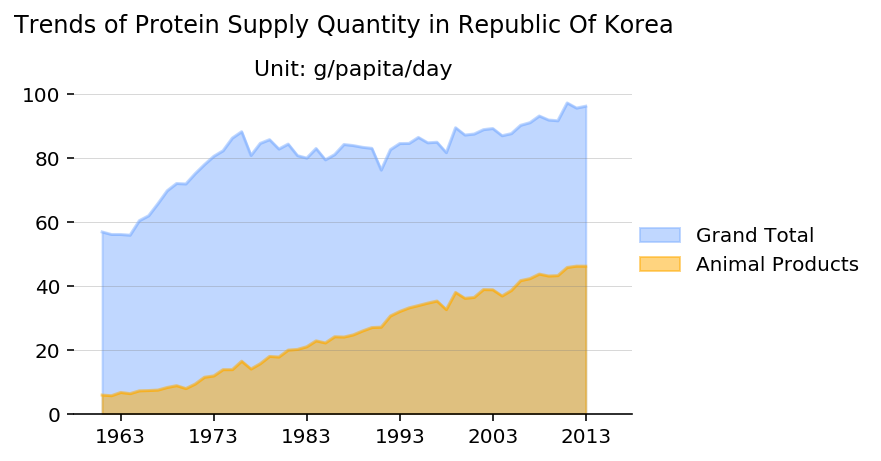

In [49]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea',
]
for a in areas:
    print(a)
    plotTrendsLine(a, E, items_group='Grand Total', kind='area', alpha=0.5, colors=[GF_blue1, GF_amber2], toUnit = 'g/papita/day',)

## Fat

In [50]:
# 给 Elements 赋值
E = 'Fat supply quantity (g/capita/day)'
# 给 Items 赋值
Is = {
    'Grand Total':['Grand Total','Animal Products'],
#   动物产品（未包含蜂蜜）
    'Animal Products':['Meat','Fish, Seafood','Eggs','Milk - Excluding Butter','Offals','Animal fats'],
#   畜禽肉
    'Meat': ['Pigmeat','Bovine Meat','Mutton & Goat Meat','Poultry Meat', 'Meat, Other'],
    'Pigmeat':[],
    'Bovine Meat':[],
    'Mutton & Goat Meat':[],
    'Poultry Meat':[], 
#   水产（未包含子类）
    'Fish, Seafood':[],
#   蛋类
    'Eggs':[],
#   奶类
    'Milk - Excluding Butter':[],
}

data = DF_area.copy()

data = data[(data['Element']==E) & (data['Item'].isin(Is))]

display(data.groupby(['Element','Item']).count())

# display(data.head(2))
# display(data.tail(2))

# display(data.groupby(['Item']).count())
display(data.groupby(['Unit']).count())                   # 查看单位

# 生成条件
CDTs[E] = Is
# display(CDTs)

# 生成主要末梢 ITEMs (所有空值键 + 自定义键)
items = []
for i in CDTs[E]:
    if CDTs[E][i]==[]: items.append(i)
ITEMs=items
print(ITEMs)

Area Code  Area  \
Element                            Item                                       
Fat supply quantity (g/capita/day) Animal Products                 53    53   
                                   Bovine Meat                     53    53   
                                   Eggs                            53    53   
                                   Fish, Seafood                   53    53   
                                   Grand Total                     53    53   
                                   Meat                            53    53   
                                   Milk - Excluding Butter         53    53   
                                   Mutton & Goat Meat              53    53   
                                   Pigmeat                         53    53   
                                   Poultry Meat                    53    53   

                                                            Year  Unit  Value  
Element                            Item                                        
Fat supply quantity (g/capita/day) Animal Products            53    53     53  
                                   Bovine Meat                53    53     53  
                                   Eggs                       53    53     53  
                                   Fish, Seafood              53    53     53  
                                   Grand Total                53    53     53  
                                   Meat                       53    53     53  
                                   Milk - Excluding Butter    53    53     53  
                                   Mutton & Goat Meat         53    53     53  
                                   Pigmeat                    53    53     53  
                                   Poultry Meat               53    53     53

Area Code  Area  Element  Item  Year  Value
Unit                                                     
g/capita/day        530   530      530   530   530    530

['Pigmeat', 'Bovine Meat', 'Mutton & Goat Meat', 'Poultry Meat', 'Fish, Seafood', 'Eggs', 'Milk - Excluding Butter']


In [51]:
# 设置 items group, 自动生成 ITEMs_all, ITEMs
IsGroup = ['Grand Total', 'Animal Products']

ITEMs_all = getAllItemsInArea(A, E, items_groups=IsGroup)
print(ITEMs_all)

PVs_AreaYear[E] = mkPVs_forItem_AreaYear(E, items_groups=IsGroup)

PVs_YearArea[E] = {}
for i, pv in PVs_AreaYear[E].items():
    display(E, i, pv.head())
    
    df = PVs_AreaYear[E][i].copy()
    PVs_YearArea[E][i]=df.transpose()

for i, pv in PVs_YearArea[E].items():
    display(E, i, pv.tail(2))

['Fish, Seafood', 'Animal Products', 'Mutton & Goat Meat', 'Bovine Meat', 'Milk - Excluding Butter', 'Eggs', 'Pigmeat', 'Meat', 'Grand Total', 'Animal fats', 'Poultry Meat', 'Offals']


'Fat supply quantity (g/capita/day)'

'Fish, Seafood'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Africa       0.27  0.28  0.28  0.30  0.32  0.33  0.35  0.32  0.34  0.39  0.42   
Albania      0.12  0.10  0.11  0.10  0.13  0.13  0.16  0.19  0.21  0.24  0.23   
Algeria      0.26  0.12  0.10  0.12  0.11  0.12  0.10  0.09  0.11  0.14  0.13   
Americas     0.48  0.51  0.49  0.50  0.50  0.53  0.49  0.52  0.50  0.57  0.55   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Africa       0.44  0.45  0.44  0.49  0.54  0.54  0.57  0.55  0.57  0.62  0.58   
Albania      0.22  0.22  0.23  0.22  0.22  0.21  0.22  0.21  0.21  0.21  0.20   
Algeria      0.17  0.15  0.19  0.20  0.18  0.21  0.16  0.19  0.20  0.24  0.27   
Americas     0.60  0.65  0.61  0.56  0.77  0.77  0.83  0.86  0.85  0.84  0.78   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01   
Africa       0.56  0.52  0.51  0.54  0.56  0.56  0.54  0.56  0.49  0.53  0.52   
Albania      0.20  0.16  0.26  0.20  0.21  0.21  0.16  0.10  0.03  0.03  0.03   
Algeria      0.28  0.27  0.30  0.33  0.40  0.44  0.38  0.33  0.29  0.33  0.34   
Americas     0.79  0.83  0.84  0.88  0.89  0.77  0.83  0.71  0.69  0.69  0.71   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.01  0.01  0.01  0.01  0.01  0.01  0.00  0.00  0.00  0.00  0.00   
Africa       0.49  0.51  0.53  0.56  0.56  0.57  0.56  0.58  0.54  0.58  0.62   
Albania      0.03  0.06  0.07  0.05  0.08  0.18  0.16  0.17  0.28  0.22  0.39   
Algeria      0.45  0.38  0.26  0.28  0.28  0.31  0.33  0.40  0.40  0.44  0.37   
Americas     0.71  0.75  0.75  0.76  0.73  0.73  0.73  0.73  0.74  0.77  0.79   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.00  0.00  0.01  0.01  0.01  0.00  0.00  0.00  0.00  
Africa       0.63  0.67  0.71  0.67  0.65  0.69  0.72  0.73  0.71  
Albania      0.45  0.23  0.39  0.41  0.42  0.51  0.46  0.34  0.31  
Algeria      0.40  0.48  0.47  0.41  0.42  0.33  0.34  0.33  0.33  
Americas     0.90  0.90  0.92  0.92  0.89  0.89  0.91  0.90  0.90

'Fat supply quantity (g/capita/day)'

'Animal Products'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  18.44  18.28  19.39  19.65  20.40  21.71  22.65  23.85  23.09   
Africa       10.69  10.55  10.33  10.48  10.74  10.86  10.92  11.23  11.29   
Albania      29.91  29.35  26.96  26.34  28.00  29.50  29.43  29.72  29.37   
Algeria      13.01  10.62   9.32   9.79  10.55  10.30  10.35  11.16  11.19   
Americas     47.48  47.31  47.02  46.58  46.07  45.85  46.24  46.85  45.07   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  20.82  19.50  17.92  18.94  19.36  19.48  21.05  20.43  20.57   
Africa       11.21  11.13  10.98  10.85  10.82  10.92  11.14  11.44  11.77   
Albania      30.79  27.73  24.41  26.15  26.68  26.43  27.01  26.44  27.09   
Algeria      10.60  11.03  11.82  11.92  13.16  13.38  13.31  14.31  14.90   
Americas     44.88  44.98  44.65  42.71  44.03  43.18  44.10  44.34  44.67   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  20.60  20.94  22.03  22.62  23.12  22.65  20.64  17.40  19.12   
Africa       11.92  12.36  12.80  12.64  12.44  11.99  12.34  12.27  12.10   
Albania      27.36  26.71  29.42  27.67  28.68  27.31  27.41  28.08  29.14   
Algeria      15.18  17.89  19.16  19.74  21.92  18.72  21.90  20.08  19.09   
Americas     45.35  46.79  46.19  45.02  45.57  45.74  46.69  45.92  45.80   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan  19.99  20.39  23.18  22.06  20.07  19.50  19.97  21.43  22.15   
Africa       12.24  12.05  12.04  11.74  11.83  11.72  11.55  11.78  11.48   
Albania      30.66  31.12  31.83  32.67  37.36  42.04  44.95  50.61  51.50   
Algeria      19.26  19.35  19.44  18.20  18.32  18.83  17.34  16.68  15.30   
Americas     45.57  45.00  44.44  45.33  46.04  46.19  47.47  47.13  46.73   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan  23.17  23.77  24.94  20.17  15.09  18.44  16.82  17.16  16.62   
Africa       11.59  11.72  11.95  12.28  12.14  12.62  13.00  13.06  13.33   
Albania      42.08  41.32  43.75  44.92  48.56  51.34  53.70  55.45  57.18   
Algeria      14.90  15.91  16.20  16.22  16.60  16.98  17.69  19.19  19.26   
Americas     47.22  48.58  50.00  50.73  50.14  50.72  50.83  51.47  51.37   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan  14.49  14.65  15.05  15.11  15.42  15.43  15.24  15.24  
Africa       13.58  13.95  14.13  13.88  14.18  14.38  14.13  14.01  
Albania      58.37  59.47  62.26  64.92  65.37  66.16  67.82  67.72  
Algeria      20.16  19.43  19.07  20.03  20.49  22.64  22.55  22.37  
Americas     52.11  52.34  52.57  52.31  52.86  52.99  53.22  53.78

'Fat supply quantity (g/capita/day)'

'Mutton & Goat Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  4.62  4.50  4.65  4.85  4.98  5.08  5.42  5.95  5.51  5.43  5.28   
Africa       1.02  0.98  0.95  0.96  0.99  1.02  1.01  1.04  1.07  1.02  1.02   
Albania      3.12  3.04  2.87  2.82  2.74  2.67  3.28  2.87  2.39  2.32  2.33   
Algeria      1.49  1.36  1.21  1.31  1.30  1.21  1.15  1.35  1.37  1.44  1.44   
Americas     0.96  0.95  0.89  0.82  0.78  0.81  0.79  0.81  0.75  0.74  0.73   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  4.32  4.67  4.91  5.09  6.11  6.21  6.32  6.12  6.43  6.81  7.05   
Africa       1.02  0.91  0.85  0.88  0.89  0.90  0.91  0.92  0.93  0.93  0.89   
Albania      2.17  2.11  2.10  2.07  2.08  1.89  2.06  2.05  2.00  1.96  1.78   
Algeria      1.45  1.49  1.39  1.40  1.47  1.50  1.52  1.64  1.68  1.70  2.00   
Americas     0.69  0.60  0.55  0.51  0.48  0.45  0.42  0.42  0.40  0.40  0.40   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  6.80  6.48  5.99  5.55  5.98  6.34  6.55  6.58  6.17  5.39  4.80   
Africa       0.88  0.87  0.87  0.83  0.86  0.91  0.91  0.90  0.89  0.91  0.90   
Albania      1.64  1.33  1.28  1.16  1.14  1.30  1.45  1.48  1.52  1.78  1.83   
Algeria      1.95  2.03  1.91  1.91  2.12  2.13  2.39  2.53  2.55  2.67  2.83   
Americas     0.40  0.41  0.40  0.43  0.40  0.41  0.40  0.40  0.41  0.40  0.40   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  4.46  4.11  4.30  4.55  4.79  5.14  4.31  3.73  2.59  2.54  2.67   
Africa       0.92  0.93  0.92  0.96  1.00  1.05  1.07  1.06  1.03  1.02  1.03   
Albania      2.29  2.61  2.23  2.12  2.15  2.33  2.48  2.44  2.52  2.54  2.80   
Algeria      2.78  2.76  2.86  2.62  2.63  2.54  2.56  2.46  2.45  2.43  2.61   
Americas     0.40  0.38  0.34  0.33  0.33  0.35  0.36  0.36  0.36  0.35  0.36   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  2.70  2.29  1.91  2.42  2.61  2.90  2.88  2.72  2.55  
Africa       1.06  1.09  1.08  1.11  1.09  1.08  1.08  1.03  1.04  
Albania      2.81  2.91  3.69  4.26  4.71  5.34  5.68  6.69  6.72  
Algeria      2.71  2.67  2.65  2.45  2.59  2.65  3.19  3.26  3.42  
Americas     0.35  0.35  0.37  0.35  0.33  0.32  0.30  0.29  0.30

'Fat supply quantity (g/capita/day)'

'Bovine Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  2.21  2.31  2.33  2.31  2.30  3.13  2.93  3.12  3.22  2.59  2.52   
Africa       2.78  2.70  2.68  2.67  2.68  2.71  2.69  2.74  2.74  2.72  2.59   
Albania      1.33  1.31  1.31  1.00  1.07  1.09  1.30  1.11  1.30  1.41  1.48   
Algeria      1.49  1.23  0.89  0.82  0.86  0.88  0.86  0.93  0.92  0.79  0.98   
Americas     7.07  7.13  7.27  7.10  7.07  7.28  7.38  7.69  7.79  7.49  6.93   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  2.41  2.42  2.32  2.24  2.24  2.33  2.34  2.47  2.34  2.41  2.51   
Africa       2.58  2.63  2.63  2.58  2.67  2.72  2.82  2.77  2.87  2.80  2.89   
Albania      1.43  1.38  1.40  1.24  1.50  1.34  1.57  1.61  1.60  1.58  1.54   
Algeria      1.05  1.07  1.14  1.08  1.12  1.26  1.07  1.03  1.04  1.04  1.09   
Americas     6.89  6.70  7.12  7.57  7.96  7.78  7.75  7.23  7.19  7.21  6.82   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  2.56  2.64  2.71  2.78  2.94  2.99  2.95  3.40  3.16  2.88  2.95   
Africa       2.82  2.80  2.79  2.66  2.55  2.48  2.45  2.47  2.52  2.52  2.48   
Albania      1.65  1.68  1.68  1.48  1.55  1.83  1.88  2.08  3.47  3.49  2.71   
Algeria      1.39  1.00  1.31  1.32  1.30  1.36  1.31  1.40  1.47  1.58  1.54   
Americas     6.74  6.83  7.03  7.16  6.82  6.64  6.80  6.77  6.84  6.67  6.40   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  3.17  3.40  3.57  3.77  4.04  3.43  2.82  2.33  3.11  2.73  2.87   
Africa       2.34  2.21  2.17  2.17  2.17  2.22  2.29  2.14  2.25  2.26  2.30   
Albania      2.95  3.12  3.43  3.19  3.21  3.33  3.40  3.39  3.76  4.03  4.21   
Algeria      1.54  1.61  1.47  1.37  1.48  1.59  1.70  1.30  1.49  1.68  1.94   
Americas     6.38  6.54  6.62  6.59  6.50  6.71  6.63  6.56  6.64  6.47  6.52   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  2.63  2.12  2.40  2.27  2.26  2.16  2.21  2.36  2.10  
Africa       2.39  2.46  2.45  2.43  2.39  2.40  2.39  2.36  2.39  
Albania      4.30  5.16  5.25  5.87  5.88  6.37  6.39  6.75  6.78  
Algeria      1.89  1.74  1.72  1.68  1.77  1.54  1.58  1.77  1.76  
Americas     6.76  6.94  7.00  6.90  6.77  6.75  6.68  6.72  6.75

'Fat supply quantity (g/capita/day)'

'Milk - Excluding Butter'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   5.40   5.31   5.83   5.82   6.22   6.32   6.73   6.88   6.71   
Africa        2.86   2.79   2.75   2.73   2.86   2.85   2.85   2.95   2.89   
Albania      10.80  10.69  10.65  10.74  10.68  10.61  10.53  10.11  10.00   
Algeria       5.32   4.55   3.89   4.09   4.36   4.65   4.81   5.26   5.46   
Americas     12.20  11.92  12.00  12.15  12.26  12.43  11.95  12.04  11.97   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   5.72   5.06   5.08   5.49   5.62   5.66   5.70   5.11   5.10   
Africa        2.91   2.94   2.85   2.77   2.78   2.83   2.86   2.97   3.07   
Albania      10.11  10.70  10.19  11.09  10.99  10.63  10.41  10.71  11.39   
Algeria       5.15   5.19   5.36   5.12   5.70   5.89   5.88   6.55   6.68   
Americas     11.94  11.93  12.19  12.11  12.20  12.21  12.46  12.34  12.19   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   5.20   5.34   5.58   5.70   6.24   6.14   5.25   3.51   4.12   
Africa        3.08   3.22   3.35   3.30   3.31   2.93   3.09   3.09   3.08   
Albania      11.65  11.65  12.20  12.45  12.61  12.39  10.89  10.74  11.23   
Algeria       5.89   7.15   7.76   7.17   7.76   7.52   7.96   7.17   6.93   
Americas     12.30  12.40  12.31  12.56  12.46  12.68  12.83  12.89  13.12   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   4.32   4.41   5.99   5.84   5.52   5.69   6.20   6.50   7.09   
Africa        3.15   3.17   3.16   3.06   3.10   3.09   3.13   3.25   3.17   
Albania      11.91  12.18  14.68  15.79  18.50  20.28  25.19  29.28  31.51   
Algeria       6.96   7.17   6.69   6.47   7.31   7.28   7.08   6.48   6.16   
Americas     12.99  12.82  12.77  12.87  13.00  13.06  13.26  13.66  13.54   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   7.55   7.75   8.63   6.77   4.39   7.04   6.28   6.28   5.89   
Africa        3.24   3.31   3.43   3.52   3.70   3.96   4.22   4.19   4.25   
Albania      26.82  25.46  25.44  26.56  27.42  28.36  30.84  30.74  30.98   
Algeria       6.56   7.31   7.52   7.59   8.42   7.98   8.21   9.26   9.47   
Americas     13.57  13.67  13.83  14.18  14.02  13.98  13.91  13.73  14.01   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   5.43   5.66   5.39   5.31   5.16   5.09   5.23   5.19  
Africa        4.29   4.30   4.32   4.28   4.45   4.37   4.23   4.08  
Albania      31.28  28.22  29.65  29.60  30.17  31.09  30.89  31.43  
Algeria      10.33   9.63   9.23  10.79  10.64  11.66  11.66  11.13  
Americas     14.08  14.03  14.29  14.27  14.43  14.49  14.55  14.41

'Fat supply quantity (g/capita/day)'

'Eggs'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.26  0.28  0.29  0.30  0.31  0.31  0.35  0.31  0.33  0.29  0.26   
Africa       0.29  0.29  0.29  0.30  0.32  0.33  0.34  0.35  0.35  0.35  0.35   
Albania      0.41  0.41  0.38  0.38  0.38  0.37  0.40  0.41  0.44  0.44  0.41   
Algeria      0.27  0.23  0.16  0.16  0.16  0.15  0.16  0.17  0.18  0.17  0.17   
Americas     2.69  2.67  2.63  2.65  2.63  2.63  2.69  2.64  2.61  2.63  2.63   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.26  0.25  0.25  0.25  0.24  0.24  0.24  0.24  0.24  0.25  0.26   
Africa       0.35  0.35  0.37  0.39  0.39  0.41  0.43  0.43  0.45  0.45  0.49   
Albania      0.42  0.48  0.54  0.69  0.68  0.64  0.73  0.71  0.69  0.68  0.76   
Algeria      0.17  0.17  0.18  0.24  0.31  0.41  0.73  0.57  0.78  0.82  1.13   
Americas     2.61  2.50  2.46  2.45  2.42  2.40  2.48  2.56  2.57  2.52  2.53   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.26  0.27  0.28  0.29  0.29  0.29  0.29  0.28  0.26  0.24  0.22   
Africa       0.48  0.46  0.47  0.49  0.51  0.52  0.48  0.52  0.52  0.51  0.50   
Albania      0.83  0.86  0.93  0.97  1.05  1.03  1.16  1.20  0.94  0.96  1.33   
Algeria      1.20  0.90  0.96  0.63  0.73  0.78  0.81  1.12  0.99  0.74  0.72   
Americas     2.47  2.48  2.51  2.56  2.57  2.52  2.46  2.42  2.47  2.44  2.43   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.20  0.19  0.23  0.22  0.21  0.21  0.16  0.14  0.20  0.21  0.18   
Africa       0.51  0.51  0.48  0.47  0.52  0.53  0.51  0.52  0.55  0.55  0.55   
Albania      1.32  1.37  1.54  1.30  1.39  1.48  1.75  1.61  1.72  1.88  1.89   
Algeria      0.78  0.89  0.53  0.59  0.69  0.57  0.61  0.65  1.00  1.02  1.09   
Americas     2.46  2.43  2.42  2.50  2.51  2.61  2.67  2.72  2.71  2.71  2.74   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.20  0.19  0.26  0.29  0.28  0.23  0.31  0.24  0.36  
Africa       0.54  0.55  0.57  0.58  0.55  0.58  0.60  0.66  0.65  
Albania      1.89  1.91  1.79  1.88  2.03  1.97  2.06  3.33  3.28  
Algeria      1.04  1.04  1.13  1.03  1.07  1.44  1.53  1.67  1.85  
Americas     2.77  2.87  2.81  2.82  2.89  2.92  2.98  2.98  3.07

'Fat supply quantity (g/capita/day)'

'Pigmeat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                         
Africa    0.60  0.57  0.55  0.58  0.58  0.57  0.59  0.60  0.63  0.61  0.63   
Albania   2.15  2.12  1.81  1.76  1.94  2.23  2.47  2.74  2.93  2.94  2.93   
Algeria   0.86  0.34  0.07  0.07  0.08  0.07  0.02  0.02  0.02  0.02  0.01   
Americas  7.07  7.13  7.17  7.09  6.62  6.69  7.09  7.19  6.50  6.68  7.20   
Angola    1.70  1.66  1.65  1.62  1.79  1.74  1.71  1.70  1.68  1.64  1.71   

          1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                         
Africa    0.66  0.67  0.63  0.62  0.63  0.64  0.64  0.63  0.64  0.66  0.67   
Albania   2.91  2.67  2.70  2.64  2.65  2.67  2.61  2.62  2.56  3.14  3.07   
Algeria   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Americas  6.86  6.53  6.92  6.27  6.57  6.95  7.00  7.74  8.23  8.03  7.41   
Angola    1.70  1.76  1.84  1.89  1.98  2.24  2.27  2.52  2.91  2.71  2.68   

          1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                         
Africa    0.67  0.69  0.69  0.72  0.77  0.78  0.86  0.87  0.83  0.86  0.84   
Albania   3.14  3.20  3.38  3.54  3.44  3.60  3.53  3.86  2.62  3.35  4.53   
Algeria   0.00  0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
Americas  7.72  7.49  7.29  6.71  6.78  7.05  6.76  6.49  6.74  7.06  7.31   
Angola    2.74  3.28  3.33  2.98  2.98  2.99  3.16  3.09  2.91  2.92  2.77   

          1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                         
Africa    0.84  1.04  1.04  1.04  1.02  1.00  0.96  0.97  0.98  0.99  1.05   
Albania   4.89  4.77  2.86  2.60  3.94  3.53  3.94  4.57  4.32  4.70  5.18   
Algeria   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.01   
Americas  7.62  7.59  7.31  7.38  8.12  8.29  8.25  8.12  8.10  8.26  8.27   
Angola    2.75  2.84  3.12  3.08  3.24  2.88  2.98  3.27  3.61  3.73  3.89   

          2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                            
Africa    1.08  1.08  1.21  1.30  1.32  1.19  1.25  1.29  1.32  
Albania   5.63  6.72  7.51  7.33  7.77  7.81  7.96  7.68  7.90  
Algeria   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  
Americas  7.66  7.83  8.15  8.23  8.28  8.23  8.11  8.28  8.45  
Angola    4.17  4.82  5.62  6.30  6.64  6.66  7.81  8.24  8.70

'Fat supply quantity (g/capita/day)'

'Meat'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   7.15   7.14   7.36   7.53   7.64   8.58   8.71   9.44   9.12   
Africa        4.96   4.82   4.76   4.79   4.84   4.91   4.91   5.02   5.09   
Albania       6.97   6.84   6.37   6.00   6.27   6.60   7.66   7.36   7.27   
Algeria       4.38   3.42   2.63   2.66   2.75   2.68   2.54   2.82   2.84   
Americas     17.63  17.73  17.94  17.68  17.30  17.76  18.33  18.75  18.24   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan   8.40   8.18   7.10   7.46   7.60   7.69   8.71   8.91   9.05   
Africa        5.00   4.89   4.93   4.88   4.78   4.77   4.90   4.98   5.10   
Albania       7.31   7.44   7.22   6.91   7.02   6.84   7.20   6.90   7.29   
Algeria       2.78   2.96   3.06   3.13   3.11   3.10   3.20   3.39   3.22   
Americas     18.26  18.21  17.92  17.28  18.12  17.78  18.64  18.87  19.08   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan   8.95   9.13   9.61   9.96   9.76   9.55   9.14   8.75   9.34   
Africa        5.06   5.21   5.19   5.28   5.25   5.28   5.30   5.15   5.14   
Albania       7.38   7.32   7.87   7.64   7.53   7.22   7.60   7.20   7.05   
Algeria       3.33   3.56   3.69   4.20   4.54   4.75   4.97   5.04   5.21   
Americas     19.63  20.21  20.19  19.28  19.52  19.37  19.55  19.37  19.43   

              1988   1989   1990   1991   1992   1993   1994   1995   1996  \
Area                                                                         
Afghanistan   9.73   9.90  10.36   9.69   8.61   8.06   7.91   7.78   8.12   
Africa        5.12   5.16   5.24   5.23   5.29   5.20   5.13   5.24   5.21   
Albania       7.84   7.99   8.56   8.80   8.94  10.62  11.92  12.51  12.43   
Algeria       5.32   5.53   5.78   5.86   6.06   6.18   6.14   6.15   6.14   
Americas     19.69  19.65  19.68  20.37  20.81  21.09  21.68  22.12  21.88   

              1997   1998   1999   2000   2001   2002   2003   2004   2005  \
Area                                                                         
Afghanistan   8.58   9.09   8.82   7.36   6.28   6.03   5.62   5.94   5.95   
Africa        5.33   5.31   5.43   5.53   5.41   5.54   5.58   5.69   5.84   
Albania       8.96  10.16  12.40  11.73  13.19  14.97  14.96  15.65  16.26   
Algeria       5.81   6.10   6.01   6.18   5.63   5.83   6.06   6.53   6.57   
Americas     22.29  23.14  24.06  24.11  23.96  24.29  24.39  24.96  24.34   

              2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                 
Afghanistan   4.79   4.63   5.20   5.28   5.64   5.73   5.48   5.24  
Africa        5.98   6.19   6.36   6.34   6.32   6.41   6.40   6.52  
Albania      17.44  20.10  22.18  23.28  24.57  25.24  26.06  26.52  
Algeria       6.30   6.25   5.99   6.20   6.02   6.59   6.89   7.01  
Americas     25.03  25.60  25.91  25.50  25.91  26.01  26.02  26.64

'Fat supply quantity (g/capita/day)'

'Grand Total'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan  37.51  37.61  38.57  38.95  39.73  39.95  41.85  41.99  41.50   
Africa       39.59  40.94  40.89  40.28  41.54  40.40  41.27  42.25  42.78   
Albania      44.85  46.06  43.14  48.29  44.41  47.17  47.30  47.92  48.66   
Algeria      29.78  25.21  26.61  28.98  29.86  29.26  30.73  31.37  32.66   
Americas     77.89  77.96  78.28  79.82  79.42  81.14  81.61  82.89  82.95   

              1970   1971   1972   1973   1974   1975   1976   1977   1978  \
Area                                                                         
Afghanistan  37.92  35.18  34.64  37.20  38.81  39.95  41.95  38.40  38.52   
Africa       42.91  42.91  41.81  42.22  43.88  42.93  43.71  45.49  46.02   
Albania      52.08  48.85  44.39  48.88  51.92  54.15  57.69  59.44  57.50   
Algeria      33.61  33.79  36.06  33.35  42.06  37.65  35.06  48.64  50.90   
Americas     83.38  82.84  83.83  81.78  84.42  84.13  87.53  87.85  90.44   

              1979   1980   1981   1982   1983   1984   1985   1986   1987  \
Area                                                                         
Afghanistan  40.01  40.05  43.17  45.24  46.25  45.83  45.87  47.03  41.41   
Africa       46.27  46.76  48.05  47.91  45.96  44.85  46.09  47.37  45.45   
Albania      61.12  58.53  60.54  57.83  63.25  60.42  56.80  57.23  57.36   
Algeria      53.75  57.66  67.55  67.79  62.14  60.50  62.20  54.25  55.64   
Americas     91.52  92.75  94.66  93.91  95.33  95.27  98.30  97.42  98.30   

              1988   1989   1990   1991    1992    1993    1994   1995   1996  \
Area                                                                            
Afghanistan  43.21  51.12  48.40  41.12   38.11   33.08   31.88  40.66  38.86   
Africa       46.79  46.65  47.38  47.45   48.09   48.10   48.30  48.86  48.37   
Albania      59.15  61.20  60.92  68.58   69.90   74.06   74.98  78.01  82.86   
Algeria      63.90  66.93  69.15  66.70   72.71   70.99   66.68  68.80  61.60   
Americas     99.52  97.63  97.38  99.69  100.08  100.50  101.45  99.98  99.42   

               1997    1998    1999    2000    2001    2002    2003    2004  \
Area                                                                          
Afghanistan   34.24   35.57   38.02   32.14   26.96   29.95   29.99   34.95   
Africa        49.19   49.69   50.38   49.96   50.92   52.14   52.46   52.58   
Albania       73.15   74.79   76.82   75.56   79.98   81.06   82.36   88.72   
Algeria       65.26   64.36   66.66   65.50   69.92   65.43   60.98   63.80   
Americas     101.16  102.86  106.33  110.25  110.31  111.83  111.85  113.92   

               2005    2006    2007    2008    2009    2010    2011    2012  \
Area                                                                          
Afghanistan   36.75   31.13   32.09   29.72   30.72   33.88   33.08   33.37   
Africa        53.57   53.90   54.01   55.09   53.73   54.38   55.16   54.99   
Albania       88.60   91.55   91.29   95.42  101.91  102.07  102.70  105.95   
Algeria       61.56   68.66   67.11   67.22   65.44   69.14   75.83   75.96   
Americas     114.55  114.57  115.93  116.76  115.38  116.68  118.46  118.71   

               2013  
Area                 
Afghanistan   33.52  
Africa        54.46  
Albania      106.53  
Algeria       76.55  
Americas     119.14

'Fat supply quantity (g/capita/day)'

'Animal fats'

1961   1962   1963   1964   1965   1966   1967   1968   1969  \
Area                                                                         
Afghanistan   5.29   5.21   5.57   5.65   5.88   6.11   6.43   6.77   6.50   
Africa        2.13   2.19   2.09   2.19   2.23   2.27   2.29   2.41   2.45   
Albania      11.21  10.92   9.08   8.77  10.19  11.45  10.28  11.30  11.13   
Algeria       2.66   2.18   2.44   2.66   3.09   2.60   2.64   2.71   2.50   
Americas     14.28  14.28  13.76  13.41  13.18  12.31  12.58  12.69  11.54   

              1970   1971   1972  1973   1974  1975  1976  1977  1978  1979  \
Area                                                                          
Afghanistan   5.97   5.58   5.13  5.37   5.53  5.51  5.98  5.75  5.75  5.78   
Africa        2.40   2.36   2.24  2.24   2.28  2.28  2.30  2.39  2.44  2.64   
Albania      12.40   8.66   6.07  7.17   7.62  7.78  8.23  7.72  7.18  7.14   
Algeria       2.26   2.46   2.95  3.23   3.86  3.85  3.63  3.63  4.00  5.08   
Americas     11.28  11.45  11.14  9.98  10.45  9.98  9.62  9.75  9.88  9.80   

              1980   1981  1982   1983   1984   1985   1986  1987  1988  1989  \
Area                                                                            
Afghanistan   5.78   6.12  6.23   6.39   6.23   5.55   4.45  4.94  5.19  5.32   
Africa        2.75   3.03  2.82   2.68   2.64   2.81   2.84  2.66  2.74  2.53   
Albania       6.58   8.20  6.37   7.26   6.43   7.48   8.73  9.36  9.43  9.38   
Algeria       6.07   6.53  6.85   8.01   5.17   7.59   6.81  5.68  5.61  5.30   
Americas     10.56  10.12  9.67  10.12  10.18  10.77  10.02  9.59  9.42  9.05   

             1990  1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  \
Area                                                                            
Afghanistan  6.11  5.85  5.33  5.18  5.33  6.63  6.36  6.44  6.33  6.94  5.59   
Africa       2.40  2.29  2.25  2.26  2.13  2.11  1.94  1.83  1.86  1.81  1.98   
Albania      7.07  6.88  8.65  9.47  6.09  6.94  5.57  4.47  3.75  3.86  4.27   
Algeria      5.36  4.43  3.71  4.14  2.73  2.63  2.06  1.52  1.39  1.64  1.36   
Americas     8.66  8.73  8.91  8.71  9.16  7.97  7.94  7.92  8.33  8.55  8.83   

             2001  2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  \
Area                                                                            
Afghanistan  4.05  4.93  4.50  4.54  4.34  3.89  3.92  3.96  4.03  4.16  4.07   
Africa       1.75  1.85  1.89  1.83  1.88  1.90  1.99  2.01  1.88  1.94  2.08   
Albania      5.73  5.54  5.32  6.30  7.14  7.11  8.54  7.71  9.23  7.69  6.91   
Algeria      1.36  1.65  1.83  1.80  1.64  1.87  1.80  2.26  1.41  1.90  2.34   
Americas     8.50  8.78  8.85  9.03  9.14  9.02  8.77  8.44  8.57  8.52  8.42   

             2012  2013  
Area                     
Afghanistan  4.07  4.23  
Africa       1.91  1.86  
Albania      6.73  5.78  
Algeria      1.82  1.86  
Americas     8.58  8.58

'Fat supply quantity (g/capita/day)'

'Poultry Meat'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.14  0.14  0.14  0.15  0.15  0.16  0.16  0.17  0.19  0.19  0.18   
Africa       0.32  0.32  0.32  0.33  0.34  0.35  0.36  0.37  0.39  0.40  0.41   
Albania      0.37  0.37  0.39  0.42  0.52  0.61  0.61  0.64  0.66  0.64  0.70   
Algeria      0.43  0.40  0.36  0.37  0.40  0.41  0.41  0.43  0.44  0.45  0.46   
Americas     2.40  2.40  2.47  2.54  2.73  2.87  2.97  2.96  3.09  3.25  3.26   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.18  0.18  0.18  0.18  0.18  0.18  0.18  0.20  0.20  0.21  0.21   
Africa       0.43  0.44  0.43  0.46  0.48  0.49  0.51  0.51  0.54  0.57  0.59   
Albania      0.70  0.75  0.81  0.89  0.96  1.00  1.06  1.11  1.16  1.20  1.25   
Algeria      0.47  0.49  0.50  0.52  0.53  0.54  0.55  0.56  0.74  0.86  1.02   
Americas     3.39  3.35  3.42  3.34  3.53  3.61  3.81  4.14  4.29  4.44  4.55   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.22  0.25  0.26  0.28  0.29  0.26  0.25  0.23  0.21  0.20  0.17   
Africa       0.64  0.68  0.69  0.71  0.74  0.72  0.71  0.77  0.75  0.76  0.76   
Albania      1.09  1.01  1.26  1.01  0.92  1.11  1.14  1.13  1.18  0.32  1.54   
Algeria      1.13  1.63  1.69  1.74  1.71  1.76  1.76  1.78  1.77  1.74  1.75   
Americas     4.57  4.54  4.73  4.99  5.35  5.51  5.59  5.93  6.32  6.62  6.92   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.15  0.15  0.15  0.16  0.17  0.15  0.14  0.13  0.24  0.27  0.32   
Africa       0.78  0.82  0.85  0.92  0.90  0.93  0.98  1.00  1.03  1.07  1.07   
Albania      1.80  2.00  3.90  1.04  0.86  3.20  1.90  2.78  4.37  3.69  3.46   
Algeria      1.76  1.71  1.74  1.75  1.93  1.81  1.85  1.80  1.81  1.88  1.91   
Americas     7.22  7.54  7.55  7.94  8.13  8.66  8.81  8.86  9.13  9.26  9.75   

             2005  2006   2007   2008   2009   2010   2011   2012   2013  
Area                                                                      
Afghanistan  0.48  0.30   0.24   0.43   0.34   0.51   0.57   0.34   0.53  
Africa       1.08  1.12   1.19   1.25   1.28   1.38   1.42   1.46   1.51  
Albania      3.52  2.64   3.64   4.70   4.91   5.05   5.20   4.93   5.12  
Algeria      1.89  1.81   1.81   1.78   1.76   1.75   1.75   1.77   1.75  
Americas     9.50  9.85  10.02  10.35  10.02  10.52  10.84  10.65  11.05

'Fat supply quantity (g/capita/day)'

'Offals'

1961  1962  1963  1964  1965  1966  1967  1968  1969  1970  1971  \
Area                                                                            
Afghanistan  0.34  0.34  0.34  0.35  0.36  0.40  0.42  0.45  0.43  0.43  0.42   
Africa       0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17  0.17   
Albania      0.40  0.39  0.37  0.35  0.35  0.34  0.42  0.36  0.32  0.30  0.29   
Algeria      0.12  0.11  0.10  0.10  0.10  0.10  0.10  0.11  0.11  0.11  0.11   
Americas     0.20  0.20  0.20  0.20  0.19  0.20  0.20  0.20  0.20  0.20  0.21   

             1972  1973  1974  1975  1976  1977  1978  1979  1980  1981  1982  \
Area                                                                            
Afghanistan  0.35  0.36  0.36  0.37  0.42  0.42  0.42  0.42  0.43  0.46  0.47   
Africa       0.17  0.16  0.16  0.16  0.16  0.16  0.16  0.16  0.17  0.16  0.16   
Albania      0.28  0.27  0.28  0.27  0.28  0.27  0.27  0.26  0.26  0.26  0.26   
Algeria      0.11  0.12  0.12  0.11  0.11  0.11  0.11  0.12  0.11  0.12  0.12   
Americas     0.20  0.19  0.19  0.20  0.20  0.20  0.20  0.20  0.20  0.21  0.20   

             1983  1984  1985  1986  1987  1988  1989  1990  1991  1992  1993  \
Area                                                                            
Afghanistan  0.46  0.45  0.42  0.39  0.42  0.45  0.46  0.44  0.42  0.38  0.34   
Africa       0.16  0.16  0.16  0.16  0.15  0.16  0.16  0.16  0.16  0.16  0.15   
Albania      0.26  0.25  0.25  0.24  0.23  0.23  0.25  0.23  0.24  0.28  0.30   
Algeria      0.13  0.12  0.12  0.12  0.14  0.15  0.16  0.16  0.16  0.17  0.17   
Americas     0.20  0.20  0.20  0.19  0.19  0.19  0.20  0.21  0.20  0.20  0.20   

             1994  1995  1996  1997  1998  1999  2000  2001  2002  2003  2004  \
Area                                                                            
Afghanistan  0.33  0.33  0.34  0.36  0.38  0.33  0.29  0.23  0.24  0.21  0.21   
Africa       0.15  0.15  0.15  0.16  0.16  0.17  0.17  0.17  0.18  0.18  0.18   
Albania      0.40  0.44  0.37  0.48  0.49  0.39  0.45  0.44  0.46  0.48  0.49   
Algeria      0.16  0.15  0.15  0.14  0.13  0.15  0.14  0.14  0.14  0.14  0.14   
Americas     0.21  0.20  0.19  0.20  0.20  0.21  0.20  0.20  0.21  0.21  0.22   

             2005  2006  2007  2008  2009  2010  2011  2012  2013  
Area                                                               
Afghanistan  0.23  0.20  0.18  0.20  0.21  0.23  0.23  0.22  0.20  
Africa       0.18  0.19  0.19  0.19  0.19  0.19  0.19  0.19  0.19  
Albania      0.46  0.42  0.41  0.43  0.37  0.45  0.40  0.47  0.40  
Algeria      0.14  0.14  0.14  0.14  0.15  0.15  0.17  0.17  0.18  
Americas     0.21  0.21  0.21  0.19  0.19  0.19  0.18  0.18  0.18

'Fat supply quantity (g/capita/day)'

'Fish, Seafood'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012          0.0    0.73     0.34     0.33       0.9    0.88       0.38   
2013          0.0    0.71     0.31     0.33       0.9    0.85       0.39   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     0.28  1.22       1.39                     1.42     1.44        0.22   
2013     0.35  1.21       1.43                     1.48     1.54        0.22   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     2.17        1.15      1.2     1.93    0.77   0.76   
2013     2.18        1.13      1.3     1.92    0.75   0.82   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              0.20                    0.38      0.52   
2013                              0.19                    0.44      0.45   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    0.56               2.27      0.51          0.43      3.02      1.08   
2013    0.55               2.37      0.59          0.42      3.08      0.96   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    1.19        0.6                      0.59             0.63   
2013    1.33        0.6                      0.55             0.62   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          0.21  0.45   0.73   1.44                  3.35   
2013          0.21  0.43   0.73   1.43                  3.32   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              2.93                       1.48             1.43      0.58   
2013              2.88                       1.48             1.42      0.58   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   1.53        1.03     1.29  0.33    1.57     0.84             NaN   
2013   1.63        1.02     1.33  0.33    1.55     0.79             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           1.13                                   0.36     2.82      0.31   
2013           1.11                                   0.36     3.03      0.37   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                 0.5            0.34          1.88            1.63   
2013                 0.5            0.33          1.86            1.66   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     0.48   1.49         0.54     0.79      0.02           NaN    1.99   
2013     0.48   1.43         0.54     0.79      0.02           NaN    2.01   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            2.02  3.74     3.09    3.57   2.52    1.22     0.89     2.17   
2013            2.05  3.72     3.08    3.63   2.63    1.49     0.89     2.04   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   2.15    0.85        0.1    0.56           0.12    1.76   0.35   
2013   2.37    0.88        0.1    0.55           0.10    1.50   0.34   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.27     0.49     5.78   0.32       1.91   
2013      0.26     0.51     5.71   0.31       1.89   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        0.76  0.22     1.34    1.51   1.96     1.83   
2013                        0.80  0.19     1.33    1.79   1.96     1.82   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   6.06    0.44        0.50   0.29    0.93        0.26   
2013   5.93    0.43        0.49   0.28    0.95        0.26   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.28                              1.41   
2013                              0.28                              1.38   

Area  Latvia  Least Developed Countries 

'Fat supply quantity (g/capita/day)'

'Animal Products'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        15.24   14.13    67.82    22.55     53.22   18.79      69.32   
2013        15.24   14.01    67.72    22.37     53.78   18.75      71.32   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    55.25  33.40      74.19                    74.93    90.24       37.15   
2013    57.62  33.71      74.37                    75.31    92.46       37.09   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    63.66        5.89    61.77    91.94   40.81   6.68   
2013    61.75        5.92    59.77    94.17   41.16   6.70   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             34.47                   35.30     20.40   
2013                             34.48                   35.21     21.67   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    56.9              37.78     49.15         11.52     13.88      7.68   
2013    58.2              39.56     49.08         10.30     13.76      7.58   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   67.58      25.01                     18.20            38.65   
2013   65.80      26.11                     13.93            40.03   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         40.67  7.53  56.70  57.99                 87.45   
2013         41.38  7.35  58.57  58.77                 91.46   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             68.93                      49.69            57.97     33.21   
2013             67.87                      49.97            58.74     33.18   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   7.59       39.66    60.53  31.72   49.41    63.61             NaN   
2013   9.11       41.09    60.90  33.94   45.11    62.87             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           5.74                                   9.33    93.27     14.26   
2013           5.66                                   9.34    92.94     15.28   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               24.52           10.38         54.77           58.96   
2013               26.18           10.38         55.43           59.64   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    43.85  23.52        26.42    53.00      7.98           NaN   68.48   
2013    45.16  22.17        30.92    49.41      8.01           NaN   68.66   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           73.57  41.02   101.79   89.66  22.01    9.03    32.53    80.03   
2013           73.36  39.88   101.50   93.82  23.36    8.54    33.89    78.00   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   6.31   55.69      16.73    6.93          13.17   26.34  10.15   
2013   6.74   55.75      17.21    7.13          13.31   27.10   9.94   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     25.52    77.08   102.37  15.69      10.64   
2013     24.74    74.29   105.50  15.76      10.93   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel  Italy  Jamaica  \
2012                       22.37  10.56    68.31   49.24  70.65    34.39   
2013                       21.62  11.33    70.65   49.66  68.32    34.35   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  34.03   24.31       60.69  17.74   43.55       38.44   
2013  33.52   22.90       61.64  17.66   46.97       38.79   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             18.40                             16.53   
2013                             18.52                             16.87   

Area  Latvia  Least Develope

'Fat supply quantity (g/capita/day)'

'Mutton & Goat Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         2.72    1.03     6.69     3.26      0.29    0.32       0.79   
2013         2.55    1.04     6.72     3.42      0.30    0.32       0.77   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     1.79  0.83       5.83                     6.89     0.59        4.72   
2013     1.89  0.86       5.84                     6.71     0.61        4.71   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     2.65        0.35     0.07     0.76    0.04   0.19   
2013     2.03        0.35     0.07     0.81    0.06   0.19   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              0.73                    0.40      0.82   
2013                              0.70                    0.29      0.81   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    0.28               1.10      1.04          1.13       0.0      0.42   
2013    0.29               0.98      0.78          0.81       0.0      0.46   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    0.51       0.34                      1.05             0.26   
2013    0.55       0.34                      1.04             0.27   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          4.56  1.14   0.19   1.29                  0.72   
2013          4.68  1.13   0.13   1.36                  1.22   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              0.32                       0.45             1.31      0.05   
2013              0.33                       0.46             1.38      0.05   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.09        0.01     0.99  0.49    2.73     0.19             NaN   
2013   0.09        0.01     1.04  0.46    2.47     0.20             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.17                                   0.18     0.42      2.16   
2013           0.17                                   0.18     0.51      2.13   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                0.08            0.49          1.18            0.60   
2013                0.08            0.49          1.24            0.59   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     0.16   0.77         0.01     0.27      0.70           NaN    1.02   
2013     0.17   0.76         0.01     0.27      0.69           NaN    1.03   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            1.12  3.33     0.33    1.75   0.34    0.27     0.33     0.41   
2013            1.11  3.22     0.31    1.74   0.33    0.23     0.39     0.40   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.42    5.39       0.09    0.35           0.34    0.27   0.18   
2013   0.41    5.25       0.09    0.36           0.33    0.26   0.18   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.01     0.07    12.09   0.19       0.15   
2013      0.01     0.05    11.63   0.18       0.15   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        1.60  1.01     1.65    0.92   0.61     0.46   
2013                        1.64  1.02     2.26    0.83   0.51     0.53   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   0.08    4.02        5.37   0.67    8.80        4.84   
2013   0.08    3.16        5.42   0.67    9.62        4.78   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              1.69                              0.07   
2013                              1.69                              0.07   

Area  Latvia  Least Developed Countries 

'Fat supply quantity (g/capita/day)'

'Bovine Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         2.36    2.36     6.75     1.77      6.72    2.33      23.64   
2013         2.10    2.39     6.78     1.76      6.75    2.37      23.73   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     8.22  1.58       5.79                     5.30     2.99        5.94   
2013     8.88  1.60       5.51                     5.16     2.91        6.09   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     5.29        0.41     9.31     2.38    1.89   1.21   
2013     4.22        0.41     8.25     2.34    1.85   1.19   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              7.11                    4.08      2.48   
2013                              7.03                    4.23      2.40   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   10.81               2.55      0.63          3.04      1.45      1.57   
2013   10.97               2.82      0.63          1.74      1.43      1.61   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    5.22       3.05                      7.74             2.34   
2013    5.25       3.07                      4.64             2.42   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         10.65  2.26   7.92   2.16                  6.05   
2013         10.96  2.21   8.61   2.25                  5.55   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              2.67                       0.87             2.16      7.99   
2013              2.66                       0.96             2.25      7.69   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.91        2.67     5.88  2.91    2.53     1.25             NaN   
2013   1.13        2.67     5.83  2.94    2.15     1.25             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.64                                   0.43     4.07      3.71   
2013           0.64                                   0.43     4.28      3.95   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                4.55            2.07          2.18            4.41   
2013                4.71            2.05          2.26            4.44   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     8.17   3.54         1.55     3.45      1.80           NaN    4.18   
2013     7.91   3.35         1.25     2.21      1.76           NaN    4.10   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            3.46  4.31     6.19    4.23   1.21    0.86     2.00     2.08   
2013            3.32  3.75     6.19    4.02   1.10    0.84     2.34     2.06   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.39    2.58       1.24    2.36           1.57    1.08   2.21   
2013   0.39    2.43       1.24    2.42           1.53    1.43   2.18   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      1.52     0.72     5.90   0.26       1.03   
2013      1.63     0.63     5.84   0.22       1.10   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        1.69  1.18     8.37    9.47   8.47     1.67   
2013                        1.34  1.23     8.29   10.58   7.57     1.45   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   1.53    1.67       11.02   3.68    2.42        6.90   
2013   1.54    1.51       10.98   3.69    3.77        7.16   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              3.68                              2.40   
2013                              3.65                              2.39   

Area  Latvia  Least Developed Countries 

'Fat supply quantity (g/capita/day)'

'Milk - Excluding Butter'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         5.23    4.23    30.89    11.66     14.55    1.12      16.59   
2013         5.19    4.08    31.43    11.13     14.41    1.09      16.81   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    20.38  4.85      19.33                    17.89    15.36       13.00   
2013    20.89  4.80      20.11                    18.61    15.48       13.82   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    10.61        2.04     8.47    22.36    5.49   0.78   
2013    11.31        2.00     6.79    22.77    4.68   0.71   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              3.81                   15.80      9.62   
2013                              3.79                   15.88     10.25   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   13.44               5.52     14.22          2.54      0.20      1.54   
2013   13.32               5.77     14.56          3.30      0.24      1.52   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   12.16        5.3                      1.66             8.42   
2013   11.79        5.5                      1.25             8.58   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         15.17  2.24   8.70   3.27                  8.51   
2013         15.21  2.18   9.09   3.25                  8.01   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              3.35                       2.99             3.25      9.37   
2013              3.37                       3.12             3.22      8.89   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.75       14.32    18.49  6.87   15.82    15.27             NaN   
2013   0.92       15.06    18.75  6.80   13.90    15.25             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.83                                   0.36    20.10      4.37   
2013           0.54                                   0.36    19.69      5.86   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                5.05            3.58          3.41           15.87   
2013                5.90            3.55          3.38           15.57   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    12.80   6.78        10.38    18.89      3.71           NaN   17.97   
2013    13.96   5.92        11.64    19.45      3.81           NaN   17.86   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           19.02  3.28    30.77   22.63   2.90    4.75    13.21    16.49   
2013           19.08  3.45    31.73   22.66   2.61    4.32    13.71    16.50   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.30   26.42       4.45    1.88           1.73    8.22   1.85   
2013   0.35   25.68       4.42    1.95           2.07    8.51   1.82   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      7.70    14.18    33.56   5.83       0.73   
2013      7.35    13.60    31.64   5.65       0.70   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        3.73  1.85    16.13   14.71  19.31     9.03   
2013                        3.55  2.02    18.43   15.13  18.27     9.09   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   5.84    8.02       25.53   9.56    9.01       19.12   
2013   5.77    7.60       25.94   9.22   10.94       19.41   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              6.14                              0.20   
2013                              6.20                              0.18   

Area  Latvia  Least Developed Countries 

'Fat supply quantity (g/capita/day)'

'Eggs'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.24    0.66     3.33     1.67      2.98    0.62       2.91   
2013         0.36    0.65     3.28     1.85      3.07    0.29       2.70   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     3.25  2.64       1.91                     2.04      3.8        2.03   
2013     3.15  2.67       2.29                     2.35      4.0        2.21   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     1.85        0.55     4.68     3.26    0.79   0.19   
2013     1.53        0.62     4.27     3.45    1.14   0.21   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              1.22                    1.26      0.51   
2013                              1.22                    1.21      0.45   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    2.21               4.55      2.19          0.61      0.39      0.09   
2013    2.22               4.57      2.26          0.60      0.38      0.09   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    3.41       1.34                      0.11             3.47   
2013    3.49       1.34                      0.11             3.80   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          1.50  0.06   2.36   5.36                  4.26   
2013          1.55  0.06   2.35   5.35                  4.13   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              4.10                       3.56             5.39      2.50   
2013              4.01                       3.57             5.39      2.54   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.14        2.23     2.18  2.20    2.34     3.13             NaN   
2013   0.14        2.49     2.28  2.32    2.50     3.14             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.41                                   1.32     4.42      0.18   
2013           0.45                                   1.31     4.46      0.19   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                1.85            0.25          5.21            3.84   
2013                1.70            0.24          5.22            3.82   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     1.93   1.33         1.94     3.20       0.1           NaN    3.46   
2013     1.89   1.28         2.24     3.37       0.1           NaN    3.52   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            3.16  0.77     2.53    3.34   0.28    0.13     1.51     3.26   
2013            3.27  1.80     2.60    3.56   0.28    0.24     1.65     3.32   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.27    2.43       3.44    0.43           0.16    0.29   0.13   
2013   0.28    2.75       3.44    0.45           0.16    0.18   0.13   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      1.26     3.40     1.89   0.66       1.35   
2013      1.22     3.39     2.21   0.69       1.41   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        1.99  2.50     2.37    2.83   3.31     0.62   
2013                        2.15  2.75     2.43    3.08   3.62     0.59   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   5.31    1.07        2.15   0.43    3.46        1.22   
2013   5.34    1.08        2.24   0.42    3.38        1.26   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.61                              0.55   
2013                              0.63                              0.55   

Area  Latvia  Least Developed Countries 

'Fat supply quantity (g/capita/day)'

'Pigmeat'

Area  Africa  Albania  Algeria  Americas  Angola  Argentina  Armenia   Asia  \
2012    1.29     7.68      0.0      8.28    8.24       6.04     5.87  13.70   
2013    1.32     7.90      0.0      8.45    8.70       7.34     6.72  13.91   

Area  Australia  Australia & New Zealand  Austria  Azerbaijan  Bahamas  \
2012       9.54                     9.10    19.04        0.17    15.44   
2013       9.62                     9.16    20.72        0.17    14.80   

Area  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012         0.0    15.99    13.55    7.75   0.51   
2013         0.0    15.99    13.22    7.05   0.46   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              3.18                    6.43      0.51   
2013                              3.21                    6.45      0.57   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    8.67               4.30      9.92          1.54      6.28      1.08   
2013    8.60               4.77     10.20          1.53      6.17      1.12   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    9.31       5.01                      2.89             9.43   
2013    8.75       5.45                      2.94             9.79   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          2.04  0.04  16.14  34.49                 38.09   
2013          2.05  0.04  16.24  35.27                 41.02   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             38.32                      24.75            34.64      3.16   
2013             37.84                      25.08            35.41      3.36   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.72        2.40    14.91  10.06   14.38    15.03             NaN   
2013   1.19        2.39    14.44  11.45   13.94    14.64             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.64                                   4.36    17.60      0.09   
2013           0.76                                   4.40    16.97      0.12   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                2.54            1.44         31.19           11.61   
2013                2.71            1.54         31.88           11.64   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     3.34   0.01         1.05    10.87      0.02           NaN   16.21   
2013     3.51   0.01         1.36    11.12      0.02           NaN   16.09   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           18.78  4.00    35.73   23.91   5.00    0.21     3.38    19.90   
2013           18.45  3.84    34.99   23.38   6.67    0.13     3.66    19.51   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.78    9.95       1.20    0.12           7.30    1.76   2.40   
2013   0.84   10.30       1.18    0.13           7.21    2.07   2.38   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      2.89    17.98    18.56   0.26       2.79   
2013      2.84    16.34    20.31   0.25       2.81   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                         0.0   0.0    14.15    2.43  14.52     1.13   
2013                         0.0   0.0    14.16    1.98  14.71     1.00   

Area  Japan  Jordan  Kazakhstan  Kenya  Kyrgyzstan  \
2012   7.76    0.01        5.26   0.32        2.10   
2013   7.66    0.01        5.18   0.38        1.84   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              1.65                              8.49   
2013                              1.72                              8.80   

Area  Latvia  Least Developed Countries  Lebanon  Lesotho  Liberia  Lithuania  \
2012   15.40    

'Fat supply quantity (g/capita/day)'

'Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         5.48    6.40    26.06     6.89     26.02   14.47      43.49   
2013         5.24    6.52    26.52     7.01     26.64   15.08      44.61   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    18.81  19.03      34.36                    34.07    26.72       13.08   
2013    20.31  19.33      34.29                    33.84    28.05       13.22   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    37.06        1.22    31.47    19.70   18.54   4.43   
2013    34.48        1.23    30.95    19.33   18.25   4.37   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             22.66                   14.32      5.79   
2013                             22.55                   13.73      5.80   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   32.89              21.67     17.17          6.26      8.49      4.02   
2013   34.35              22.28     16.69          4.62      8.33      4.13   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    24.9      14.59                     12.81            19.69   
2013    24.4      15.36                      9.73            20.26   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012         19.25  3.61  35.23  43.11                 58.77   
2013         19.61  3.53  36.15  44.08                 61.00   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             51.72                      34.94            43.16     17.03   
2013             51.19                      35.22            44.13     17.71   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   4.53       10.62    23.84  20.16   25.53    22.16             NaN   
2013   5.87       10.93    23.25  22.07   24.08    21.41             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           2.74                                   6.42    27.22      7.37   
2013           2.89                                   6.45    27.72      6.91   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               13.20            4.60         39.52           22.13   
2013               14.15            4.65         40.37           22.32   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    18.84   8.04         7.18    20.29      2.84           NaN   26.67   
2013    18.86   8.23         7.38    19.53      2.80           NaN   26.49   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           28.50  18.62    46.33   37.12  14.84    2.20     8.40    26.32   
2013           27.98  15.45    45.73   36.14  16.34    1.87     8.99    25.93   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   2.92   20.88       6.39    3.21           9.61   14.97   6.88   
2013   3.03   21.20       6.47    3.33           9.47   15.54   6.73   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     11.22    25.95    42.25   1.13       5.56   
2013     10.97    23.60    43.84   1.08       5.73   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        8.71  5.12    29.47   25.78  27.96    15.74   
2013                        8.55  5.48    30.29   25.34  27.07    15.39   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  13.24   12.89       26.11   5.39   23.64       15.14   
2013  13.12   11.96       25.86   5.43   24.84       14.45   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              8.20                             12.20   
2013                              8.22                             12.51   

Area  Latvia  Least Developed C

'Fat supply quantity (g/capita/day)'

'Grand Total'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012        33.37   54.99   105.95    75.96    118.71   52.73     114.81   
2013        33.52   54.46   106.53    76.55    119.14   53.54     116.46   

Area  Armenia   Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    93.36  72.63     152.37                   146.60   167.66       58.36   
2013    96.64  72.66     150.85                   145.22   170.44       59.27   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012   104.34       30.26   130.85   161.56   78.54  50.13   
2013   100.93       29.93   129.84   162.32   75.68  49.80   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             53.48                   73.95     65.27   
2013                             53.14                   71.72     66.04   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012  116.78              82.54     94.12         62.01     33.43     56.16   
2013  117.75              82.60     94.15         61.60     35.96     57.08   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012  149.01      70.82                     62.82            84.34   
2013  147.05      71.29                     59.54            86.28   

Area  Central Asia   Chad  Chile  China  China, Hong Kong SAR  \
2012         86.43  46.08  86.00  95.53                137.72   
2013         87.67  47.09  89.36  95.87                139.92   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012            123.32                     125.53            94.79     80.50   
2013            126.28                     126.45            95.12     82.15   

Area  Congo  Costa Rica  Croatia   Cuba  Cyprus  Czechia  Czechoslovakia  \
2012  43.78       89.55   114.03  65.98  117.24   136.98             NaN   
2013  46.97       90.46   118.45  68.80  114.73   137.05             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012          57.05                                  35.94   134.09     57.45   
2013          59.33                                  36.41   134.54     60.13   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012               89.79           38.42         94.24          106.20   
2013               89.26           38.37         94.42          107.86   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012    91.33  64.83        58.53    94.12     25.67           NaN  128.64   
2013    94.72  63.13        62.26    90.71     25.93           NaN  128.96   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012          140.36  91.78   137.51  157.72  57.69   72.35    65.49   144.31   
2013          139.97  94.57   140.26  159.20  59.57   71.32    64.59   141.87   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012  48.89  148.69      55.60   61.86          63.51   59.82  50.46   
2013  45.96  146.66      55.73   61.99          63.50   59.65  48.95   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012     71.68   132.72   149.52  52.63      56.45   
2013     72.95   137.65   151.00  52.25      57.70   

Area  Iran (Islamic Republic of)   Iraq  Ireland  Israel   Italy  Jamaica  \
2012                       74.09  64.53   130.04  150.28  157.90    77.82   
2013                       75.29  64.18   125.84  151.58  154.74    78.42   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012  87.23  100.79      131.31  47.33  113.90       66.80   
2013  86.60  100.09      134.52  47.98  116.98       67.83   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                             50.88                             37.57   
2013                             51.05                             38.83   

Area  Latvia  Least De

'Fat supply quantity (g/capita/day)'

'Animal fats'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         4.07    1.91     6.73     1.82      8.58    1.60       5.55   
2013         4.23    1.86     5.78     1.86      8.58    1.34       6.39   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012    12.12  5.45      16.61                    18.92    42.83        8.65   
2013    12.54  5.48      15.55                    18.38    43.26        7.45   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    11.84        0.86    15.25    44.27   15.17   0.44   
2013    12.07        0.86    15.75    46.37   16.28   0.52   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              6.29                    3.35      3.66   
2013                              6.42                    3.78      4.39   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    7.62               3.70     14.59          1.43      1.69      0.84   
2013    7.57               4.46     14.52          1.20      1.62      0.76   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012   25.83       3.03                      2.74             6.09   
2013   24.71       3.16                      2.01             6.42   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          4.25  0.98   9.64   4.44                 10.86   
2013          4.51  0.95  10.16   4.28                 12.74   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              6.42                       6.39             4.37      3.51   
2013              6.00                       6.26             4.21      3.25   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.45       11.30    14.50  2.01    3.85    21.91             NaN   
2013   0.34       11.44    15.09  2.24    2.79    21.99             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.39                                   0.81    38.13      1.74   
2013           0.43                                   0.81    37.38      1.68   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                3.78            1.48          4.39           15.12   
2013                3.79            1.48          4.24           15.92   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     9.54   5.69         6.31     9.45      1.18           NaN   18.07   
2013     9.72   5.05         9.08     5.91      1.15           NaN   18.47   

Area  European Union   Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012           20.58  14.37    18.94   22.47   0.99    0.67      8.4    31.70   
2013           20.72  15.26    18.26   27.33   1.03    0.57      8.5    30.15   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.52    4.74       2.27    0.71           1.40    1.03   0.81   
2013   0.56    4.90       2.69    0.73           1.37    1.29   0.80   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      4.93    32.94    18.56   7.71       0.94   
2013      4.83    33.05    21.83   7.99       1.02   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        7.02  0.81    18.56    3.62   17.9     6.88   
2013                        6.42  0.85    17.78    3.56   17.2     7.19   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   3.34    1.73        5.94   1.92    5.94        2.36   
2013   3.10    1.69        6.67   2.18    6.26        3.10   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              2.96                              2.04   
2013                              3.00                              2.10   

Area  Latvia  Least Developed Countri

'Fat supply quantity (g/capita/day)'

'Poultry Meat'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.34    1.46     4.93     1.77     10.65    3.54      12.93   
2013         0.53    1.51     5.12     1.75     11.05    3.66      12.67   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     2.93  2.84      12.90                    12.44     3.96        2.24   
2013     2.82  2.87      13.02                    12.48     3.69        2.21   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012    13.53        0.46     6.09     2.73    8.76   2.46   
2013    13.23        0.46     6.63     2.65    9.16   2.47   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                             11.33                    3.42      0.96   
2013                             11.29                    2.77      1.07   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012   13.11              13.59      5.46          0.50      0.75      0.69   
2013   14.48              13.57      4.93          0.48      0.73      0.69   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    9.84       5.44                      0.32             7.60   
2013    9.84       5.71                      0.31             7.74   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          1.45  0.09  10.96   5.00                 13.08   
2013          1.35  0.09  11.16   5.04                 12.58   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012             10.38                       8.86             4.90      5.82   
2013             10.33                       8.72             4.94      6.60   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   2.04        5.54     2.02  4.38    5.55     5.14             NaN   
2013   2.70        5.86     1.88  4.74    5.21     4.78             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.46                                   0.62     5.00      1.13   
2013           0.51                                   0.62     5.84      0.43   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                6.02            0.42          4.81            5.26   
2013                6.64            0.39          4.83            5.36   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     7.06   3.40         4.57     5.68      0.14           NaN    4.96   
2013     7.17   3.77         4.76     5.92      0.14           NaN    4.98   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            4.85  6.94     3.78    6.83   6.57     0.8     2.69     3.78   
2013            4.81  4.59     3.93    6.60   6.70     0.6     2.59     3.81   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.80    2.79       3.85    0.34            0.4   11.81   1.94   
2013   0.86    2.97       3.95    0.37            0.4   11.72   1.83   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      6.80     7.02     4.94   0.41       1.59   
2013      6.49     6.42     5.07   0.41       1.66   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        5.38  2.91     5.23   12.96   3.62    12.47   
2013                        5.53  3.21     5.49   11.94   3.55    12.40   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   3.86    7.17        4.07   0.12   12.18        1.20   
2013   3.83    7.25        3.89   0.10   11.22        0.56   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.94                              1.24   
2013                              0.92                              1.26   

Area  Latvia  Least Developed Countries 

'Fat supply quantity (g/capita/day)'

'Offals'

Area  Afghanistan  Africa  Albania  Algeria  Americas  Angola  Argentina  \
2012         0.22    0.19     0.47     0.17      0.18     0.1       0.40   
2013         0.20    0.19     0.40     0.18      0.18     0.1       0.42   

Area  Armenia  Asia  Australia  Australia & New Zealand  Austria  Azerbaijan  \
2012     0.41  0.19       0.60                     0.57     0.10        0.16   
2013     0.39  0.20       0.69                     0.65     0.13        0.16   

Area  Bahamas  Bangladesh  Belarus  Belgium  Belize  Benin  \
2012     0.14        0.07     0.70     0.42    0.05   0.08   
2013     0.19        0.07     0.71     0.32    0.06   0.08   

Area  Bolivia (Plurinational State of)  Bosnia and Herzegovina  Botswana  \
2012                              0.30                    0.17      0.29   
2013                              0.31                    0.17      0.33   

Area  Brazil  Brunei Darussalam  Bulgaria  Burkina Faso  Cambodia  Cameroon  \
2012    0.18               0.08      0.47          0.25      0.11      0.11   
2013    0.19               0.09      0.46          0.17      0.10      0.11   

Area  Canada  Caribbean  Central African Republic  Central America  \
2012    0.08       0.16                      0.28             0.35   
2013    0.08       0.16                      0.28             0.34   

Area  Central Asia  Chad  Chile  China  China, Hong Kong SAR  \
2012          0.29  0.20   0.05   0.33                  1.68   
2013          0.29  0.19   0.08   0.33                  2.25   

Area  China, Macao SAR  China, Taiwan Province of  China, mainland  Colombia  \
2012              0.41                       0.32             0.32      0.21   
2013              0.40                       0.32             0.33      0.21   

Area  Congo  Costa Rica  Croatia  Cuba  Cyprus  Czechia  Czechoslovakia  \
2012   0.20        0.16     0.21  0.16    0.30     0.29             NaN   
2013   0.22        0.14     0.20  0.17    0.29     0.29             NaN   

Area  Côte d'Ivoire  Democratic People's Republic of Korea  Denmark  Djibouti  \
2012           0.25                                   0.07     0.57      0.29   
2013           0.25                                   0.06     0.65      0.27   

Area  Dominican Republic  Eastern Africa  Eastern Asia  Eastern Europe  \
2012                0.15            0.13          0.32            0.37   
2013                0.15            0.13          0.33            0.35   

Area  Ecuador  Egypt  El Salvador  Estonia  Ethiopia  Ethiopia PDR  Europe  \
2012     0.26   0.19         0.07     0.38      0.14           NaN    0.32   
2013     0.25   0.26         0.05     0.35      0.14           NaN    0.31   

Area  European Union  Fiji  Finland  France  Gabon  Gambia  Georgia  Germany  \
2012            0.28  0.23     0.11    0.53   0.47    0.06     0.13     0.09   
2013            0.27  0.21     0.11    0.51   0.47    0.06     0.15     0.06   

Area  Ghana  Greece  Guatemala  Guinea  Guinea-Bissau  Guyana  Haiti  \
2012   0.15    0.37       0.09    0.12           0.15    0.07   0.13   
2013   0.16    0.34       0.08    0.13           0.15    0.08   0.12   

Area  Honduras  Hungary  Iceland  India  Indonesia  \
2012      0.15     0.12     0.34   0.04       0.16   
2013      0.10     0.15     0.28   0.03       0.17   

Area  Iran (Islamic Republic of)  Iraq  Ireland  Israel  Italy  Jamaica  \
2012                        0.16  0.05     0.44    0.81   0.21     0.29   
2013                        0.15  0.05     0.39    0.76   0.20     0.28   

Area  Japan  Jordan  Kazakhstan  Kenya  Kuwait  Kyrgyzstan  \
2012   0.24    0.15        0.46   0.15    0.56        0.33   
2013   0.24    0.14        0.43   0.14    0.61        0.32   

Area  Land Locked Developing Countries  Lao People's Democratic Republic  \
2012                              0.21                              0.14   
2013                              0.20                              0.15   

Area  Latvia  Least Developed Countries 

Grand Total  Animal Products
2009        91.11            54.45
2010        93.14            55.86
2011        93.19            56.06
2012        94.79            57.97
2013        95.12            58.74

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in China Mainland.png


Pigmeat  Bovine Meat  Mutton & Goat Meat  Poultry Meat  Fish, Seafood  \
1973     7.63         0.09                0.14          0.43           0.22   
1983    11.88         0.11                0.23          0.54           0.23   
1993    20.48         0.70                0.49          1.77           0.63   
2003    27.94         1.85                1.06          3.54           1.04   
2013    35.41         2.25                1.38          4.94           1.42   

      Eggs  Milk - Excluding Butter    Sum  
1973  0.60                     0.33   9.44  
1983  0.83                     0.44  14.26  
1993  2.56                     0.68  27.31  
2003  4.66                     1.70  41.79  
2013  5.39                     3.22  54.01

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_02_Trends of Fat Supply Quantity in China Mainland_Bar.png
Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_03_Percentages (%) of Fat Supply Quantity in China Mainland.png


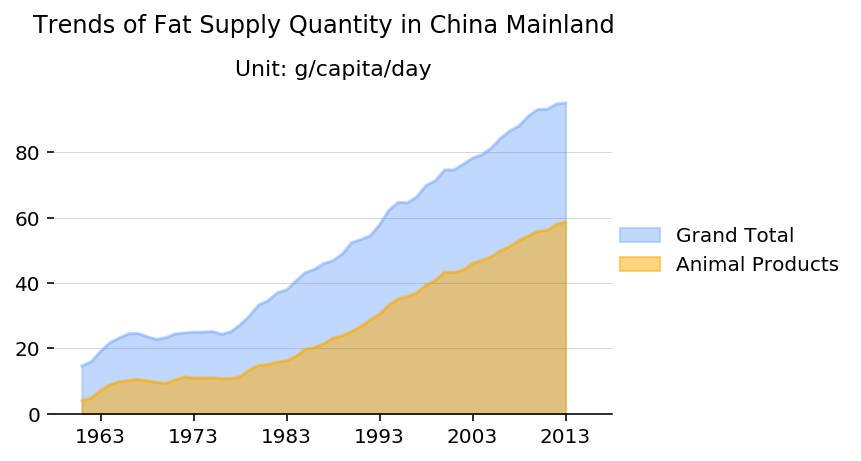

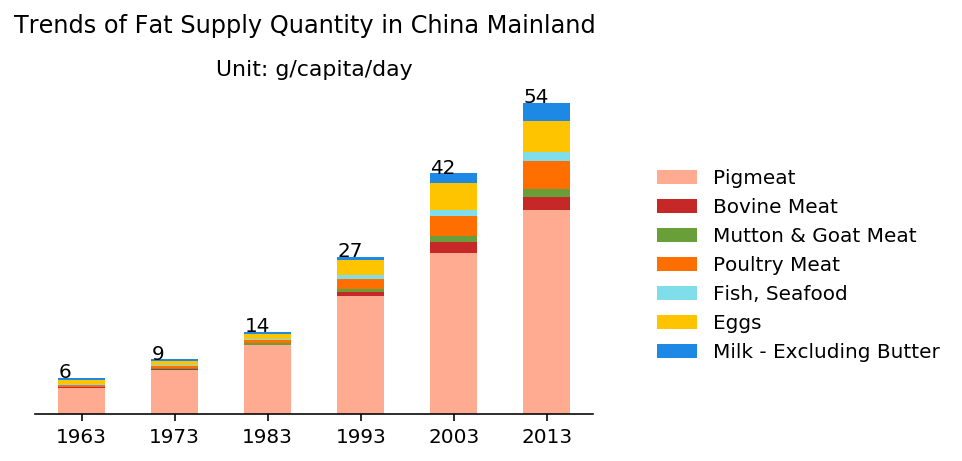

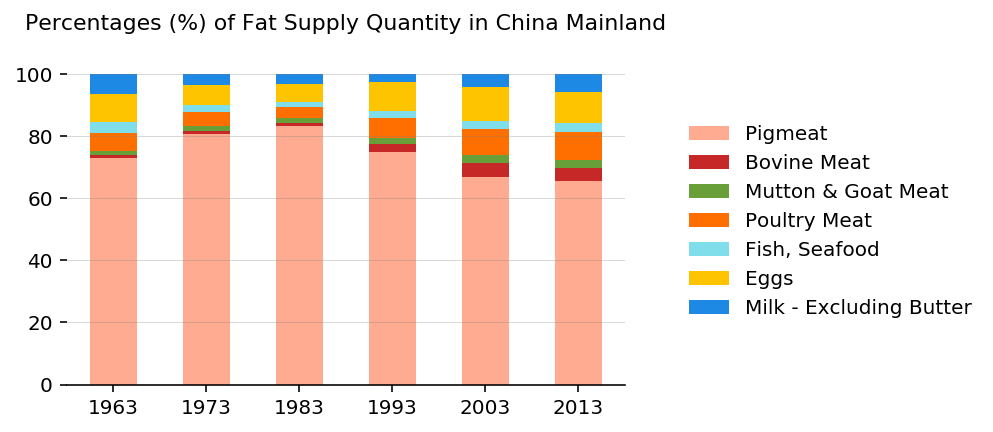

In [52]:
plotTrendsLine(A, E, items_group='Grand Total', toUnit='g/capita/day', kind='area', colors=[GF_blue1, GF_amber2], alpha=0.5)
plotTrendsBar(A, E, toUnit='g/capita/day')

Grand Total  Animal Products
1963        128.0            109.0
1973        125.0             96.0
1983        105.0             85.0
1993         90.0             67.0
2003         70.0             48.0
2013         52.0             37.0

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_02_Changes in World Rankings of China Mainland Per Capita Fat Supply Quantity .png


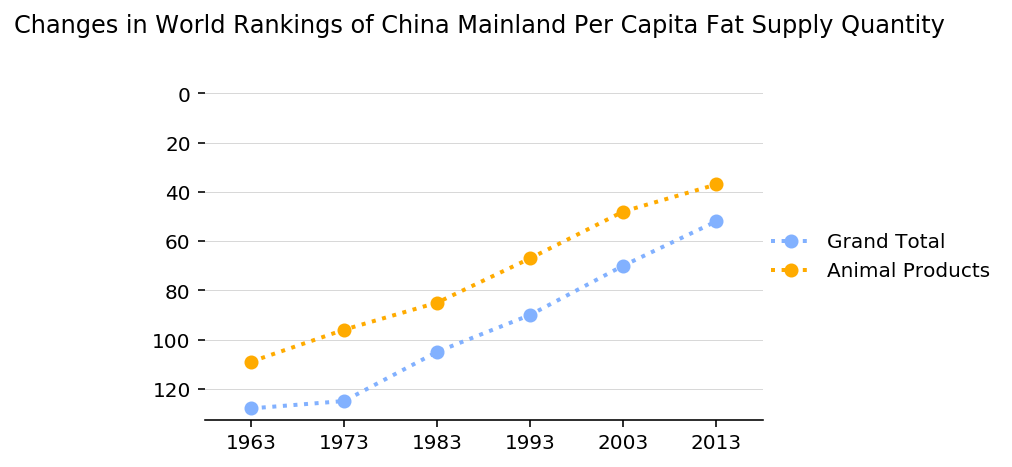

In [53]:
ranking_AreaItemInWorld(A,E, items_group='Grand Total', colors=[GF_blue1, GF_amber2])

In [54]:
worldMap(
    element = E,
    items=['Animal Products'],
    toUnit = 'g/papita/day',
    changeUnit = 1,
    years = [Years[-1]-40, Years[-1]-20, Years[-1]],
    fill_color_='YlOrBr',
)

Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Fat supply quantity (gcapitaday)_03_01_Fat Supply Quantity _Animal Products_1973.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Fat supply quantity (gcapitaday)_03_01_Fat Supply Quantity _Animal Products_1993.html
Atala saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/map/Capita_Fat supply quantity (gcapitaday)_03_01_Fat Supply Quantity _Animal Products_2013.html


1973   1993   2013
Argentina  64.57  70.12  71.32
Australia  88.07  71.43  74.37
Austria    85.55  95.34  92.46
Belgium      NaN    NaN  94.17
Brazil     22.65  33.43  58.20

World


Grand Total  Animal Products
2009        80.91            36.26
2010        81.74            36.76
2011        82.41            36.93
2012        82.83            37.36
2013        82.76            37.55

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in World.png
Northern America


Grand Total  Animal Products
2009       157.87            68.06
2010       158.76            68.32
2011       160.51            67.47
2012       160.92            67.72
2013       160.10            67.49

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in Northern America.png
Western Europe


Grand Total  Animal Products
2009       151.42            86.15
2010       151.52            86.08
2011       151.55            86.04
2012       149.36            84.19
2013       149.19            85.01

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in Western Europe.png
Australia & New Zealand


Grand Total  Animal Products
2009       139.12            73.79
2010       141.43            72.13
2011       143.90            77.20
2012       146.60            74.93
2013       145.22            75.31

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in Australia & New Zealand.png
South-Eastern Asia


Grand Total  Animal Products
2009        57.58            22.43
2010        59.15            23.26
2011        60.55            23.68
2012        60.19            23.68
2013        60.74            23.93

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in South-Eastern Asia.png
Japan


Grand Total  Animal Products
2009        85.49            33.44
2010        87.51            33.56
2011        87.17            33.59
2012        87.23            34.03
2013        86.60            33.52

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in Japan.png
Republic of Korea


Grand Total  Animal Products
2009        96.96            36.05
2010        99.99            36.24
2011       102.74            37.90
2012       105.21            38.72
2013       102.31            38.86

Img saved as: /mnt/sda2/_hub/projects/GoodFood/meat-atlas/results/FAO_FoodSupply_LivestockFish/img/Capita_Fat supply quantity (gcapitaday)_01_01_Trends of Fat Supply Quantity in Republic Of Korea.png


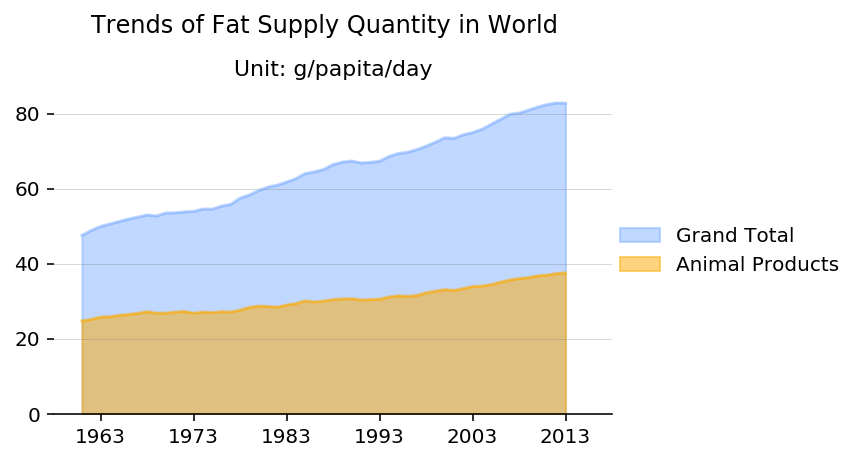

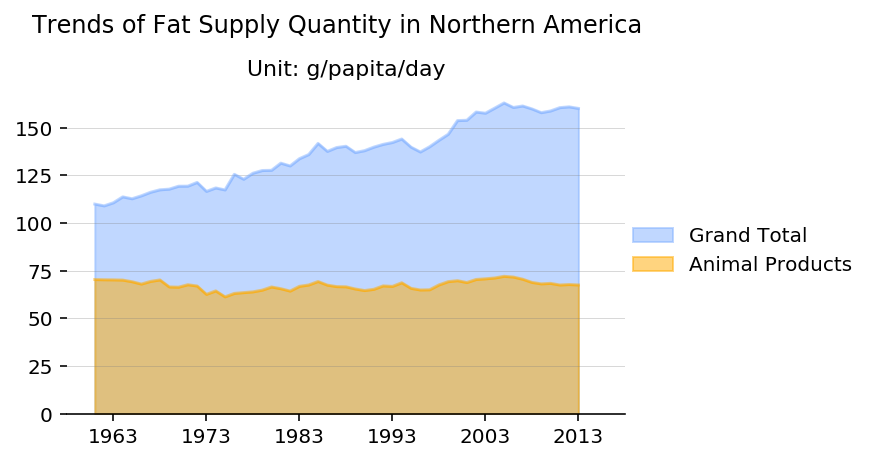

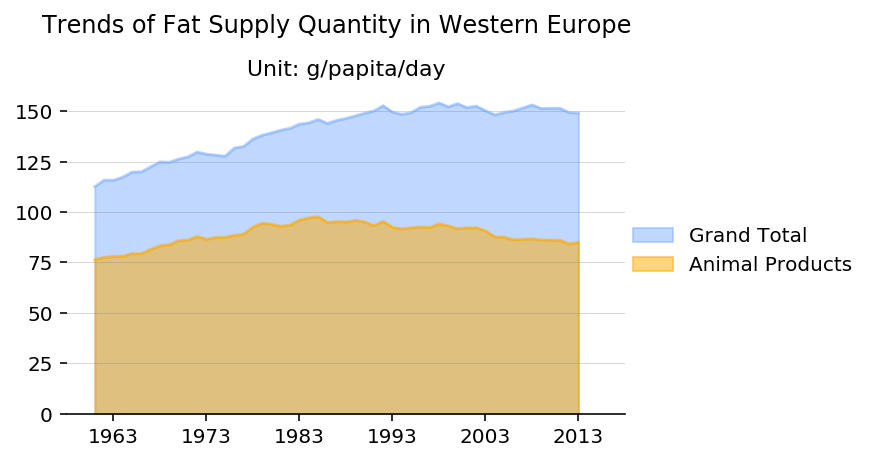

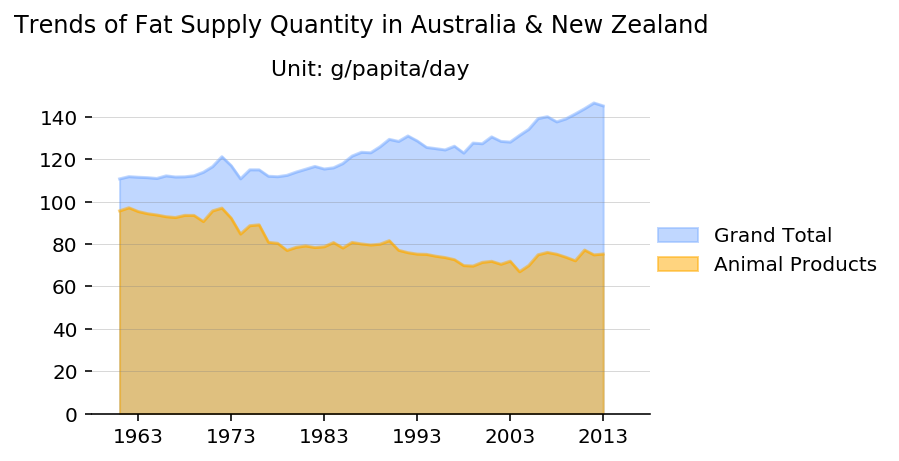

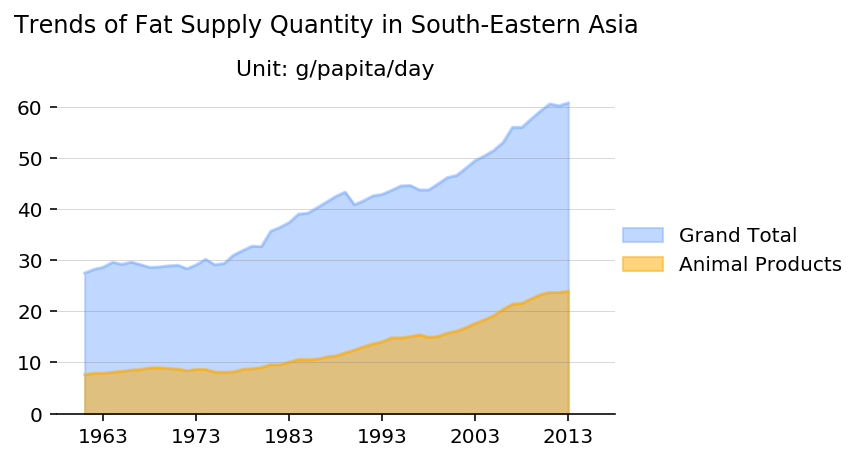

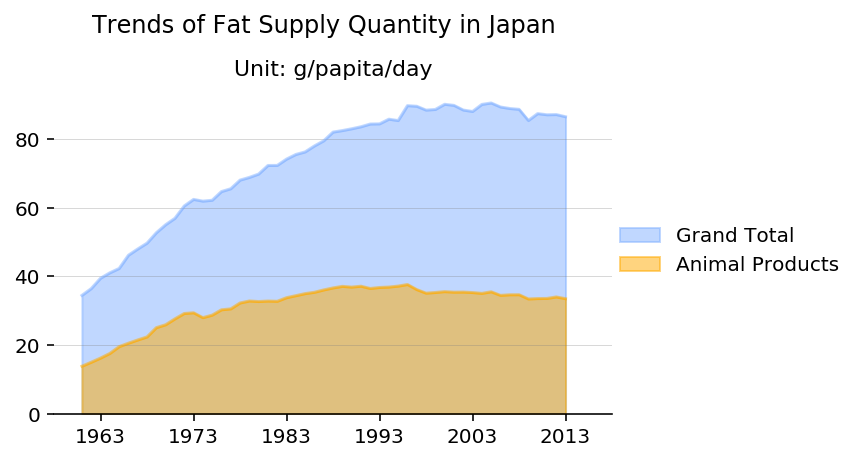

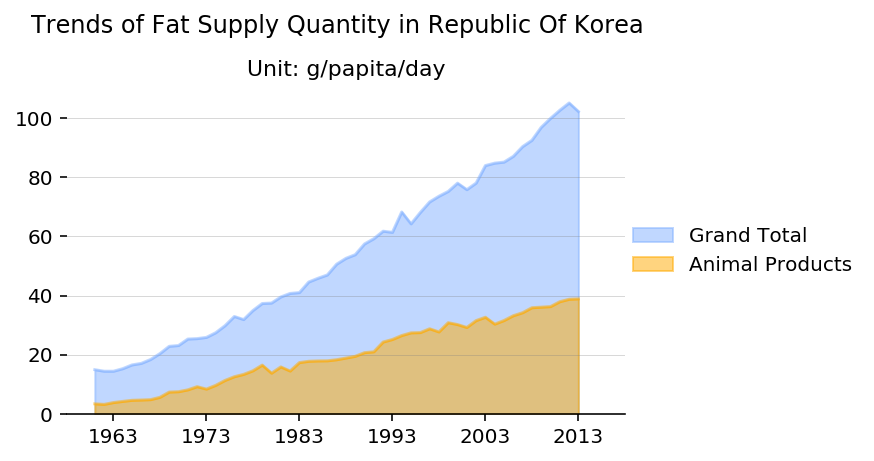

In [55]:
areas = [
    'World', 'Northern America', 'Western Europe', 'Australia & New Zealand',
    'South-Eastern Asia', 'Japan', 'Republic of Korea',
]
for a in areas:
    print(a)
    plotTrendsLine(a, E, items_group='Grand Total', kind='area', alpha=0.5, colors=[GF_blue1, GF_amber2], toUnit = 'g/papita/day',)